In [83]:
#!pip install nb_black  --> I don't know what these two does, so I just comment them.
# AM: It formats the code nicely according to best practice - https://github.com/dnanhkhoa/nb_black

<IPython.core.display.Javascript object>

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

#### AM Comments (05.02):
1. Data was not synchronzied as required
2. There are no exchange rates in the dataset
3. Porfolio weights do not sum up to 1
4. Max of returns is x 100 (but this is also the case in the descr. statistics for assignment of last year) - I think this is OK
5. There is a very small misalignment in the descriptive statistics of the data, meaning that we are unable to fully replicate the synchronized dataset, therefore small differences in VaR and ES estimates are also expected (since we do not use the same underlying data).

# QRM First Assignment - Validation

## Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats import norm
import scipy as sc
import glob
import matplotlib.pyplot as plt
import os

## Exploratory Data Analysis

In [2]:
"""Import data"""
prices = pd.read_csv("01_Data/daily_data.csv",)
data = pd.read_csv("01_Data/returns_data.csv")


"""Check format of the datasets"""
print(prices.shape)
print(data.shape)

"""Check if there is null or empty input for any of the datasets."""
print(data.isnull().sum())

(2622, 31)
(2620, 5)
Date          0
SP500       213
STOXX       186
Treas10Y    238
CrudeOil    236
dtype: int64


In [3]:
"""Create a copy of the original dataset to explore descriptive statistics"""
data2 = pd.read_csv("01_Data/returns_data.csv")

data2["portfolio_return"] = (
    0.25 * data2["SP500"]
    + 0.25 * data2["STOXX"]
    + 0.40 * data2["Treas10Y"]
    + 0.10 * data2["CrudeOil"]
)
"""Statistics on risk factor"""
print(data2.describe())
print(data2.skew())
print(data2.kurtosis())

             SP500        STOXX     Treas10Y     CrudeOil  portfolio_return
count  2407.000000  2434.000000  2382.000000  2384.000000       2284.000000
mean      0.044654     0.021169     0.020096    -0.028894          0.020528
std       1.164913     1.063189     0.779378     2.327241          0.690067
min      -9.507371   -12.191490    -3.169709   -28.325419         -5.705249
25%      -0.520368    -0.455408    -0.428607    -1.139393         -0.337898
50%       0.077535     0.050124     0.008674     0.025694          0.031591
75%       0.662531     0.553372     0.480455     1.104670          0.417757
max       9.563211     8.070359     4.618856    24.637877          4.357825
SP500              -0.209954
STOXX              -0.756280
Treas10Y            0.209646
CrudeOil           -0.751114
portfolio_return   -0.379940
dtype: float64
SP500                8.329741
STOXX               11.721231
Treas10Y             2.121937
CrudeOil            23.192388
portfolio_return     5.299786
dtype:

In [4]:
"""Split the dataset"""
SP500 = data[["Date", "SP500"]]
STOXX = data[["Date", "STOXX"]]
Treas10Y = data[["Date", "Treas10Y"]]
CrudeOil = data[["Date", "CrudeOil"]]

In [5]:
SP500 = SP500.dropna(axis=0)
SP500 = SP500.reset_index(drop=True)
STOXX = STOXX.dropna(axis=0)
STOXX = STOXX.reset_index(drop=True)
Treas10Y = Treas10Y.dropna(axis=0)
Treas10Y = Treas10Y.reset_index(drop=True)
CrudeOil = CrudeOil.dropna(axis=0)
CrudeOil = CrudeOil.reset_index(drop=True)
print(len(SP500))
print(len(STOXX))
print(len(Treas10Y))
print(len(CrudeOil))

2407
2434
2382
2384


In [6]:
"""Synchronize data"""

s1 = set(SP500["Date"])
s2 = set(STOXX["Date"])
s3 = set(Treas10Y["Date"])
s4 = set(CrudeOil["Date"])

d = [x for x in s3 if x in s2 and x in s3 and x in s4]

asset = [s1, s2, s3, s4]

intersec = s1.intersection(s2, s3, s4)
print(len(intersec))
print(len(d))
set(d) == set(intersec)

print("The dates exist in all five dataset: 2284 trading days")

2284
2284
The dates exist in all five dataset: 2284 trading days


In [7]:
"""  Create new dataframes, keep only the overlapping date-related data"""

new = []
asset = [SP500, STOXX, Treas10Y, CrudeOil]
for item in asset:
    miss = []
    for i in item["Date"]:
        if i not in intersec:
            miss = miss + item.index[item["Date"] == i].tolist()
    item = item.drop(miss)
    item = item.reset_index(drop=True)
    new.append(item)

In [8]:
""" Assign the dataframe """

SP500_new = new[0]
STOXX_new = new[1]
Treas10Y_new = new[2]
CrudeOil_new = new[3]

asset = [SP500_new, STOXX_new, Treas10Y_new, CrudeOil_new]

for i in asset:
    print(i.shape)
    print(i.isnull().sum())

(2284, 2)
Date     0
SP500    0
dtype: int64
(2284, 2)
Date     0
STOXX    0
dtype: int64
(2284, 2)
Date        0
Treas10Y    0
dtype: int64
(2284, 2)
Date        0
CrudeOil    0
dtype: int64


In [9]:
"""Merge data """
data = pd.concat(asset, axis=1)
"""Drop duplicate columns"""
data = data.loc[:, ~data.columns.duplicated()]
data.head()
# print(len(data))

Date     SP500     STOXX  Treas10Y  CrudeOil
0  2010-04-07 -0.189486 -0.282542  1.444940 -0.711718
1  2010-04-08  0.242054 -0.871208 -0.403221 -0.667007
2  2010-04-09 -0.374723  1.291011 -0.947138 -1.592828
3  2010-04-12 -0.525300 -0.140978 -0.274654 -1.387146
4  2010-04-13 -0.023975 -0.249041  0.265914 -0.436922

In [10]:
"""Skip stressed returns for now and move to portfolio returns"""

data["portfolio_return"] = (
    0.25 * data["SP500"]
    + 0.25 * data["STOXX"]
    + 0.40 * data["Treas10Y"]
    + 0.10 * data["CrudeOil"]
)

print(data.describe())
print(data.skew())
print(data.kurtosis())

             SP500        STOXX     Treas10Y     CrudeOil  portfolio_return
count  2284.000000  2284.000000  2284.000000  2284.000000       2284.000000
mean      0.044282     0.021728     0.013870    -0.015222          0.020528
std       1.180474     1.072595     0.778457     2.340144          0.690067
min      -9.507371   -12.191490    -3.169709   -28.325419         -5.705249
25%      -0.526308    -0.459977    -0.441804    -1.131777         -0.337898
50%       0.078021     0.056295     0.003332     0.034901          0.031591
75%       0.663711     0.558345     0.476572     1.104670          0.417757
max       9.563211     8.070359     4.618856    24.637877          4.357825
SP500              -0.214226
STOXX              -0.781290
Treas10Y            0.194341
CrudeOil           -0.760452
portfolio_return   -0.379940
dtype: float64
SP500                8.272307
STOXX               11.871997
Treas10Y             2.160380
CrudeOil            23.656145
portfolio_return     5.299786
dtype:

In [11]:
number = [0,500,1000,1500,2000]
dates = []
for i in number:
    print(data.Date[i])
    dates.append(data.Date[i][:4])


2010-04-07
2012-05-24
2014-08-14
2016-10-03
2018-12-12


### 3. Plots

C:\Users\Asus\.conda\envs\py37\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


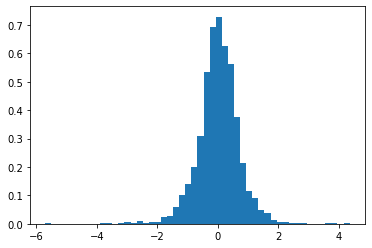

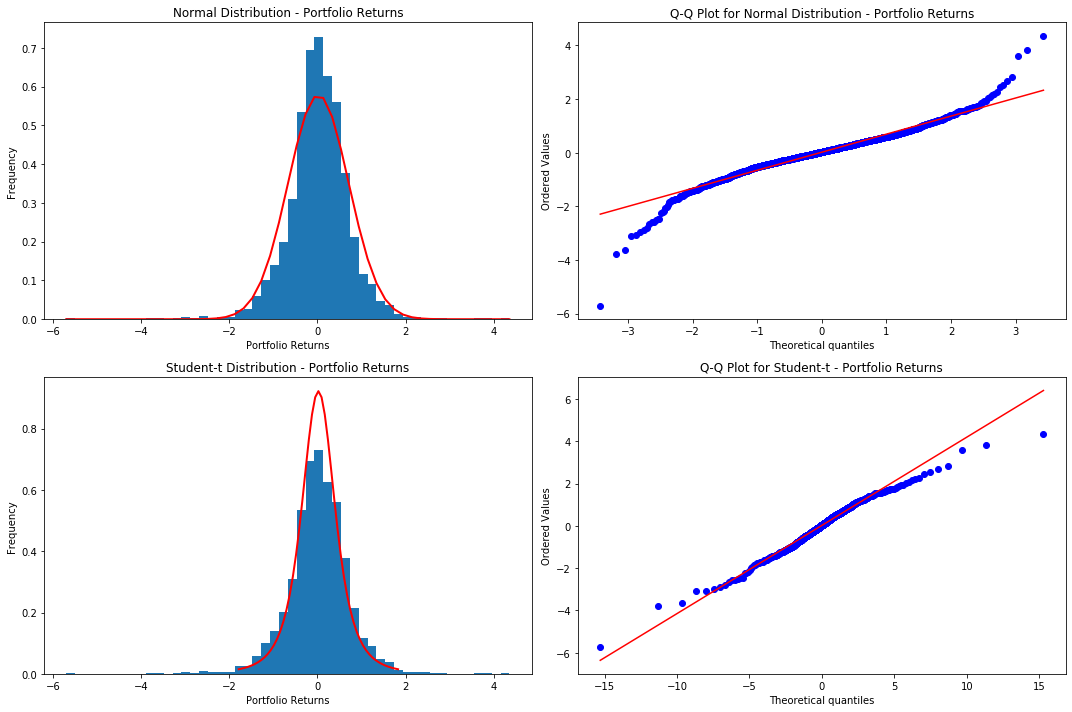

<IPython.core.display.Javascript object>

In [71]:
##assign df:
df = 3
# create distributions
mu = np.mean(data["portfolio_return"][1:])
sigma = np.std(data["portfolio_return"][1:])
sigmat = np.sqrt(np.var(data["portfolio_return"][1:]) * (df - 2) / df)
count, bins, ignored = plt.hist(data["portfolio_return"][1:], bins=50, normed=True)
normaldistr = (
    1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-((bins - mu) ** 2) / (2 * sigma ** 2))
)
tval = np.linspace(
    sc.stats.t.ppf(0.01, df, mu, sigmat), sc.stats.t.ppf(0.99, df, mu, sigmat), 51
)
tdistr = sc.stats.t.pdf(tval, df, mu, sigmat)  # Simulate t-distribution
### figure for t distr. and normal distr. comparison
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
# normal
plt.subplot(2, 2, 1)
count, bins, ignored = plt.hist(data["portfolio_return"][1:], bins=50, density=True)
plt.plot(bins, normaldistr, linewidth=2, color="r")
plt.xlabel("Portfolio Returns")
plt.ylabel("Frequency")
# plt.xlim( (-40000, 40000) )
plt.title("Normal Distribution - Portfolio Returns")
# normal qq
plt.subplot(2, 2, 2)
sc.stats.probplot(data["portfolio_return"][1:], dist="norm", plot=plt)
plt.title("Q-Q Plot for Normal Distribution - Portfolio Returns")
# stundent t
plt.subplot(2, 2, 3)
count, bins, ignored = plt.hist(data["portfolio_return"][1:], bins=50, density=True)
plt.plot(tval, tdistr, linewidth=2, color="r")
plt.xlabel("Portfolio Returns")
plt.ylabel("Frequency")
# plt.xlim( (-40000, 40000) )
plt.title("Student-t Distribution - Portfolio Returns")
# student t qq
plt.subplot(2, 2, 4)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(df), plot=plt)
plt.title("Q-Q Plot for Student-t - Portfolio Returns")
plt.tight_layout()
plt.show()

[-500.    0.  500. 1000. 1500. 2000. 2500.]
[-500.    0.  500. 1000. 1500. 2000. 2500.]
[-500.    0.  500. 1000. 1500. 2000. 2500.]
[-500.    0.  500. 1000. 1500. 2000. 2500.]


([<matplotlib.axis.XTick at 0x14c21daa4c8>,
 <a list of 5 Text xticklabel objects>)

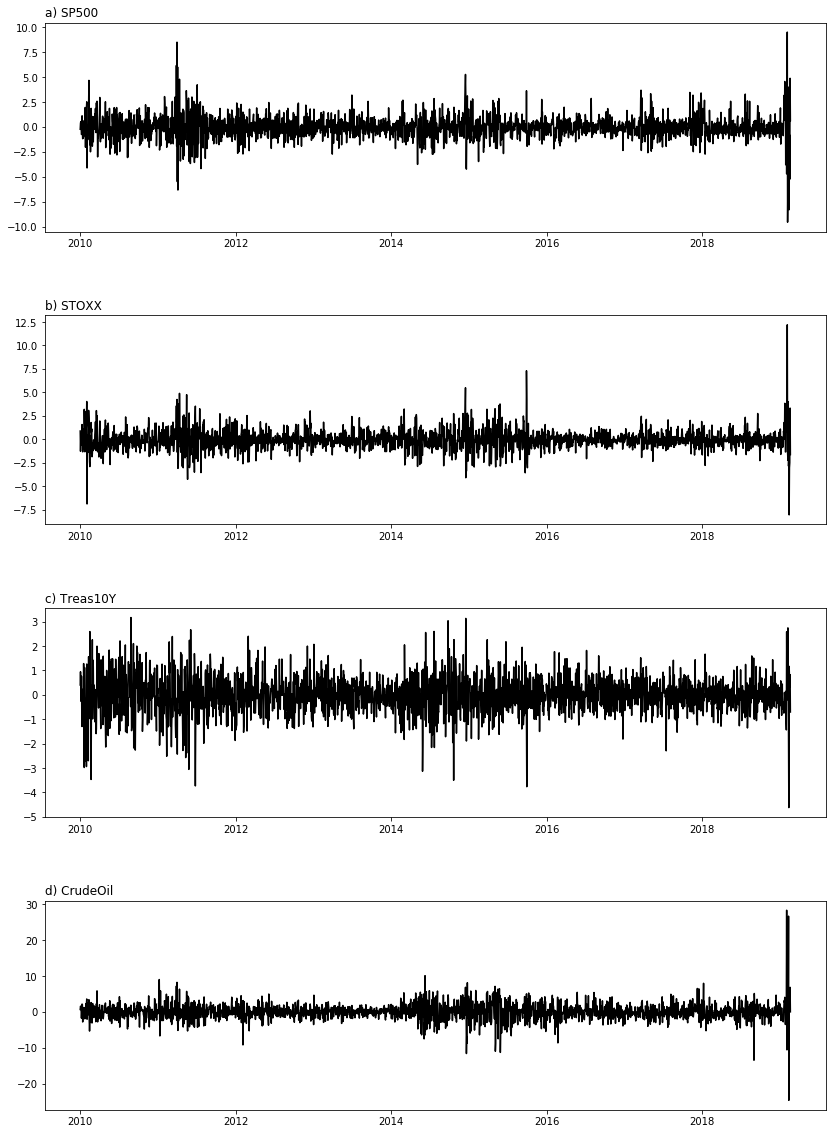

<IPython.core.display.Javascript object>

In [72]:
# plot of risk factor returns
"""I plot them as the negative of returns, so all are losses"""
fig, ax = plt.subplots(nrows=5, ncols=1, figsize=(14, 20))


# SP500
plt.subplot(4, 1, 1)
plt.plot(-data["SP500"][1:], "k")
plt.title("a) SP500", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)
# STOXX
plt.subplot(4, 1, 2)
plt.plot(-data["STOXX"][1:], "k")
plt.title("b) STOXX", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)
# Treas10Y
plt.subplot(4, 1, 3)
plt.plot(-data["Treas10Y"][1:], "k")
plt.title("c) Treas10Y", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)
# CrudeOil
plt.subplot(4, 1, 4)
plt.plot(-data["CrudeOil"][1:], "k")
plt.title("d) CrudeOil", loc="left")
locs, labels = plt.xticks()
print(locs)
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.subplots_adjust(hspace=0.4)
plt.xticks(locs[1:-1], new_xticks)

In [12]:
""" All risk factors and portfolio return"""
df_prices = data[["SP500", "STOXX", "Treas10Y", "CrudeOil", "portfolio_return"]]
len(df_prices)

2284

## VaR and ES

### 1. Normal Distribution

In [30]:
def fnVaR_n(dfData, weights, alpha, lookback, percent, initial_investment):
    """
    purpose:
        calculates VaR and ES with variance-covariance method
        using a normal distribution
    input:
        dfData, dataframe
        weights, weights vector
        alpha, significance value
        lookback, lookback period
        percent, True= express in percent
    output:
        VaR expressed in losses (positive value)
    """
    # check alpha
    if alpha > 0.5:
        alpha = 1 - alpha

    # express years in days
    years = lookback
    # select last n years of data
    DataTemp = dfData.iloc[-years :, :-1]  # converted to days

    # calculate mean
    mean = np.array(np.mean(DataTemp)) @ weights.T
    mean = mean[0]

    # calculate covariance
    cov = np.cov(DataTemp, rowvar=False)
    # calculate variance
    variance = weights @ cov @ weights.T
    std = np.sqrt(variance[0][0])

    # calculate quantile
    z = sc.stats.norm.ppf(alpha)
    VaR = (
        mean + z * std
    )  # μ is negative of the return over one day, so should be negative sign
    VaR = -VaR

    mean_return = dfData["portfolio_return"][-years  :]
    ES_list = [x for x in mean_return if x < -VaR]
    ES = -np.mean(ES_list)

    ##Prepare Output
    if percent[0] == True:
        print(
            "(",
            percent[1]*100,
            "%",
            " VaR, ES) in percent is: ",
            round(VaR, 2),
            "%",
            round(ES, 2),
            "%",
        )
    else:

        print(
            "(",
            percent[1]*100,
            "%",
            " VaR, ES) in monetary terms is: ",
            round(VaR * initial_investment, 2),
            round(ES * initial_investment, 2),
        )

    return VaR, ES


#### 1.1. Non-stressed Estimates

In [31]:
# Set an initial investment level
initial_investment = 1000000
lookback = 2284
""" All time period"""

weights = np.array([[0.25, 0.25, 0.40, 0.1]])


fnVaR_n(df_prices, weights, 0.025, lookback, [True, 0.975], initial_investment)
fnVaR_n(df_prices, weights, 0.025, lookback, [False, 0.975], initial_investment)
fnVaR_n(df_prices, weights, 0.01, lookback, [True, 0.99], initial_investment)
fnVaR_n(df_prices, weights, 0.01, lookback, [False, 0.99], initial_investment)

( 97.5 %  VaR, ES) in percent is:  1.33 % 1.92 %
( 97.5 %  VaR, ES) in monetary terms is:  1331977.93 1915355.49
( 99.0 %  VaR, ES) in percent is:  1.58 % 2.29 %
( 99.0 %  VaR, ES) in monetary terms is:  1584807.35 2293745.42


(1.5848073471207464, 2.293745416881876)

## Sensitivity 

In [58]:
VaR_trend = []
ES_trend = []
VaR_trend_ex = []
ES_trend_ex = []
# Included corona period
for i in range(15, 2108):
    VaR_trend.append(
        fnVaR_n(df_prices, weights, 0.025, i, [True, 0.975], initial_investment)[0]
    )
    ES_trend.append(
        fnVaR_n(df_prices, weights, 0.025, i, [True, 0.975], initial_investment)[1]
    )

# exclude corona
for i in range(250):
    VaR_trend_ex.append(None)
    ES_trend_ex.append(None)
for i in range(15, 1859):
    VaR_trend_ex.append(
        fnVaR_n(df_prices[:-250], weights, 0.025, i, [True, 0.975], initial_investment)[
            0
        ]
    )
    ES_trend_ex.append(
        fnVaR_n(df_prices[:-250], weights, 0.025, i, [True, 0.975], initial_investment)[
            1
        ]
    )

( 0.975 %  VaR, ES) in percent is:  5.61 % 5.94 %
( 0.975 %  VaR, ES) in percent is:  5.61 % 5.94 %
( 0.975 %  VaR, ES) in percent is:  5.39 % 5.94 %
( 0.975 %  VaR, ES) in percent is:  5.39 % 5.94 %
( 0.975 %  VaR, ES) in percent is:  5.23 % 5.94 %
( 0.975 %  VaR, ES) in percent is:  5.23 % 5.94 %
( 0.975 %  VaR, ES) in percent is:  5.15 % 5.94 %
( 0.975 %  VaR, ES) in percent is:  5.15 % 5.94 %
( 0.975 %  VaR, ES) in percent is:  5.23 % 5.94 %
( 0.975 %  VaR, ES) in percent is:  5.23 % 5.94 %
( 0.975 %  VaR, ES) in percent is:  5.1 % 5.94 %
( 0.975 %  VaR, ES) in percent is:  5.1 % 5.94 %
( 0.975 %  VaR, ES) in percent is:  5.05 % 5.94 %
( 0.975 %  VaR, ES) in percent is:  5.05 % 5.94 %
( 0.975 %  VaR, ES) in percent is:  4.93 % 5.94 %
( 0.975 %  VaR, ES) in percent is:  4.93 % 5.94 %
( 0.975 %  VaR, ES) in percent is:  4.81 % 5.94 %
( 0.975 %  VaR, ES) in percent is:  4.81 % 5.94 %
( 0.975 %  VaR, ES) in percent is:  4.69 % 5.94 %
( 0.975 %  VaR, ES) in percent is:  4.69 % 5.94 %
( 

( 0.975 %  VaR, ES) in percent is:  2.07 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.07 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.06 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.06 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.06 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.06 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.05 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.05 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.04 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.04 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.04 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.04 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.03 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.03 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.02 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.02 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.01 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.01 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.0 % 4.22 %
( 0.975 %  VaR, ES) in percent is:  2.0 % 4.22 %
( 

( 0.975 %  VaR, ES) in percent is:  1.64 % 3.86 %
( 0.975 %  VaR, ES) in percent is:  1.64 % 3.86 %
( 0.975 %  VaR, ES) in percent is:  1.63 % 3.86 %
( 0.975 %  VaR, ES) in percent is:  1.63 % 3.86 %
( 0.975 %  VaR, ES) in percent is:  1.63 % 3.86 %
( 0.975 %  VaR, ES) in percent is:  1.63 % 3.86 %
( 0.975 %  VaR, ES) in percent is:  1.63 % 3.86 %
( 0.975 %  VaR, ES) in percent is:  1.63 % 3.86 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 3.86 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 3.86 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 3.86 %
( 0.975 %  VaR, ES) in percent is:  1.62 % 3.86 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 3.86 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 3.86 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 3.86 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 3.86 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 3.86 %
( 0.975 %  VaR, ES) in percent is:  1.61 % 3.86 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 3.86 %
( 0.975 %  VaR, ES) in percent is:  1.6 % 3.86 %
( 

( 0.975 %  VaR, ES) in percent is:  1.47 % 2.89 %
( 0.975 %  VaR, ES) in percent is:  1.48 % 3.0 %
( 0.975 %  VaR, ES) in percent is:  1.48 % 3.0 %
( 0.975 %  VaR, ES) in percent is:  1.48 % 3.0 %
( 0.975 %  VaR, ES) in percent is:  1.48 % 3.0 %
( 0.975 %  VaR, ES) in percent is:  1.47 % 2.89 %
( 0.975 %  VaR, ES) in percent is:  1.47 % 2.89 %
( 0.975 %  VaR, ES) in percent is:  1.47 % 3.0 %
( 0.975 %  VaR, ES) in percent is:  1.47 % 3.0 %
( 0.975 %  VaR, ES) in percent is:  1.47 % 2.89 %
( 0.975 %  VaR, ES) in percent is:  1.47 % 2.89 %
( 0.975 %  VaR, ES) in percent is:  1.47 % 2.89 %
( 0.975 %  VaR, ES) in percent is:  1.47 % 2.89 %
( 0.975 %  VaR, ES) in percent is:  1.47 % 2.89 %
( 0.975 %  VaR, ES) in percent is:  1.47 % 2.89 %
( 0.975 %  VaR, ES) in percent is:  1.47 % 2.89 %
( 0.975 %  VaR, ES) in percent is:  1.47 % 2.89 %
( 0.975 %  VaR, ES) in percent is:  1.46 % 2.89 %
( 0.975 %  VaR, ES) in percent is:  1.46 % 2.89 %
( 0.975 %  VaR, ES) in percent is:  1.46 % 2.89 %
( 0.97

( 0.975 %  VaR, ES) in percent is:  1.37 % 2.59 %
( 0.975 %  VaR, ES) in percent is:  1.37 % 2.59 %
( 0.975 %  VaR, ES) in percent is:  1.37 % 2.59 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 2.59 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 2.59 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 2.59 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 2.59 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 2.59 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 2.59 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 2.59 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 2.59 %
( 0.975 %  VaR, ES) in percent is:  1.37 % 2.53 %
( 0.975 %  VaR, ES) in percent is:  1.37 % 2.53 %
( 0.975 %  VaR, ES) in percent is:  1.37 % 2.53 %
( 0.975 %  VaR, ES) in percent is:  1.37 % 2.53 %
( 0.975 %  VaR, ES) in percent is:  1.37 % 2.53 %
( 0.975 %  VaR, ES) in percent is:  1.37 % 2.53 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 2.53 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 2.53 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 2.53 %


( 0.975 %  VaR, ES) in percent is:  1.32 % 2.45 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.45 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.45 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.45 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.45 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.45 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.45 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.45 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.45 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.45 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.45 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 2.45 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 2.45 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 2.45 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 2.45 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 2.45 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 2.45 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 2.45 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 2.45 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 2.45 %


( 0.975 %  VaR, ES) in percent is:  1.26 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 2.28 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 2.28 %


( 0.975 %  VaR, ES) in percent is:  1.23 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.23 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.23 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 2.14 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 2.14 %


( 0.975 %  VaR, ES) in percent is:  1.2 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 2.04 %
( 0.975 % 

( 0.975 %  VaR, ES) in percent is:  1.18 % 1.92 %
( 0.975 %  VaR, ES) in percent is:  1.18 % 1.92 %
( 0.975 %  VaR, ES) in percent is:  1.18 % 1.92 %
( 0.975 %  VaR, ES) in percent is:  1.18 % 1.92 %
( 0.975 %  VaR, ES) in percent is:  1.18 % 1.92 %
( 0.975 %  VaR, ES) in percent is:  1.18 % 1.92 %
( 0.975 %  VaR, ES) in percent is:  1.18 % 1.92 %
( 0.975 %  VaR, ES) in percent is:  1.18 % 1.92 %
( 0.975 %  VaR, ES) in percent is:  1.18 % 1.92 %
( 0.975 %  VaR, ES) in percent is:  1.18 % 1.92 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 1.99 %


( 0.975 %  VaR, ES) in percent is:  1.18 % 1.92 %
( 0.975 %  VaR, ES) in percent is:  1.18 % 1.94 %
( 0.975 %  VaR, ES) in percent is:  1.18 % 1.94 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 1.94 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 1.94 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 1.94 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 1.94 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 1.94 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 1.94 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 1.94 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 1.94 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.96 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.96 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.96 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.96 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.96 %
( 0.97

( 0.975 %  VaR, ES) in percent is:  1.25 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.98 %


( 0.975 %  VaR, ES) in percent is:  1.32 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.07 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.07 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.07 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.07 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.07 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 2.07 %
( 0.975 %  VaR, ES) in percent is:  1.33 % 2.07 %


( 0.975 %  VaR, ES) in percent is:  1.35 % 2.09 %
( 0.975 %  VaR, ES) in percent is:  1.35 % 2.09 %
( 0.975 %  VaR, ES) in percent is:  1.35 % 2.09 %
( 0.975 %  VaR, ES) in percent is:  1.35 % 2.09 %
( 0.975 %  VaR, ES) in percent is:  1.35 % 2.09 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.36 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.35 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.35 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.35 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.35 % 2.08 %
( 0.975 %  VaR, ES) in percent is:  1.35 % 2.08 %


( 0.975 %  VaR, ES) in percent is:  1.33 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.33 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.33 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.33 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.33 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.33 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.33 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.33 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.33 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.33 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.33 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.33 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.33 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.33 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.33 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.33 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.33 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.33 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.33 % 2.04 %
( 0.975 %  VaR, ES) in percent is:  1.33 % 2.04 %


( 0.975 %  VaR, ES) in percent is:  1.3 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.99 %
( 0.975 %  VaR, ES) 

( 0.975 %  VaR, ES) in percent is:  1.28 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.28 % 1.98 %


( 0.975 %  VaR, ES) in percent is:  1.27 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.97 %


( 0.975 %  VaR, ES) in percent is:  1.26 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.95 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.95 %


( 0.975 %  VaR, ES) in percent is:  1.25 % 1.92 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.91 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.91 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.91 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.91 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.91 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.91 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.91 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.91 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.91 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.91 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.91 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.91 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.91 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.91 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.91 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.91 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.91 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.91 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.91 %


( 0.975 %  VaR, ES) in percent is:  1.25 % 1.9 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.9 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.9 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.9 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.9 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.9 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.9 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.89 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.89 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.89 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.89 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.89 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.89 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.89 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.89 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.89 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.89 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.89 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.89 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.89 %
( 0.975

( 0.975 %  VaR, ES) in percent is:  1.26 % 1.88 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.88 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.88 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.88 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.88 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.88 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.88 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.88 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.88 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.88 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.88 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.88 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.88 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.88 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.87 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.87 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.87 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.87 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.87 %
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.87 %


( 0.975 %  VaR, ES) in percent is:  1.31 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.99 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.98 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.98 %


( 0.975 %  VaR, ES) in percent is:  1.31 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.31 % 1.97 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.96 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.96 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.96 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.96 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.96 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.96 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.96 %
( 0.975 %  VaR, ES) in percent is:  1.32 % 1.96 %


( 0.975 %  VaR, ES) in percent is:  1.25 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.23 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.23 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.23 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.23 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.19 % 1.71 %
( 

( 0.975 %  VaR, ES) in percent is:  1.08 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.08 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.07 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.07 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.08 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.08 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.08 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.08 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.07 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.07 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.07 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.07 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.07 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.07 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.07 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.07 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.07 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.07 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.06 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.06 % 1.46 %


( 0.975 %  VaR, ES) in percent is:  1.06 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.06 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.06 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.06 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.05 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.05 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.05 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.05 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.05 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.05 % 1.46 %
( 0.975 %  VaR, ES) in percent is:  1.06 % 1.44 %
( 0.975 %  VaR, ES) in percent is:  1.06 % 1.44 %
( 0.975 %  VaR, ES) in percent is:  1.06 % 1.44 %
( 0.975 %  VaR, ES) in percent is:  1.06 % 1.44 %
( 0.975 %  VaR, ES) in percent is:  1.06 % 1.44 %
( 0.975 %  VaR, ES) in percent is:  1.06 % 1.44 %
( 0.975 %  VaR, ES) in percent is:  1.06 % 1.44 %
( 0.975 %  VaR, ES) in percent is:  1.06 % 1.44 %
( 0.975 %  VaR, ES) in percent is:  1.06 % 1.44 %
( 0.975 %  VaR, ES) in percent is:  1.06 % 1.44 %


( 0.975 %  VaR, ES) in percent is:  1.03 % 1.41 %
( 0.975 %  VaR, ES) in percent is:  1.02 % 1.41 %
( 0.975 %  VaR, ES) in percent is:  1.02 % 1.41 %
( 0.975 %  VaR, ES) in percent is:  1.03 % 1.4 %
( 0.975 %  VaR, ES) in percent is:  1.03 % 1.4 %
( 0.975 %  VaR, ES) in percent is:  1.03 % 1.4 %
( 0.975 %  VaR, ES) in percent is:  1.03 % 1.4 %
( 0.975 %  VaR, ES) in percent is:  1.03 % 1.4 %
( 0.975 %  VaR, ES) in percent is:  1.03 % 1.4 %
( 0.975 %  VaR, ES) in percent is:  1.03 % 1.42 %
( 0.975 %  VaR, ES) in percent is:  1.03 % 1.42 %
( 0.975 %  VaR, ES) in percent is:  1.04 % 1.43 %
( 0.975 %  VaR, ES) in percent is:  1.04 % 1.43 %
( 0.975 %  VaR, ES) in percent is:  1.04 % 1.43 %
( 0.975 %  VaR, ES) in percent is:  1.04 % 1.43 %
( 0.975 %  VaR, ES) in percent is:  1.04 % 1.43 %
( 0.975 %  VaR, ES) in percent is:  1.04 % 1.43 %
( 0.975 %  VaR, ES) in percent is:  1.04 % 1.43 %
( 0.975 %  VaR, ES) in percent is:  1.04 % 1.43 %
( 0.975 %  VaR, ES) in percent is:  1.03 % 1.43 %
( 0.97

( 0.975 %  VaR, ES) in percent is:  1.01 % 1.37 %
( 0.975 %  VaR, ES) in percent is:  1.01 % 1.37 %
( 0.975 %  VaR, ES) in percent is:  1.01 % 1.37 %
( 0.975 %  VaR, ES) in percent is:  1.01 % 1.37 %
( 0.975 %  VaR, ES) in percent is:  1.01 % 1.37 %
( 0.975 %  VaR, ES) in percent is:  1.0 % 1.37 %
( 0.975 %  VaR, ES) in percent is:  1.0 % 1.37 %
( 0.975 %  VaR, ES) in percent is:  1.0 % 1.37 %
( 0.975 %  VaR, ES) in percent is:  1.0 % 1.37 %
( 0.975 %  VaR, ES) in percent is:  1.0 % 1.37 %
( 0.975 %  VaR, ES) in percent is:  1.0 % 1.37 %
( 0.975 %  VaR, ES) in percent is:  1.0 % 1.37 %
( 0.975 %  VaR, ES) in percent is:  1.0 % 1.37 %
( 0.975 %  VaR, ES) in percent is:  1.0 % 1.37 %
( 0.975 %  VaR, ES) in percent is:  1.0 % 1.37 %
( 0.975 %  VaR, ES) in percent is:  1.0 % 1.37 %
( 0.975 %  VaR, ES) in percent is:  1.0 % 1.37 %
( 0.975 %  VaR, ES) in percent is:  1.0 % 1.37 %
( 0.975 %  VaR, ES) in percent is:  1.0 % 1.37 %
( 0.975 %  VaR, ES) in percent is:  1.0 % 1.36 %
( 0.975 %  VaR,

( 0.975 %  VaR, ES) in percent is:  1.03 % 1.43 %
( 0.975 %  VaR, ES) in percent is:  1.03 % 1.43 %
( 0.975 %  VaR, ES) in percent is:  1.03 % 1.43 %
( 0.975 %  VaR, ES) in percent is:  1.03 % 1.43 %
( 0.975 %  VaR, ES) in percent is:  1.03 % 1.43 %
( 0.975 %  VaR, ES) in percent is:  1.03 % 1.43 %
( 0.975 %  VaR, ES) in percent is:  1.03 % 1.43 %
( 0.975 %  VaR, ES) in percent is:  1.03 % 1.43 %
( 0.975 %  VaR, ES) in percent is:  1.03 % 1.43 %
( 0.975 %  VaR, ES) in percent is:  1.03 % 1.42 %
( 0.975 %  VaR, ES) in percent is:  1.03 % 1.42 %
( 0.975 %  VaR, ES) in percent is:  1.03 % 1.44 %
( 0.975 %  VaR, ES) in percent is:  1.03 % 1.44 %
( 0.975 %  VaR, ES) in percent is:  1.04 % 1.44 %
( 0.975 %  VaR, ES) in percent is:  1.04 % 1.44 %
( 0.975 %  VaR, ES) in percent is:  1.04 % 1.44 %
( 0.975 %  VaR, ES) in percent is:  1.04 % 1.44 %
( 0.975 %  VaR, ES) in percent is:  1.04 % 1.44 %
( 0.975 %  VaR, ES) in percent is:  1.04 % 1.44 %
( 0.975 %  VaR, ES) in percent is:  1.04 % 1.44 %


( 0.975 %  VaR, ES) in percent is:  1.12 % 1.55 %
( 0.975 %  VaR, ES) in percent is:  1.12 % 1.55 %
( 0.975 %  VaR, ES) in percent is:  1.12 % 1.55 %
( 0.975 %  VaR, ES) in percent is:  1.12 % 1.55 %
( 0.975 %  VaR, ES) in percent is:  1.12 % 1.55 %
( 0.975 %  VaR, ES) in percent is:  1.12 % 1.55 %
( 0.975 %  VaR, ES) in percent is:  1.12 % 1.54 %
( 0.975 %  VaR, ES) in percent is:  1.12 % 1.54 %
( 0.975 %  VaR, ES) in percent is:  1.12 % 1.54 %
( 0.975 %  VaR, ES) in percent is:  1.12 % 1.54 %
( 0.975 %  VaR, ES) in percent is:  1.12 % 1.54 %
( 0.975 %  VaR, ES) in percent is:  1.12 % 1.54 %
( 0.975 %  VaR, ES) in percent is:  1.12 % 1.54 %
( 0.975 %  VaR, ES) in percent is:  1.12 % 1.54 %
( 0.975 %  VaR, ES) in percent is:  1.13 % 1.55 %
( 0.975 %  VaR, ES) in percent is:  1.13 % 1.55 %
( 0.975 %  VaR, ES) in percent is:  1.14 % 1.58 %
( 0.975 %  VaR, ES) in percent is:  1.14 % 1.58 %
( 0.975 %  VaR, ES) in percent is:  1.14 % 1.58 %
( 0.975 %  VaR, ES) in percent is:  1.14 % 1.58 %


( 0.975 %  VaR, ES) in percent is:  1.25 % 1.79 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.79 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.79 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.79 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.79 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.79 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.79 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.79 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.79 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.79 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.79 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.79 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.79 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.79 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.25 % 1.78 %


( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %


( 0.975 %  VaR, ES) in percent is:  1.3 % 1.83 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.83 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.82 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.82 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.82 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.82 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.82 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.82 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.82 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.82 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.82 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.82 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.82 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.82 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.82 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.82 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.82 %
( 0.975 %  VaR, ES) in percent is:  1.3 % 1.82 %
( 0.975 %  VaR, ES) 

( 0.975 %  VaR, ES) in percent is:  1.27 % 1.8 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.8 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.8 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.8 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.8 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.8 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.8 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.8 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.8 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.8 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.8 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.8 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.8 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.8 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.8 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.8 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.8 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.8 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.8 %
( 0.975 %  VaR, ES) in percent is:  1.27 % 1.8 %
( 0.975 %  VaR, ES) 

( 0.975 %  VaR, ES) in percent is:  1.24 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.78 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.78 %


( 0.975 %  VaR, ES) in percent is:  1.22 % 1.76 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.76 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.76 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.76 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.76 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.76 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.76 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.76 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.76 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.76 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.76 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.76 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.76 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.76 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.76 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.76 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.76 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.76 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.76 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.76 %


( 0.975 %  VaR, ES) in percent is:  1.22 % 1.77 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.77 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.77 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.77 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.77 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.77 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.77 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.77 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.77 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.77 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.77 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.77 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.77 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.77 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.77 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.77 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.77 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.77 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.77 %
( 0.975 %  VaR, ES) in percent is:  1.22 % 1.77 %


( 0.975 %  VaR, ES) in percent is:  1.21 % 1.75 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.75 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.75 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.75 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.75 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.75 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.75 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.75 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.75 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.74 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.74 %


( 0.975 %  VaR, ES) in percent is:  1.21 % 1.73 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.73 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.73 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.73 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.73 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.73 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.73 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.73 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.73 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.73 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.73 %
( 0.975 %  VaR, ES) in percent is:  1.21 % 1.73 %


( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) in percent is:  1.2 % 1.71 %
( 0.975 %  VaR, ES) 

( 0.975 %  VaR, ES) in percent is:  1.23 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.72 %
( 0.975 %  VaR, ES) in percent is:  1.24 % 1.72 %


( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 0.975 %  VaR, ES) in percent is:  1.29 % 1.81 %


<IPython.core.display.Javascript object>

The values without corona (stress period) are lower


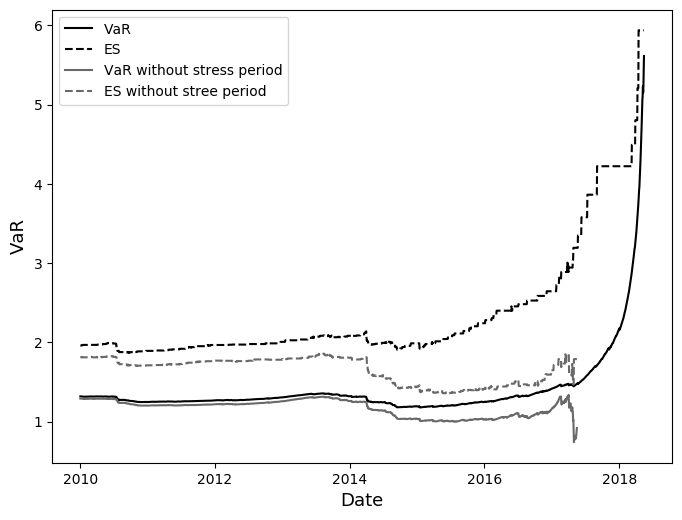

<IPython.core.display.Javascript object>

In [59]:
print("The values without corona (stress period) are lower")
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(VaR_trend[::-1], label="VaR", color="k")
plt.plot(ES_trend[::-1], label="ES", color="k", ls="--")
plt.plot(VaR_trend_ex[::-1], label="VaR without stress period", color="#696969")
plt.plot(ES_trend_ex[::-1], label="ES without stree period", color="#696969", ls="--")
# plt.xticks(np.arange(8), (1, 2, 3, 4, 5, 6, 7, 8))
plt.xlabel("Date", fontsize=13)
plt.ylabel("VaR", fontsize=13)
locs, labels = plt.xticks()
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)
plt.legend()

In [60]:
VaR_trend = []
ES_trend = []
VaR_trend_ex = []
ES_trend_ex = []
# Included corona period
for i in range(15, 2108):
    VaR_trend.append(
        fnVaR_n(df_prices, weights, 0.01, i, [True, 0.99], initial_investment)[0]
    )
    ES_trend.append(
        fnVaR_n(df_prices, weights, 0.01, i, [True, 0.99], initial_investment)[1]
    )

# exclude corona
for i in range(250):
    VaR_trend_ex.append(None)
    ES_trend_ex.append(None)
for i in range(15, 1859):
    VaR_trend_ex.append(
        fnVaR_n(df_prices[:-250], weights, 0.01, i, [True, 0.99], initial_investment)[0]
    )
    ES_trend_ex.append(
        fnVaR_n(df_prices[:-250], weights, 0.01, i, [True, 0.99], initial_investment)[1]
    )

( 0.99 %  VaR, ES) in percent is:  6.6 % nan %
( 0.99 %  VaR, ES) in percent is:  6.6 % nan %
( 0.99 %  VaR, ES) in percent is:  6.36 % nan %
( 0.99 %  VaR, ES) in percent is:  6.36 % nan %
( 0.99 %  VaR, ES) in percent is:  6.16 % nan %
( 0.99 %  VaR, ES) in percent is:  6.16 % nan %
( 0.99 %  VaR, ES) in percent is:  6.06 % 6.07 %
( 0.99 %  VaR, ES) in percent is:  6.06 % 6.07 %
( 0.99 %  VaR, ES) in percent is:  6.13 % nan %
( 0.99 %  VaR, ES) in percent is:  6.13 % nan %
( 0.99 %  VaR, ES) in percent is:  5.98 % 6.07 %
( 0.99 %  VaR, ES) in percent is:  5.98 % 6.07 %
( 0.99 %  VaR, ES) in percent is:  5.91 % 6.07 %
( 0.99 %  VaR, ES) in percent is:  5.91 % 6.07 %
( 0.99 %  VaR, ES) in percent is:  5.77 % 5.94 %
( 0.99 %  VaR, ES) in percent is:  5.77 % 5.94 %
( 0.99 %  VaR, ES) in percent is:  5.63 % 5.94 %
( 0.99 %  VaR, ES) in percent is:  5.63 % 5.94 %
( 0.99 %  VaR, ES) in percent is:  5.5 % 5.94 %
( 0.99 %  VaR, ES) in percent is:  5.5 % 5.94 %
( 0.99 %  VaR, ES) in percent is

( 0.99 %  VaR, ES) in percent is:  2.62 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.61 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.61 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.6 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.6 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.59 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.59 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.58 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.58 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.56 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.56 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.58 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.58 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.57 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.57 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.56 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.56 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.55 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.55 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  2.54 % 4.22 %
( 0.99 %  VaR, ES) in 

( 0.99 %  VaR, ES) in percent is:  1.98 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  1.98 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  1.98 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  1.97 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  1.96 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  1.96 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  1.96 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  1.96 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  1.96 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  1.96 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  1.95 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  1.95 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  1.95 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  1.95 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 4.22 %
( 0.99 %  VaR, ES) in percent is:  1.94 % 4.22 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.73 % 3.47 %
( 0.99 %  VaR, ES) in percent is:  1.73 % 3.47 %
( 0.99 %  VaR, ES) in percent is:  1.73 % 3.47 %
( 0.99 %  VaR, ES) in percent is:  1.73 % 3.47 %
( 0.99 %  VaR, ES) in percent is:  1.73 % 3.47 %
( 0.99 %  VaR, ES) in percent is:  1.73 % 3.47 %
( 0.99 %  VaR, ES) in percent is:  1.73 % 3.47 %
( 0.99 %  VaR, ES) in percent is:  1.73 % 3.47 %
( 0.99 %  VaR, ES) in percent is:  1.73 % 3.47 %
( 0.99 %  VaR, ES) in percent is:  1.73 % 3.47 %
( 0.99 %  VaR, ES) in percent is:  1.73 % 3.47 %
( 0.99 %  VaR, ES) in percent is:  1.73 % 3.47 %
( 0.99 %  VaR, ES) in percent is:  1.73 % 3.47 %
( 0.99 %  VaR, ES) in percent is:  1.73 % 3.47 %
( 0.99 %  VaR, ES) in percent is:  1.73 % 3.47 %
( 0.99 %  VaR, ES) in percent is:  1.73 % 3.47 %
( 0.99 %  VaR, ES) in percent is:  1.73 % 3.47 %
( 0.99 %  VaR, ES) in percent is:  1.73 % 3.47 %
( 0.99 %  VaR, ES) in percent is:  1.73 % 3.47 %
( 0.99 %  VaR, ES) in percent is:  1.73 % 3.47 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.64 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.64 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.64 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.64 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.64 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.64 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.64 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.64 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.64 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.64 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.64 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.64 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.63 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.63 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.63 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.63 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.63 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.63 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.63 % 3.04 %
( 0.99 %  VaR, ES) in percent is:  1.63 % 3.04 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.58 % 2.78 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.78 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.78 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.78 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.78 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.78 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.78 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.78 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.78 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.78 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.78 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.78 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.78 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.78 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.78 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.78 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.78 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.78 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.78 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.78 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.5 % 2.63 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.63 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.63 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.63 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.63 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.63 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.63 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.63 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.63 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.63 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.63 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.63 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.63 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.63 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.63 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.63 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.63 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.63 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.63 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.63 %
( 0.99 %  VaR, ES) in percent is:  1

( 0.99 %  VaR, ES) in percent is:  1.47 % 2.52 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 2.52 %
( 0.99 %  VaR, ES) in percent is:  1.46 % 2.52 %
( 0.99 %  VaR, ES) in percent is:  1.46 % 2.52 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 2.52 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 2.52 %
( 0.99 %  VaR, ES) in percent is:  1.46 % 2.52 %
( 0.99 %  VaR, ES) in percent is:  1.46 % 2.52 %
( 0.99 %  VaR, ES) in percent is:  1.46 % 2.52 %
( 0.99 %  VaR, ES) in percent is:  1.46 % 2.52 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 2.47 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 2.47 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 2.47 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 2.47 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 2.47 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 2.47 %
( 0.99 %  VaR, ES) in percent is:  1.46 % 2.47 %
( 0.99 %  VaR, ES) in percent is:  1.46 % 2.47 %
( 0.99 %  VaR, ES) in percent is:  1.46 % 2.47 %
( 0.99 %  VaR, ES) in percent is:  1.46 % 2.47 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.43 % 2.3 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 2.3 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 2.3 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 2.3 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 2.3 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 2.3 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 2.3 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 2.3 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.3 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.3 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.3 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.3 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.3 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.3 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.3 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.3 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.3 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.3 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.3 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.3 %
( 0.99 %  VaR, ES) in percent is:  1.42 

( 0.99 %  VaR, ES) in percent is:  1.4 % 2.21 %
( 0.99 %  VaR, ES) in percent is:  1.4 % 2.21 %
( 0.99 %  VaR, ES) in percent is:  1.4 % 2.21 %
( 0.99 %  VaR, ES) in percent is:  1.41 % 2.21 %
( 0.99 %  VaR, ES) in percent is:  1.41 % 2.21 %
( 0.99 %  VaR, ES) in percent is:  1.4 % 2.21 %
( 0.99 %  VaR, ES) in percent is:  1.4 % 2.21 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.24 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.24 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.24 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.24 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.24 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.24 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.24 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.24 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.24 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.24 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.24 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.24 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.24 %
( 0.99 %  VaR, ES) in per

( 0.99 %  VaR, ES) in percent is:  1.42 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.42 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 2.21 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 2.21 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 2.19 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 2.19 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 2.19 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 2.19 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 2.24 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 2.24 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 2.22 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.49 % 2.23 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.23 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.23 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.23 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.23 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.23 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.23 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.23 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.23 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.23 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.23 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.23 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.23 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.23 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.23 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.23 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.23 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.23 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.23 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.23 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.57 % 2.42 %
( 0.99 %  VaR, ES) in percent is:  1.57 % 2.42 %
( 0.99 %  VaR, ES) in percent is:  1.57 % 2.42 %
( 0.99 %  VaR, ES) in percent is:  1.57 % 2.42 %
( 0.99 %  VaR, ES) in percent is:  1.57 % 2.42 %
( 0.99 %  VaR, ES) in percent is:  1.57 % 2.42 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.42 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.42 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.42 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.42 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.42 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.42 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.42 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.42 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.42 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.42 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.42 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.42 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.42 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.42 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.61 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.61 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.61 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.61 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.61 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.61 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.61 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.61 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.61 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.61 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.61 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.61 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.61 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.61 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.61 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.61 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.61 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.61 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.61 % 2.44 %
( 0.99 %  VaR, ES) in percent is:  1.61 % 2.44 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.59 % 2.36 %
( 0.99 %  VaR, ES) in percent is:  1.59 % 2.36 %
( 0.99 %  VaR, ES) in percent is:  1.59 % 2.35 %
( 0.99 %  VaR, ES) in percent is:  1.59 % 2.35 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.33 %
( 0.99 %  VaR, ES) in percent is:  1.58 % 2.33 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.54 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.54 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.54 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.54 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.54 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.54 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.54 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.54 % 2.31 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.52 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.29 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.29 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.51 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.25 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.25 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.25 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.25 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.25 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.25 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.25 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.25 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.25 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.25 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.25 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.25 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.25 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.25 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.25 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.25 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.5 % 2.21 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.21 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.22 %
( 0.99 %  VaR, ES) in percent is:  1.5 %

( 0.99 %  VaR, ES) in percent is:  1.49 % 2.18 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.18 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.18 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.18 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.18 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.18 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.18 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.18 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.18 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.18 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.18 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.18 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.18 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.18 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.18 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.18 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.18 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.18 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.18 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.18 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.49 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.16 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.5 % 2.15 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.15 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.16 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.15 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.15 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.15 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.15 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.15 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.15 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.15 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.15 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.15 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.15 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.15 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 2.15 %
( 0.99 %  VaR, ES) in percent is:  1.5 %

( 0.99 %  VaR, ES) in percent is:  1.56 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.57 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.57 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.57 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.57 % 2.31 %
( 0.99 %  VaR, ES) in percent is:  1.57 % 2.31 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.56 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.26 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.25 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.25 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.54 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.5 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 1.86 %
( 0.99 %  VaR, ES) in percent is:  1.46 % 1.79 %
( 0.99 %  VaR, ES) in 

( 0.99 %  VaR, ES) in percent is:  1.29 % 1.69 %
( 0.99 %  VaR, ES) in percent is:  1.29 % 1.69 %
( 0.99 %  VaR, ES) in percent is:  1.29 % 1.69 %
( 0.99 %  VaR, ES) in percent is:  1.29 % 1.69 %
( 0.99 %  VaR, ES) in percent is:  1.29 % 1.69 %
( 0.99 %  VaR, ES) in percent is:  1.29 % 1.69 %
( 0.99 %  VaR, ES) in percent is:  1.28 % 1.69 %
( 0.99 %  VaR, ES) in percent is:  1.28 % 1.69 %
( 0.99 %  VaR, ES) in percent is:  1.28 % 1.69 %
( 0.99 %  VaR, ES) in percent is:  1.28 % 1.69 %
( 0.99 %  VaR, ES) in percent is:  1.28 % 1.69 %
( 0.99 %  VaR, ES) in percent is:  1.28 % 1.69 %
( 0.99 %  VaR, ES) in percent is:  1.27 % 1.69 %
( 0.99 %  VaR, ES) in percent is:  1.27 % 1.69 %
( 0.99 %  VaR, ES) in percent is:  1.28 % 1.69 %
( 0.99 %  VaR, ES) in percent is:  1.28 % 1.69 %
( 0.99 %  VaR, ES) in percent is:  1.28 % 1.69 %
( 0.99 %  VaR, ES) in percent is:  1.28 % 1.69 %
( 0.99 %  VaR, ES) in percent is:  1.28 % 1.69 %
( 0.99 %  VaR, ES) in percent is:  1.28 % 1.69 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.28 % 1.71 %
( 0.99 %  VaR, ES) in percent is:  1.28 % 1.71 %
( 0.99 %  VaR, ES) in percent is:  1.28 % 1.71 %
( 0.99 %  VaR, ES) in percent is:  1.28 % 1.71 %
( 0.99 %  VaR, ES) in percent is:  1.28 % 1.71 %
( 0.99 %  VaR, ES) in percent is:  1.28 % 1.71 %
( 0.99 %  VaR, ES) in percent is:  1.28 % 1.71 %
( 0.99 %  VaR, ES) in percent is:  1.28 % 1.71 %
( 0.99 %  VaR, ES) in percent is:  1.28 % 1.71 %
( 0.99 %  VaR, ES) in percent is:  1.28 % 1.71 %
( 0.99 %  VaR, ES) in percent is:  1.27 % 1.71 %
( 0.99 %  VaR, ES) in percent is:  1.27 % 1.71 %
( 0.99 %  VaR, ES) in percent is:  1.27 % 1.71 %
( 0.99 %  VaR, ES) in percent is:  1.27 % 1.71 %
( 0.99 %  VaR, ES) in percent is:  1.27 % 1.71 %
( 0.99 %  VaR, ES) in percent is:  1.27 % 1.71 %
( 0.99 %  VaR, ES) in percent is:  1.27 % 1.71 %
( 0.99 %  VaR, ES) in percent is:  1.27 % 1.71 %
( 0.99 %  VaR, ES) in percent is:  1.27 % 1.71 %
( 0.99 %  VaR, ES) in percent is:  1.27 % 1.71 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.22 % 1.65 %
( 0.99 %  VaR, ES) in percent is:  1.22 % 1.65 %
( 0.99 %  VaR, ES) in percent is:  1.22 % 1.65 %
( 0.99 %  VaR, ES) in percent is:  1.22 % 1.65 %
( 0.99 %  VaR, ES) in percent is:  1.22 % 1.65 %
( 0.99 %  VaR, ES) in percent is:  1.22 % 1.65 %
( 0.99 %  VaR, ES) in percent is:  1.22 % 1.65 %
( 0.99 %  VaR, ES) in percent is:  1.22 % 1.65 %
( 0.99 %  VaR, ES) in percent is:  1.22 % 1.65 %
( 0.99 %  VaR, ES) in percent is:  1.22 % 1.65 %
( 0.99 %  VaR, ES) in percent is:  1.22 % 1.65 %
( 0.99 %  VaR, ES) in percent is:  1.22 % 1.65 %
( 0.99 %  VaR, ES) in percent is:  1.22 % 1.65 %
( 0.99 %  VaR, ES) in percent is:  1.22 % 1.65 %
( 0.99 %  VaR, ES) in percent is:  1.22 % 1.65 %
( 0.99 %  VaR, ES) in percent is:  1.23 % 1.63 %
( 0.99 %  VaR, ES) in percent is:  1.23 % 1.63 %
( 0.99 %  VaR, ES) in percent is:  1.22 % 1.63 %
( 0.99 %  VaR, ES) in percent is:  1.22 % 1.63 %
( 0.99 %  VaR, ES) in percent is:  1.22 % 1.63 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.21 % 1.58 %
( 0.99 %  VaR, ES) in percent is:  1.21 % 1.58 %
( 0.99 %  VaR, ES) in percent is:  1.21 % 1.58 %
( 0.99 %  VaR, ES) in percent is:  1.21 % 1.58 %
( 0.99 %  VaR, ES) in percent is:  1.21 % 1.58 %
( 0.99 %  VaR, ES) in percent is:  1.21 % 1.58 %
( 0.99 %  VaR, ES) in percent is:  1.21 % 1.58 %
( 0.99 %  VaR, ES) in percent is:  1.2 % 1.58 %
( 0.99 %  VaR, ES) in percent is:  1.2 % 1.58 %
( 0.99 %  VaR, ES) in percent is:  1.2 % 1.58 %
( 0.99 %  VaR, ES) in percent is:  1.2 % 1.58 %
( 0.99 %  VaR, ES) in percent is:  1.2 % 1.58 %
( 0.99 %  VaR, ES) in percent is:  1.2 % 1.58 %
( 0.99 %  VaR, ES) in percent is:  1.2 % 1.58 %
( 0.99 %  VaR, ES) in percent is:  1.2 % 1.58 %
( 0.99 %  VaR, ES) in percent is:  1.2 % 1.58 %
( 0.99 %  VaR, ES) in percent is:  1.2 % 1.58 %
( 0.99 %  VaR, ES) in percent is:  1.2 % 1.58 %
( 0.99 %  VaR, ES) in percent is:  1.2 % 1.58 %
( 0.99 %  VaR, ES) in percent is:  1.2 % 1.58 %
( 0.99 %  VaR, ES) in percent is:

( 0.99 %  VaR, ES) in percent is:  1.19 % 1.55 %
( 0.99 %  VaR, ES) in percent is:  1.19 % 1.55 %
( 0.99 %  VaR, ES) in percent is:  1.19 % 1.55 %
( 0.99 %  VaR, ES) in percent is:  1.19 % 1.55 %
( 0.99 %  VaR, ES) in percent is:  1.19 % 1.55 %
( 0.99 %  VaR, ES) in percent is:  1.19 % 1.55 %
( 0.99 %  VaR, ES) in percent is:  1.19 % 1.53 %
( 0.99 %  VaR, ES) in percent is:  1.19 % 1.53 %
( 0.99 %  VaR, ES) in percent is:  1.19 % 1.53 %
( 0.99 %  VaR, ES) in percent is:  1.19 % 1.53 %
( 0.99 %  VaR, ES) in percent is:  1.19 % 1.53 %
( 0.99 %  VaR, ES) in percent is:  1.19 % 1.53 %
( 0.99 %  VaR, ES) in percent is:  1.19 % 1.53 %
( 0.99 %  VaR, ES) in percent is:  1.19 % 1.53 %
( 0.99 %  VaR, ES) in percent is:  1.19 % 1.53 %
( 0.99 %  VaR, ES) in percent is:  1.19 % 1.53 %
( 0.99 %  VaR, ES) in percent is:  1.19 % 1.53 %
( 0.99 %  VaR, ES) in percent is:  1.19 % 1.53 %
( 0.99 %  VaR, ES) in percent is:  1.19 % 1.53 %
( 0.99 %  VaR, ES) in percent is:  1.19 % 1.53 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.23 % 1.66 %
( 0.99 %  VaR, ES) in percent is:  1.23 % 1.66 %
( 0.99 %  VaR, ES) in percent is:  1.23 % 1.66 %
( 0.99 %  VaR, ES) in percent is:  1.23 % 1.66 %
( 0.99 %  VaR, ES) in percent is:  1.23 % 1.66 %
( 0.99 %  VaR, ES) in percent is:  1.23 % 1.64 %
( 0.99 %  VaR, ES) in percent is:  1.23 % 1.64 %
( 0.99 %  VaR, ES) in percent is:  1.23 % 1.66 %
( 0.99 %  VaR, ES) in percent is:  1.23 % 1.66 %
( 0.99 %  VaR, ES) in percent is:  1.23 % 1.64 %
( 0.99 %  VaR, ES) in percent is:  1.23 % 1.64 %
( 0.99 %  VaR, ES) in percent is:  1.23 % 1.64 %
( 0.99 %  VaR, ES) in percent is:  1.23 % 1.64 %
( 0.99 %  VaR, ES) in percent is:  1.23 % 1.64 %
( 0.99 %  VaR, ES) in percent is:  1.23 % 1.64 %
( 0.99 %  VaR, ES) in percent is:  1.23 % 1.64 %
( 0.99 %  VaR, ES) in percent is:  1.23 % 1.64 %
( 0.99 %  VaR, ES) in percent is:  1.23 % 1.65 %
( 0.99 %  VaR, ES) in percent is:  1.23 % 1.65 %
( 0.99 %  VaR, ES) in percent is:  1.23 % 1.63 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.33 % 1.76 %
( 0.99 %  VaR, ES) in percent is:  1.33 % 1.76 %
( 0.99 %  VaR, ES) in percent is:  1.33 % 1.76 %
( 0.99 %  VaR, ES) in percent is:  1.33 % 1.76 %
( 0.99 %  VaR, ES) in percent is:  1.33 % 1.76 %
( 0.99 %  VaR, ES) in percent is:  1.33 % 1.76 %
( 0.99 %  VaR, ES) in percent is:  1.33 % 1.76 %
( 0.99 %  VaR, ES) in percent is:  1.33 % 1.76 %
( 0.99 %  VaR, ES) in percent is:  1.33 % 1.76 %
( 0.99 %  VaR, ES) in percent is:  1.33 % 1.76 %
( 0.99 %  VaR, ES) in percent is:  1.33 % 1.76 %
( 0.99 %  VaR, ES) in percent is:  1.33 % 1.76 %
( 0.99 %  VaR, ES) in percent is:  1.33 % 1.76 %
( 0.99 %  VaR, ES) in percent is:  1.33 % 1.76 %
( 0.99 %  VaR, ES) in percent is:  1.33 % 1.76 %
( 0.99 %  VaR, ES) in percent is:  1.33 % 1.76 %
( 0.99 %  VaR, ES) in percent is:  1.33 % 1.76 %
( 0.99 %  VaR, ES) in percent is:  1.33 % 1.76 %
( 0.99 %  VaR, ES) in percent is:  1.33 % 1.76 %
( 0.99 %  VaR, ES) in percent is:  1.33 % 1.76 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.48 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.49 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 2.01 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.51 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.03 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.51 % 2.04 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.56 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.56 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.55 % 2.06 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.53 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.04 %
( 0.99 %  VaR, ES) in percent is:  1.52 % 2.04 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.47 % 1.97 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 1.97 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 1.97 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 1.97 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.98 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.98 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.98 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.98 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.98 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.98 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.98 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.98 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.98 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.98 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.98 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.98 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.98 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.98 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.98 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.98 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) in percent is:  1.45 % 1.95 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.44 % 1.92 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.92 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.91 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.91 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.91 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.91 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.92 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.92 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.92 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.92 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.92 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.92 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.92 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.92 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.92 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.92 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.92 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.92 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.92 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.92 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.43 % 1.9 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.9 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.9 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.9 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.9 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.9 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.9 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.9 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.9 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.9 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.9 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.9 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.9 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.9 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.9 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.9 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.9 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.9 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.9 %
( 0.99 %  VaR, ES) in percent is:  1.44 % 1.9 %
( 0.99 %  VaR, ES) in percent is:  1.44 

( 0.99 %  VaR, ES) in percent is:  1.43 % 1.88 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.88 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.88 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.88 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.88 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.88 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.88 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.88 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.88 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.88 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.88 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.88 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.88 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.88 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.88 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.88 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.88 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.88 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.88 %
( 0.99 %  VaR, ES) in percent is:  1.43 % 1.88 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.47 % 1.91 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 1.91 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 1.91 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 1.91 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 1.91 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 1.91 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 1.91 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 1.91 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 1.91 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 1.91 %
( 0.99 %  VaR, ES) in percent is:  1.47 % 1.91 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.94 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.94 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.94 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.94 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.94 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.94 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.94 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.94 %
( 0.99 %  VaR, ES) in percent is:  1.48 % 1.94 %
( 0.99 %  VaR, ES) i

( 0.99 %  VaR, ES) in percent is:  1.53 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 2.06 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 2.07 %
( 0.99 %  VaR, ES) in percent is:  1.53 % 2.07 %
( 0.99 %  VaR, ES) i

<IPython.core.display.Javascript object>

The values without corona (stress period) are lower


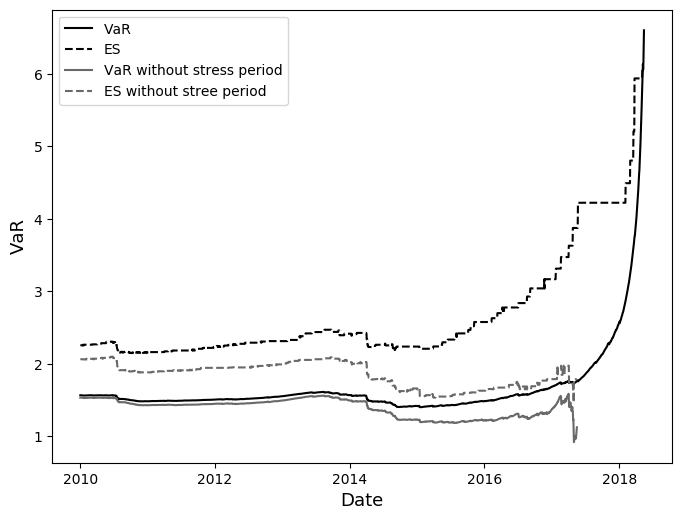

<IPython.core.display.Javascript object>

In [61]:
print("The values without corona (stress period) are lower")
plt.figure(figsize=(8, 6), dpi=100)
plt.plot(VaR_trend[::-1], label="VaR", color="k")
plt.plot(ES_trend[::-1], label="ES", color="k", ls="--")
plt.plot(VaR_trend_ex[::-1], label="VaR without stress period", color="#696969")
plt.plot(ES_trend_ex[::-1], label="ES without stree period", color="#696969", ls="--")
# plt.xticks(np.arange(8), (1, 2, 3, 4, 5, 6, 7, 8))
plt.xlabel("Date", fontsize=13)
plt.ylabel("VaR", fontsize=13)
locs, labels = plt.xticks()
x_ticks = []
new_xticks = [dates[i] for d in locs for i in range(5)]
plt.xticks(locs[1:-1], new_xticks)
plt.legend()

### 2. Student t-distribution

### Check student t-assumption with QQ-plots

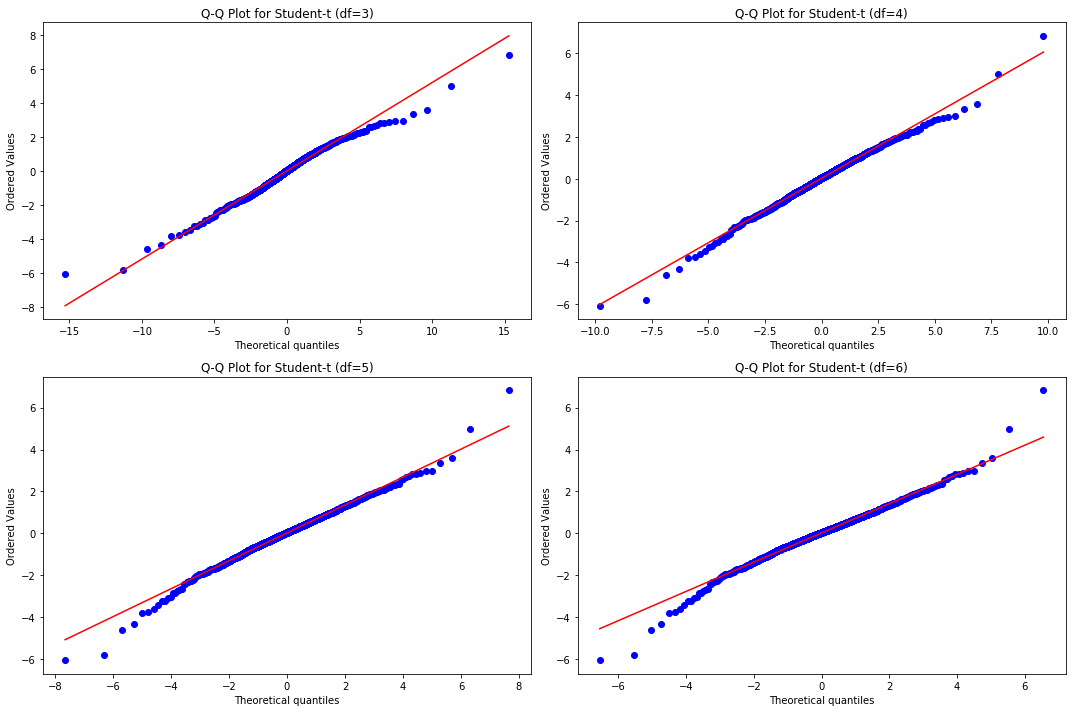

<IPython.core.display.Javascript object>

In [62]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
plt.subplot(2, 2, 1)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(3), plot=plt)
plt.title("Q-Q Plot for Student-t (df=3)")
plt.tight_layout()
plt.subplot(2, 2, 2)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(4), plot=plt)
plt.title("Q-Q Plot for Student-t (df=4)")
plt.tight_layout()
plt.subplot(2, 2, 3)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(5), plot=plt)
plt.title("Q-Q Plot for Student-t (df=5)")
plt.tight_layout()
plt.subplot(2, 2, 4)
sc.stats.probplot(data["portfolio_return"][1:], dist=sc.stats.t(6), plot=plt)
plt.title("Q-Q Plot for Student-t (df=6)")
plt.tight_layout()
plt.show()

In [28]:
def fnVaR_t(dfData, weights, lookback, df, alpha, percent, initial_investment):
    """
    purpose:
        calculates VaR and ES with variance-covariance method
        using a t-distribution
    input:
        dfData, dataframe
        weights, weights vector
        apha, significance value
        lookback, lookback period
        df, degrees of freedom
        percent, True= express in percent
    output:
        VaR expressed in losses (positive value)
    """
    # check alpha
    if alpha > 0.5:
        alpha = 1 - alpha

    # express years in days
    years = lookback
    # select last n years of data
    DataTemp = dfData.iloc[-years:, :-1]  # converted to days

    # calculate mean
    mean = np.array(np.mean(DataTemp)) @ weights.T
    mean = mean[0]

    # calculate covariance
    cov = np.cov(DataTemp, rowvar=False)
    # calculate variance
    variance = weights @ cov @ weights.T
    variance = (
        variance[0][0] * (df - 2) / df
    )  # account for variance of standard student-t

    # calculate quantile
    t = sc.stats.t.ppf(alpha, df)
    VaR = mean + t * np.sqrt(variance)
    VaR = -VaR

    # calculate ES
    mean_return = dfData["portfolio_return"][-years:]
    ES_list = [x for x in mean_return if x < -VaR]
    ES = -np.mean(ES_list)

    ##Prepare Output
    if percent[0] == True:
        print(
            "DF=", df,
        )

        print(
            "(",
            percent[1]*100,
            "%",
            " VaR, ES) in percent is: ",
            round(VaR, 2),
            "%",
            round(ES, 2),
            "%",
        )
    else:
        print(
            "(",
            percent[1]*100,
            "%",
            " VaR, ES) in monetary terms is: ",
            round(VaR * initial_investment, 2),
            round(ES * initial_investment, 2),
        )
    return VaR, ES

#### 2.1. Non-stressed Estimates

In [29]:
fnVaR_t(df_prices, weights, lookback, 3, 0.025, [True, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 3, 0.025, [False, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 3, 0.01, [True, 0.99], initial_investment)
fnVaR_t(df_prices, weights, lookback, 3, 0.01, [False, 0.99], initial_investment)

fnVaR_t(df_prices, weights, lookback, 4, 0.025, [True, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 4, 0.025, [False, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 4, 0.01, [True, 0.99], initial_investment)
fnVaR_t(df_prices, weights, lookback, 4, 0.01, [False, 0.99], initial_investment)

fnVaR_t(df_prices, weights, lookback, 5, 0.025, [True, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 5, 0.025, [False, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 5, 0.01, [True, 0.99], initial_investment)
fnVaR_t(df_prices, weights, lookback, 5, 0.01, [False, 0.99], initial_investment)

fnVaR_t(df_prices, weights, lookback, 6, 0.025, [True, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 6, 0.025, [False, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 6, 0.01, [True, 0.99], initial_investment)
fnVaR_t(df_prices, weights, lookback, 6, 0.01, [False, 0.99], initial_investment)

fnVaR_t(df_prices, weights, lookback, 1000, 0.025, [True, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 1000, 0.025, [False, 0.975], initial_investment)
fnVaR_t(df_prices, weights, lookback, 1000, 0.01, [True, 0.99], initial_investment)
fnVaR_t(df_prices, weights, lookback, 1000, 0.01, [False, 0.99], initial_investment)

DF= 3
( 97.5 %  VaR, ES) in percent is:  1.25 % 1.85 %
( 97.5 %  VaR, ES) in monetary terms is:  1247391.08 1846504.38
DF= 3
( 99.0 %  VaR, ES) in percent is:  1.79 % 2.67 %
( 99.0 %  VaR, ES) in monetary terms is:  1788534.53 2667324.62
DF= 4
( 97.5 %  VaR, ES) in percent is:  1.33 % 1.92 %
( 97.5 %  VaR, ES) in monetary terms is:  1334240.79 1924306.96
DF= 4
( 99.0 %  VaR, ES) in percent is:  1.81 % 2.71 %
( 99.0 %  VaR, ES) in monetary terms is:  1807798.36 2706717.66
DF= 5
( 97.5 %  VaR, ES) in percent is:  1.35 % 1.94 %
( 97.5 %  VaR, ES) in monetary terms is:  1353508.12 1942710.75
DF= 5
( 99.0 %  VaR, ES) in percent is:  1.78 % 2.67 %
( 99.0 %  VaR, ES) in monetary terms is:  1778105.93 2667324.62
DF= 6
( 97.5 %  VaR, ES) in percent is:  1.36 % 1.94 %
( 97.5 %  VaR, ES) in monetary terms is:  1358152.98 1942710.75
DF= 6
( 99.0 %  VaR, ES) in percent is:  1.75 % 2.63 %
( 99.0 %  VaR, ES) in monetary terms is:  1750168.18 2629441.22
DF= 1000
( 97.5 %  VaR, ES) in percent is:  1.33

(1.5857758918533065, 2.293745416881876)

In [59]:
''' 8 year '''
fnVaR_t(df_prices, weights, 2000, 3, 0.025, [True, 0.975], initial_investment)
fnVaR_t(df_prices, weights, 2000, 3, 0.025, [False, 0.975], initial_investment)
fnVaR_t(df_prices, weights, 2000, 3, 0.01, [True, 0.99], initial_investment)
fnVaR_t(df_prices, weights, 2000, 3, 0.01, [False, 0.99], initial_investment)

DF= 3
( 97.5 %  VaR, ES) in percent is:  2.51 % 4.21 %
( 97.5 %  VaR, ES) in monetary terms is:  25128.42 42108.88
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.61 % 5.64 %
( 99.0 %  VaR, ES) in monetary terms is:  36062.86 56431.94


(0.036062856724719886, 0.05643193911546341)

In [26]:
""" 5 year """
fnVaR_t(df_prices, weights, 1250, 3, 0.025, [True, 0.975], initial_investment)
fnVaR_t(df_prices, weights, 1250, 3, 0.025, [False, 0.975], initial_investment)
fnVaR_t(df_prices, weights, 1250, 3, 0.01, [True, 0.99], initial_investment)
fnVaR_t(df_prices, weights, 1250, 3, 0.01, [False, 0.99], initial_investment)

DF= 3
( 0.975 %  VaR, ES) in percent is:  1.26 % 1.97 %
( 0.975 %  VaR, ES) in monetary terms is:  1264029.3 1968125.85
DF= 3
( 0.99 %  VaR, ES) in percent is:  1.81 % 2.79 %
( 0.99 %  VaR, ES) in monetary terms is:  1812165.44 2788134.39


(1.812165441222499, 2.7881343900887647)

<IPython.core.display.Javascript object>

In [61]:
''' 1 year '''
fnVaR_t(df_prices, weights, 250, 3, 0.025, [True, 0.975], initial_investment)
fnVaR_t(df_prices, weights, 250, 3, 0.025, [False, 0.975], initial_investment)
fnVaR_t(df_prices, weights, 250, 3, 0.01, [True, 0.99], initial_investment)
fnVaR_t(df_prices, weights, 250, 3, 0.01, [False, 0.99], initial_investment)

DF= 3
( 97.5 %  VaR, ES) in percent is:  3.05 % 6.33 %
( 97.5 %  VaR, ES) in monetary terms is:  30467.41 63269.68
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.34 % 8.4 %
( 99.0 %  VaR, ES) in monetary terms is:  43428.19 84016.37


(0.04342818509185923, 0.08401636813980118)

#### 2.2 Stressed Estimates

In [85]:
for name, df in zip(df_name, df_list):
    print(name)
    #fnVaR_t(df, weights, lookback, 3, 0.025, [True, 0.975], initial_investment)
    #fnVaR_t(df, weights, lookback, 3, 0.025, [False, 0.975], initial_investment)
    fnVaR_t(df, weights, lookback, 3, 0.01, [True, 0.99], initial_investment)
    fnVaR_t(df, weights, lookback, 3, 0.01, [False, 0.99], initial_investment)

df_prices_plus20
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.02 % 6.01 %
( 99.0 %  VaR, ES) in monetary terms is:  40243.83 60084.47
df_prices_plus40
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.14 % 6.36 %
( 99.0 %  VaR, ES) in monetary terms is:  41396.61 63558.14
df_prices_minus20
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.04 % 6.33 %
( 99.0 %  VaR, ES) in monetary terms is:  40425.07 63327.75
df_prices_minus40
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.33 % 7.5 %
( 99.0 %  VaR, ES) in monetary terms is:  43317.07 74998.7
df_prices_complus20
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.98 % 5.95 %
( 99.0 %  VaR, ES) in monetary terms is:  39799.63 59495.14
df_prices_complus40
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.99 % 5.95 %
( 99.0 %  VaR, ES) in monetary terms is:  39935.92 59495.14
df_prices_comminus20
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.98 % 5.95 %
( 99.0 %  VaR, ES) in monetary terms is:  39806.84 59495.14
df_prices_comminus40
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.01

In [86]:
for name, df in zip(df_name, df_list):
    print(name)
    #fnVaR_t(df, weights, lookback, 3, 0.025, [True, 0.975], initial_investment)
    #fnVaR_t(df, weights, lookback, 3, 0.025, [False, 0.975], initial_investment)
    fnVaR_t(df, weights, 500, 3, 0.01, [True, 0.99], initial_investment)
    fnVaR_t(df, weights, 500, 3, 0.01, [False, 0.99], initial_investment)

df_prices_plus20
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.87 % 6.97 %
( 99.0 %  VaR, ES) in monetary terms is:  38672.39 69731.22
df_prices_plus40
DF= 3
( 99.0 %  VaR, ES) in percent is:  4.36 % 8.4 %
( 99.0 %  VaR, ES) in monetary terms is:  43600.77 84016.37
df_prices_minus20
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.94 % 7.76 %
( 99.0 %  VaR, ES) in monetary terms is:  39374.66 77552.68
df_prices_minus40
DF= 3
( 99.0 %  VaR, ES) in percent is:  5.1 % 14.59 %
( 99.0 %  VaR, ES) in monetary terms is:  50964.57 145949.37
df_prices_complus20
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.66 % 6.97 %
( 99.0 %  VaR, ES) in monetary terms is:  36605.54 69731.22
df_prices_complus40
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.73 % 6.97 %
( 99.0 %  VaR, ES) in monetary terms is:  37255.41 69731.22
df_prices_comminus20
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.66 % 6.97 %
( 99.0 %  VaR, ES) in monetary terms is:  36593.46 69731.22
df_prices_comminus40
DF= 3
( 99.0 %  VaR, ES) in percent is:  3.

### 3. Historical simulation method

In [26]:
def fnVaR_hist(dfData, weights, alpha, lookback, percent, initial_investment):
    """
    purpose:
        calculates VaR and ES with historical simulation
    input:
        dfData, dataframe
        weights, weights vector
        apha, significance value
        lookback, lookback period
        df, degrees of freedom
        percent, True= express in percent
    output:
        VaR expressed in losses (positive value)
    """
    # check alpha
    if alpha > 0.5:
        alpha = 1 - alpha

    # because the percentile function takes alpha=e[0,100]
    alpha = alpha * 100

    
    # express years in days
    years= lookback
    
    # select last n years of data
    DataTemp= dfData.iloc[-years:,-1]
    
    # calculate quantile
    VaR= sc.percentile(DataTemp, alpha)
    VaR= -VaR


    
    ES_list = [x for x in DataTemp if x < -VaR]
    ES = -np.mean(ES_list)

    ##Prepare Output
    if percent[0] == True:
        print(
            "(",
            percent[1]*100 ,
            "%",
            " VaR, ES) in percent is: ",
            round(VaR , 2),
            "%",
            round(ES , 2),
            "%",
        )
    else:
        print(
            "(",
            percent[1]*100 ,
            "%",
            " VaR, ES) in monetary terms is: ",
            round(VaR * initial_investment, 2),
            round(ES * initial_investment, 2),
        )
    return VaR, ES


#### 3.1. Non-stressed Estimates

In [27]:
fnVaR_hist(df_prices, weights, 0.025, lookback, [True, 0.975], initial_investment)
fnVaR_hist(df_prices, weights, 0.025, lookback, [False, 0.975], initial_investment)
fnVaR_hist(df_prices, weights, 0.01, lookback, [True, 0.99], initial_investment)
fnVaR_hist(df_prices, weights, 0.01, lookback, [False, 0.99], initial_investment)

( 97.5 %  VaR, ES) in percent is:  1.4 % 1.99 %
( 97.5 %  VaR, ES) in monetary terms is:  1396621.13 1991054.75
( 99.0 %  VaR, ES) in percent is:  1.77 % 2.67 %
( 99.0 %  VaR, ES) in monetary terms is:  1765357.29 2667324.62


(1.7653572946400742, 2.6673246240083017)

In [53]:
""" 10 year """
fnVaR_hist(df_prices, weights, 0.025, 2500, [True, 0.975], initial_investment)
fnVaR_hist(df_prices, weights, 0.025, 2500, [False, 0.975], initial_investment)
fnVaR_hist(df_prices, weights, 0.01, 2500, [True, 0.99], initial_investment)
fnVaR_hist(df_prices, weights, 0.01, 2500, [False, 0.99], initial_investment)

( 97.5 %  VaR, ES) in percent is:  1.4 % 1.99 %
( 97.5 %  VaR, ES) in monetary terms is:  1396621.13 1991054.75
( 99.0 %  VaR, ES) in percent is:  1.77 % 2.67 %
( 99.0 %  VaR, ES) in monetary terms is:  1765357.29 2667324.62


(1.7653572946400742, 2.6673246240083017)

In [54]:
""" 5 year """
fnVaR_hist(df_prices, weights, 0.025, 1250, [True, 0.975], initial_investment)
fnVaR_hist(df_prices, weights, 0.025, 1250, [False, 0.975], initial_investment)
fnVaR_hist(df_prices, weights, 0.01, 1250, [True, 0.99], initial_investment)
fnVaR_hist(df_prices, weights, 0.01, 1250, [False, 0.99], initial_investment)

( 97.5 %  VaR, ES) in percent is:  1.38 % 2.04 %
( 97.5 %  VaR, ES) in monetary terms is:  1380255.41 2037577.56
( 99.0 %  VaR, ES) in percent is:  1.75 % 2.75 %
( 99.0 %  VaR, ES) in monetary terms is:  1751377.82 2749894.26


(1.7513778173943932, 2.7498942645787423)

In [232]:
""" 1 year """
fnVaR_hist(df_prices, weights, 0.025, 250, [True, 0.975], initial_investment)
fnVaR_hist(df_prices, weights, 0.025, 250, [False, 0.975], initial_investment)
fnVaR_hist(df_prices, weights, 0.01, 250, [True, 0.99], initial_investment)
fnVaR_hist(df_prices, weights, 0.01, 250, [False, 0.99], initial_investment)

( 0.975 %  VaR, ES) in percent is:  1.68 % 3.86 %
( 0.975 %  VaR, ES) in monetary terms is:  1680608.68 3862330.28
( 0.99 %  VaR, ES) in percent is:  3.67 % 5.21 %
( 0.99 %  VaR, ES) in monetary terms is:  3670921.87 5205786.06


(3.670921873214297, 5.205786059516698)

<IPython.core.display.Javascript object>

#### 3.2. Stressed Estimates

In [233]:
for name, df in zip(df_name, df_list):
    print(name)
    fnVaR_hist(df, weights, 0.025, lookback, [True, 0.975], initial_investment)
    fnVaR_hist(df, weights, 0.025, lookback, [False, 0.975], initial_investment)
    fnVaR_hist(df, weights, 0.01, lookback, [True, 0.99], initial_investment)
    fnVaR_hist(df, weights, 0.01, lookback, [False, 0.99], initial_investment)

NameError: name 'df_name' is not defined

<IPython.core.display.Javascript object>

### 4.Filtered historical simulation using EWMA

In [19]:
""" Filtered historical simulation using EWMA """
# returns = data[['DE_1YBOND_return',"BTC_return", "DBC_return", "GSPC_return", "N225_return"]]
def fnVaR_FilterEWMA(
    dfData, weights, ewma_con, alpha, lookback, percent, initial_investment
):
    returns = dfData
    # print(returns.shape)

    if lookback == 500:
        tVar = np.zeros((lookback // 250 * 250 + 100 + 1, 4))
        alpha = alpha * 100
        ##calculate variance at day-100 using the previous days
        for i in range(4):
            tVar[0, i] = abs(returns.iloc[-(lookback // 250 * 250 + 101), i])

        # calculate first 100 days volatility
        for i in range(4):
            for j in range(100):
                tVar[1 + j, i] = (
                    ewma_con * tVar[1 + j - 1, i]
                    + (1 - ewma_con)
                    * returns.iloc[-(lookback // 250 * 250 + 100) + j - 1, i] ** 2
                )
        # print(tVar)
        Z_matrix = np.zeros((500, 4))
        R_matrix = np.zeros((500, 4))
        VaR_all = np.zeros(4)
        ES_all = np.zeros(4)
        # calculate first 500 days Z values and use them to approximate the VaR and ES on the 501th day
        for i in range(4):
            for j in range(500):
                tVar[101 + j, i] = (
                    ewma_con * tVar[101 + j - 1, i]
                    + (1 - ewma_con)
                    * returns.iloc[-(lookback // 250 * 250) + j - 1, i] ** 2
                )
                Z_matrix[j, i] = returns.iloc[
                    -(lookback // 250 * 250 + 100) + j, i
                ] / sc.sqrt(tVar[101 + j, i])
                new_sigma = sc.sqrt(
                    ewma_con * tVar[101 + j, i]
                    + (1 - ewma_con)
                    * returns.iloc[-(lookback // 250 * 250) + j, i] ** 2
                )
            R_matrix[:, i] = Z_matrix[:, i] * new_sigma
    else:
        """We normally use 500 loockback interval, so if the lookback is not 500 days,
        I used the whole lookback period to calculate Z and R, then take the 5% largest lost
        as the VaR, let me know if it's not right to you."""
        returns = dfData.iloc[-lookback:, :]
        alpha = alpha * 100

        vVariances = np.zeros((len(returns), 4))
        # initialize variance
        for i in range(4):
            # take the first return as the long-turn variance
            vVariances[0, i] = abs(returns.iloc[0, i])
        # calculate EWMA
        for i in range(1, len(returns)):
            for j in range(4):
                sigma2hat = ewma_con * vVariances[i - 1, j] + (1 - ewma_con) * (
                    returns.iloc[i - 1, j] ** 2
                )
                vVariances[i, j] = sigma2hat
        Z_matrix = np.zeros((len(returns), 4))
        R_matrix = np.zeros((len(returns), 4))
        VaR_all = np.zeros(4)
        ES_all = np.zeros(4)
        # calculate first 500 days Z values and use them to approximate the VaR and ES on the 501th day
        for i in range(4):
            new_sigma = sc.sqrt(
                ewma_con * vVariances[-1, i] + (1 - ewma_con) * returns.iloc[-1, i] ** 2
            )
            Z_matrix[:, i] = returns.iloc[:, i] / sc.sqrt(vVariances[:, i])
            R_matrix[:, i] = Z_matrix[:, i] * new_sigma
            # print(new_sigma)
    # print(vVariances[ :10, 1])
    # print(Z_matrix[:10,1])
    for i in range(4):
        # print(new_sigma)
        VaR_all[i] = -np.percentile(R_matrix[:, i], alpha)
        ES_list = [x for x in R_matrix[:, i] if x < -VaR_all[i]]
        ES_all[i] = -np.mean(ES_list)
    # print(VaR_all)
    VaR = (VaR_all @ weights.T)[0]
    ES = (ES_all @ weights.T)[0]

    if percent[0] == True:
        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in percent is: ",
            round(VaR, 2),
            "%",
            round(ES, 2),
            "%",
        )
    else:
        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in monetary terms is: ",
            round(VaR * initial_investment, 2),
            round(ES * initial_investment, 2),
        )
    return VaR, ES

In [20]:
df_prices

SP500     STOXX  Treas10Y  CrudeOil  portfolio_return
0    -0.189486 -0.282542  1.444940 -0.711718          0.317626
1     0.242054 -0.871208 -0.403221 -0.667007         -0.451979
2    -0.374723  1.291011 -0.947138 -1.592828         -0.468349
3    -0.525300 -0.140978 -0.274654 -1.387146         -0.553860
4    -0.023975 -0.249041  0.265914 -0.436922         -0.049273
...        ...       ...       ...       ...               ...
2279  8.313829  8.070359 -1.169217 -0.246337          3.579093
2280  0.794278  3.038883 -0.767473 -1.335026          0.384296
2281  5.252862  2.520771 -0.330262 -6.123724          0.586559
2282 -4.873531 -3.315294 -0.826188 -6.839004         -3.745482
2283 -0.634357  1.631684  0.703594 -0.001482          0.530473

[2284 rows x 5 columns]

In [24]:
weights

array([[0.25, 0.25, 0.4 , 0.2 ]])

#### 4.1. Non-stressed Estimates

In [23]:
"""For EWMA, because we calculate all seven variance and then add all five assests together,
 that why I set another new weights. Because Nikkei and Bond are one asset so they both should
only have one total VaR considering FX together. I already add two returns together in the function.
Let me know if you agree with it. :)"""


# weights2 = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
fnVaR_FilterEWMA(
    df_prices, weights, 0.97, 0.025, lookback, [True, 0.975], initial_investment
)
fnVaR_FilterEWMA(
    df_prices, weights, 0.97, 0.025, lookback, [False, 0.975], initial_investment
)
fnVaR_FilterEWMA(
    df_prices, weights, 0.97, 0.01, lookback, [True, 0.99], initial_investment
)
fnVaR_FilterEWMA(
    df_prices, weights, 0.97, 0.01, lookback, [False, 0.99], initial_investment
)

( 97.5 %  VaR, ES) in percent is:  7.81 % 10.86 %
( 97.5 %  VaR, ES) in monetary terms is:  7809768.39 10861758.51
( 99.0 %  VaR, ES) in percent is:  10.29 % 13.98 %
( 99.0 %  VaR, ES) in monetary terms is:  10289810.53 13982374.55


(10.28981052663492, 13.982374552006512)

In [71]:
''' 8 year VaR,ES'''
fnVaR_FilterEWMA(
    df_prices, weights, 0.94, 0.025, 2000, [True, 0.975], initial_investment
)
fnVaR_FilterEWMA(
    df_prices, weights, 0.94, 0.025, 2000, [False, 0.975], initial_investment
)
fnVaR_FilterEWMA(
    df_prices, weights, 0.94, 0.01, 2000, [True, 0.99], initial_investment
)
fnVaR_FilterEWMA(
    df_prices, weights, 0.94, 0.01, 2000, [False, 0.99], initial_investment
)

( 97.5 %  VaR, ES) in percent is:  7.47 % 10.99 %
( 97.5 %  VaR, ES) in monetary terms is:  74693.46 109887.12
( 99.0 %  VaR, ES) in percent is:  11.06 % 14.53 %
( 99.0 %  VaR, ES) in monetary terms is:  110585.34 145294.19


(0.11058534283796619, 0.14529418821140577)

In [72]:
''' 5 year VaR,ES'''
fnVaR_FilterEWMA(
    df_prices, weights, 0.94, 0.025, 1250, [True, 0.975], initial_investment
)
fnVaR_FilterEWMA(
    df_prices, weights, 0.94, 0.025, 1250, [False, 0.975], initial_investment
)
fnVaR_FilterEWMA(
    df_prices, weights, 0.94, 0.01, 1250, [True, 0.99], initial_investment
)
fnVaR_FilterEWMA(
    df_prices, weights, 0.94, 0.01, 1250, [False, 0.99], initial_investment
)

( 97.5 %  VaR, ES) in percent is:  6.78 % 11.2 %
( 97.5 %  VaR, ES) in monetary terms is:  67825.98 112011.41
( 99.0 %  VaR, ES) in percent is:  10.21 % 15.72 %
( 99.0 %  VaR, ES) in monetary terms is:  102133.16 157220.51


(0.10213316110675465, 0.1572205090501107)

In [20]:
df_prices

SP500     STOXX  Treas10Y  CrudeOil  portfolio_return
0    -0.189486 -0.282542  1.444940 -0.711718          0.388797
1     0.242054 -0.871208 -0.403221 -0.667007         -0.385278
2    -0.374723  1.291011 -0.947138 -1.592828         -0.309066
3    -0.525300 -0.140978 -0.274654 -1.387146         -0.415146
4    -0.023975 -0.249041  0.265914 -0.436922         -0.005581
...        ...       ...       ...       ...               ...
2279  8.313829  8.070359 -1.169217 -0.246337          3.603726
2280  0.794278  3.038883 -0.767473 -1.335026          0.517799
2281  5.252862  2.520771 -0.330262 -6.123724          1.198931
2282 -4.873531 -3.315294 -0.826188 -6.839004         -3.061582
2283 -0.634357  1.631684  0.703594 -0.001482          0.530621

[2284 rows x 5 columns]

#### 4.2. Stressed Estimates

In [75]:
for name, df in zip(df_name, df_list):
    print(name)
    #fnVaR_FilterEWMA(df, weights, 0.94, 0.025, lookback, [True, 0.975], initial_investment)
    #fnVaR_FilterEWMA(df, weights, 0.94, 0.025, lookback, [False, 0.975], initial_investment)
    fnVaR_FilterEWMA(df, weights, 0.94, 0.01, lookback, [True, 0.99], initial_investment)
    fnVaR_FilterEWMA(df, weights, 0.94, 0.01, lookback, [False, 0.99], initial_investment)

df_prices_plus20
( 99.0 %  VaR, ES) in percent is:  11.06 % 14.53 %
( 99.0 %  VaR, ES) in monetary terms is:  110585.34 145294.19
df_prices_plus40
( 99.0 %  VaR, ES) in percent is:  11.06 % 14.53 %
( 99.0 %  VaR, ES) in monetary terms is:  110585.34 145294.19
df_prices_minus20
( 99.0 %  VaR, ES) in percent is:  11.06 % 14.53 %
( 99.0 %  VaR, ES) in monetary terms is:  110585.34 145294.19
df_prices_minus40
( 99.0 %  VaR, ES) in percent is:  11.06 % 14.53 %
( 99.0 %  VaR, ES) in monetary terms is:  110585.34 145294.19
df_prices_complus20
( 99.0 %  VaR, ES) in percent is:  11.06 % 14.53 %
( 99.0 %  VaR, ES) in monetary terms is:  110585.34 145294.19
df_prices_complus40
( 99.0 %  VaR, ES) in percent is:  11.06 % 14.53 %
( 99.0 %  VaR, ES) in monetary terms is:  110585.34 145294.19
df_prices_comminus20
( 99.0 %  VaR, ES) in percent is:  11.06 % 14.53 %
( 99.0 %  VaR, ES) in monetary terms is:  110585.34 145294.19
df_prices_comminus40
( 99.0 %  VaR, ES) in percent is:  11.06 % 14.53 %
( 99.0

In [76]:
for name, df in zip(df_name, df_list):
    print(name)
    #fnVaR_FilterEWMA(df, weights, 0.94, 0.025, lookback, [True, 0.975], initial_investment)
    #fnVaR_FilterEWMA(df, weights, 0.94, 0.025, lookback, [False, 0.975], initial_investment)
    fnVaR_FilterEWMA(df, weights, 0.94, 0.01, 500, [True, 0.99], initial_investment)
    fnVaR_FilterEWMA(df, weights, 0.94, 0.01, 500, [False, 0.99], initial_investment)

df_prices_plus20
( 99.0 %  VaR, ES) in percent is:  26.55 % 32.64 %
( 99.0 %  VaR, ES) in monetary terms is:  265475.94 326419.58
df_prices_plus40
( 99.0 %  VaR, ES) in percent is:  33.51 % 41.22 %
( 99.0 %  VaR, ES) in monetary terms is:  335068.72 412240.72
df_prices_minus20
( 99.0 %  VaR, ES) in percent is:  27.62 % 33.99 %
( 99.0 %  VaR, ES) in monetary terms is:  276217.48 339893.62
df_prices_minus40
( 99.0 %  VaR, ES) in percent is:  42.05 % 51.74 %
( 99.0 %  VaR, ES) in monetary terms is:  420509.58 517410.65
df_prices_complus20
( 99.0 %  VaR, ES) in percent is:  24.34 % 29.9 %
( 99.0 %  VaR, ES) in monetary terms is:  243394.66 298971.75
df_prices_complus40
( 99.0 %  VaR, ES) in percent is:  26.96 % 33.13 %
( 99.0 %  VaR, ES) in monetary terms is:  269642.92 331267.68
df_prices_comminus20
( 99.0 %  VaR, ES) in percent is:  25.1 % 30.83 %
( 99.0 %  VaR, ES) in monetary terms is:  250986.23 308312.44
df_prices_comminus40
( 99.0 %  VaR, ES) in percent is:  30.17 % 37.07 %
( 99.0 %

### 5. GARCH(1,1) with constant correlation matrix

In [21]:
from scipy.optimize import minimize


def fGarchFilter(vData, dOmega, dAlpha, dBeta, dSigma2):

    # initialize sizes and formats
    iT = vData.shape[0]
    vVariances = np.zeros(iT)
    vLikelihoodValues = np.ones(iT)

    # filter variances and compute likelihood contributions by
    # a loop over the observations
    for i1 in range(iT):

        # update filtered variances
        vVariances[i1] = dSigma2

        # compute the likelihood contribution
        vLikelihoodValues[i1] = (
            -0.5 * np.log(dSigma2) - 0.5 * vData.iloc[i1] * vData.iloc[i1] / dSigma2
        )

        # update the filter
        dSigma2 = dOmega + dBeta * dSigma2 + dAlpha * vData.iloc[i1] * vData.iloc[i1]

    # add likelihood constants
    vLikelihoodValues = vLikelihoodValues - 0.5 * np.log(2 * np.pi)

    # return filtered variances and likelihood values
    return (vVariances, vLikelihoodValues)


class cMaximizeLikelihood:
    def __init__(self):
        self.x0 = []
        self.x = []
        self.tx0 = []
        self.tx = []
        self.likelihoodvalue = []
        self.tcovariancematrix = []
        self.covariancematrix = []
        self.filter = []
        self.success = False


def fMaximizeLikelihood(vData):

    cReturnValue = cMaximizeLikelihood()

    def LOCAL_fParameterTransform(vTheta, bShapeAsVector=False):
        r = ((np.exp(vTheta[0])), (np.exp(vTheta[1])), (1 / (1 + np.exp(-vTheta[2]))))
        if bShapeAsVector == True:
            return np.append([], r)
        else:
            return r

    def LOCAL_fObjective(vTheta, bForAllT=False):
        # initialize the parameter values
        dOmega, dAlpha, dBeta = LOCAL_fParameterTransform(vTheta)
        dSigma2 = np.var(vData)

        # run the filter
        vVariances, vLikelihoodValues = fGarchFilter(
            vData, dOmega, dAlpha, dBeta, dSigma2
        )
        cReturnValue.filter = vVariances
        if bForAllT == True:
            dObjValue = vLikelihoodValues
        else:
            dObjValue = -np.mean(vLikelihoodValues)

        return dObjValue

    # initialize starting values and return value
    vTheta = np.log([1, 0.05, 0.93])
    vTheta[0] = np.log(np.var(vData) * (1 - 0.98))
    cReturnValue.x0 = vTheta
    cReturnValue.tx0 = LOCAL_fParameterTransform(vTheta)

    # do the optimization
    tSol = minimize(
        LOCAL_fObjective,
        vTheta,
        method="BFGS",#Nelder-Mead
        options={"disp": True, "maxiter": 100,"gtol": 1e-7 * len(vData)},
    )
    cReturnValue.success = tSol["success"]
    # check for success and store results
    if tSol["success"] != True:
        print("*** no true convergence: ", tSol["message"])
    else:
        cReturnValue.x = tSol["x"]
        cReturnValue.tx = LOCAL_fParameterTransform(cReturnValue.x)
        cReturnValue.likelihoodvalue = -vData.shape[0] * tSol["fun"]

    return cReturnValue

In [22]:
def fnVaR_GARCH(dfData, weights, alpha, lookback, percent,initial_investment,para=None,Variances = None,rec=True):
    """
    purpose:
        calculates VaR and ES with GARCH method
        using a normal distribution
    input:
        dfData, dataframe
        weights, weights vector
        apha, significance value
        lookback, lookback period
        percent, True= express in percent
    output:
        VaR expressed in losses (positive value)
    """
    # check alpha
    if alpha > 0.5:
        alpha= 1-alpha
    
    # express years in days
    years= lookback
    # select last n years of data
    DataTemp= dfData.iloc[-years:,:-1]
    # calculate covariance using the 500 days before the beginning day
    corr =  DataTemp.iloc[-years:,:].corr()
    #cov= np.cov(DataTemp.iloc[1:,:], rowvar= False)    
    # estimate a GARCH(1,1) model and store the one step ahead
    # forecasts in a vector
    vVariances= np.zeros(4)
    # don't recalculate
    if rec == False:
        for i in range(4):
            dOmega, dAlpha, dBeta= para[i][0],para[i][1],para[i][2]
            sigma2hat= dOmega + dAlpha*DataTemp.iloc[-1,i]**2+dBeta*Variances[i]
            vVariances[i]= sigma2hat
        
   
    #recalculate
    else:
        para = []
        for i in range(4):
            out = fMaximizeLikelihood(DataTemp.iloc[:,i])
            dOmega, dAlpha, dBeta= out.tx
            sigma2hat= dOmega + dAlpha*DataTemp.iloc[-1,i]**2+dBeta*out.filter[-1]
            vVariances[i]= sigma2hat
            para.append([dOmega, dAlpha, dBeta])
    #print(vVariances)     
    # fill diagonal elements of covariance matrix with GARCH estimates
    sigmamatrix = np.zeros((4, 4))
    np.fill_diagonal(sigmamatrix, np.sqrt(vVariances))
    cov = np.matmul(np.matmul(sigmamatrix,corr),sigmamatrix)
    #np.fill_diagonal(cov, vVariances)
    # calculate the variance
    variance= weights@cov@weights.T
    variance= variance[0][0]
    # calculate mean
    mean= np.array(np.mean(DataTemp))@weights.T
    mean= mean[0]
    # calculate quantile
    z= sc.stats.norm.ppf(alpha)
    VaR= mean + z * np.sqrt(variance)
    VaR= -VaR
    # calculate ES
    mean_return = dfData["portfolio_return"][-years :]
    ES_list = [x for x in mean_return if x < -VaR]
    ES= -np.mean(ES_list)
    if percent[0] == True:
        print(
            "(",
            percent[1]* 100,
            "%",
            " VaR, ES) in percent is: ",
            round(VaR , 2),
            "%",
            round(ES , 2),
            "%", 
        )
    else:
        print(
            "(",
            percent[1] * 100,
            "%",
            " VaR, ES) in monetary terms is: ",
            round(VaR/100 * initial_investment, 2),
            round(ES/100 * initial_investment, 2),)
    return VaR, ES, para,vVariances

#### 5.1 Non-stress tesing

In [42]:
''' All period Var, ES'''
fnVaR_GARCH(df_prices,weights, 0.025, lookback, [True,0.975],initial_investment,para=None,Variances = None,rec=True)
fnVaR_GARCH(df_prices,weights, 0.025, lookback, [False,0.975],initial_investment,para=None,Variances = None,rec=True)
fnVaR_GARCH(df_prices,weights, 0.01, lookback, [True,0.99],initial_investment,para=None,Variances = None,rec=True)
fnVaR_GARCH(df_prices,weights, 0.01, lookback, [False,0.99],initial_investment,para=None,Variances = None,rec=True)

Optimization terminated successfully.
         Current function value: 1.427306
         Iterations: 21
         Function evaluations: 110
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 1.319265
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 1.107154
         Iterations: 25
         Function evaluations: 130
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 2.112411
         Iterations: 24
         Function evaluations: 125
         Gradient evaluations: 25
( 97.5 %  VaR, ES) in percent is:  6.31 % nan %


/home/isualice/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/isualice/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Optimization terminated successfully.
         Current function value: 1.427306
         Iterations: 21
         Function evaluations: 110
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 1.319265
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: 1.107154
         Iterations: 25
         Function evaluations: 130
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: 2.112411
         Iterations: 24
         Function evaluations: 125
         Gradient evaluations: 25
( 97.5 %  VaR, ES) in monetary terms is:  63148.66 nan
Optimization terminated successfully.
         Current function value: 1.427306
         Iterations: 21
         Function evaluations: 110
         Gradient evaluations: 22
Optimization terminated successfully.
         Current function value: 1.319265


(7.4988824339953615,
 nan,
 [[0.07482862554283967, 0.14062720194547343, 0.7987242399488389],
  [0.02498195986510989, 0.1389801184087243, 0.8457606344493874],
  [0.005405608636165707, 0.046239546674561496, 0.9454594198740172],
  [0.06675385677071352, 0.12107428011492997, 0.8813807351906991]],
 array([ 14.74387255,  13.83466346,   1.68340475, 119.94858828]))

#### 5.2 Stress testing

In [80]:
for name, df in zip(df_name, df_list):
    print(name)
    #fnVaR_GARCH(df_prices,weights, 0.025, lookback, [True,0.975],initial_investment,para=None,Variances = None,rec=True)
    #fnVaR_GARCH(df_prices,weights, 0.025, lookback, [False,0.975],initial_investment,para=None,Variances = None,rec=True)
    fnVaR_GARCH(df_prices,weights, 0.01, lookback, [True,0.99],initial_investment,para=None,Variances = None,rec=True)
    #fnVaR_GARCH(df_prices,weights, 0.01, lookback, [False,0.99],initial_investment,para=None,Variances = None,rec=True)

df_prices_plus20
Optimization terminated successfully.
         Current function value: -2.512991
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -1.537345
         Iterations: 19
         Function evaluations: 100
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -3.213974
         Iterations: 26
         Function evaluations: 135
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: -3.365280
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -2.991514
         Iterations: 22
         Function evaluations: 115
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: -3.815467
         Iterations: 24
        

Optimization terminated successfully.
         Current function value: -3.365280
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -2.991514
         Iterations: 22
         Function evaluations: 115
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: -3.815467
         Iterations: 24
         Function evaluations: 130
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function value: -3.746782
         Iterations: 23
         Function evaluations: 120
         Gradient evaluations: 24
( 99.0 %  VaR, ES) in percent is:  6.27 % 8.21 %
df_prices_comminus40
Optimization terminated successfully.
         Current function value: -2.512991
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current funct

Optimization terminated successfully.
         Current function value: -3.746782
         Iterations: 23
         Function evaluations: 120
         Gradient evaluations: 24
( 99.0 %  VaR, ES) in percent is:  6.27 % 8.21 %
df_prices_FXminus10
Optimization terminated successfully.
         Current function value: -2.512991
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current function value: -1.537345
         Iterations: 19
         Function evaluations: 100
         Gradient evaluations: 20
Optimization terminated successfully.
         Current function value: -3.213974
         Iterations: 26
         Function evaluations: 135
         Gradient evaluations: 27
Optimization terminated successfully.
         Current function value: -3.365280
         Iterations: 20
         Function evaluations: 105
         Gradient evaluations: 21
Optimization terminated successfully.
         Current functi

### Backtesting all five methods

In [23]:
df_prices = df_prices.set_index(pd.to_datetime(data["Date"]))

In [24]:
df_prices

SP500     STOXX  Treas10Y  CrudeOil  portfolio_return
Date                                                                
2010-04-07 -0.189486 -0.282542  1.444940 -0.711718          0.388797
2010-04-08  0.242054 -0.871208 -0.403221 -0.667007         -0.385278
2010-04-09 -0.374723  1.291011 -0.947138 -1.592828         -0.309066
2010-04-12 -0.525300 -0.140978 -0.274654 -1.387146         -0.415146
2010-04-13 -0.023975 -0.249041  0.265914 -0.436922         -0.005581
...              ...       ...       ...       ...               ...
2020-03-24  8.313829  8.070359 -1.169217 -0.246337          3.603726
2020-03-25  0.794278  3.038883 -0.767473 -1.335026          0.517799
2020-03-26  5.252862  2.520771 -0.330262 -6.123724          1.198931
2020-03-27 -4.873531 -3.315294 -0.826188 -6.839004         -3.061582
2020-03-31 -0.634357  1.631684  0.703594 -0.001482          0.530621

[2284 rows x 5 columns]

In [25]:
def fnRollingVaR(dfData,weights,alpha, lookback, sm_const, df,percent=[True,0.975],para = None,Varaicnes=None, rec = True):
    '''
    purpose:
        calculate VaR with a rolling window
    input:
        dfData, dataframe of risk factors
        weights, portfolio weights
        alpha, significance level
        lookback, lookback period
        sm_const, smoothing constant for EWMA
        df, degrees of freedom for t-distribution
    output
        dfVaR, dataframe of VaR for every day
    '''
    windowsize= lookback+101
    N= len(dfData)-windowsize
    dfVaR= pd.DataFrame(np.zeros((N,10)))
    dfVaR.index = dfData.index[windowsize:]
    dfVaR.columns= ["VaR_n", "ES_n", "VaR_t", "ES_t", "VaR_hist", "ES_hist",\
                    "VaR_FilterEWMA","ES_FilterEWMA","VaR_GARCH","ES_GARCH"]
    # VaR and ES for 1 year lookback
    paras = []
    vVariances = []
    normal_all = []
    studentt_all = []
    hist_all =[]
    for i in range(N):
        # calculate rolling window
        DataTemp= dfData.iloc[0+i:windowsize+i,:]
        
        # calculate VaR
        #dfVaR.iloc[i,0], dfVaR.iloc[i,1]= fnVaR_n(DataTemp, weights, alpha, lookback,percent,initial_investment )
        #dfVaR.iloc[i,2], dfVaR.iloc[i,3]= fnVaR_t(DataTemp, weights,lookback,df, alpha, percent,initial_investment)
        
        dfVaR.iloc[i,6], dfVaR.iloc[i,7]= fnVaR_FilterEWMA(DataTemp, weights,sm_const, alpha, lookback, percent,initial_investment)
        if i%250==0:
            normal = fnVaR_n(DataTemp, weights, alpha, lookback,percent,initial_investment )
            dfVaR.iloc[i,0], dfVaR.iloc[i,1]= normal[0],normal[1]
            normal_all.append([normal[0],normal[1]])
            studentt = fnVaR_t(DataTemp, weights,lookback,df, alpha, percent,initial_investment)
            dfVaR.iloc[i,2], dfVaR.iloc[i,3]= studentt[0],studentt[1]
            studentt_all.append([studentt[0],studentt[1]])
            hist = fnVaR_hist(DataTemp, weights, alpha, lookback, percent,initial_investment)
            dfVaR.iloc[i,4], dfVaR.iloc[i,5]= hist[0],hist[1]
            hist_all.append([hist[0],hist[1]])
            
            garch = fnVaR_GARCH(DataTemp, weights, alpha, lookback, percent,initial_investment,para=None,Variances=None,rec=True)
            dfVaR.iloc[i,8], dfVaR.iloc[i,9]= garch[0],garch[1]
            paras.append(garch[2])
            vVariances.append(garch[3])
        else:
            dfVaR.iloc[i,0], dfVaR.iloc[i,1]= normal_all[i//250][0],normal_all[i//250][1]
            dfVaR.iloc[i,2], dfVaR.iloc[i,3]= studentt_all[i//250][0],studentt_all[i//250][1]
            dfVaR.iloc[i,4], dfVaR.iloc[i,5]= hist_all[i//250][0],hist_all[i//250][1]
            garch = fnVaR_GARCH(DataTemp, weights, alpha, lookback, percent,initial_investment,para=paras[i//250],Variances = vVariances[i-1],rec=False)
            dfVaR.iloc[i,8], dfVaR.iloc[i,9]= garch[0],garch[1]
            vVariances.append(garch[3])
            

    return dfVaR


In [32]:
df = fnRollingVaR(df_prices,weights, 0.01, 500, 0.97, 4, percent=[True, 0.99],para=None,rec=True)
#df.to_csv("01_Data/df_99.csv", index_label= "Date")

( 99.0 %  VaR, ES) in percent is:  2.67 % 3.16 %
( 99.0 %  VaR, ES) in percent is:  1.83 % 2.72 %
DF= 4
( 99.0 %  VaR, ES) in percent is:  2.08 % 2.9 %
( 99.0 %  VaR, ES) in percent is:  1.84 % 2.9 %
Optimization terminated successfully.
         Current function value: 1.633601
         Iterations: 22
         Function evaluations: 115
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 1.478968
         Iterations: 23
         Function evaluations: 120
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 1.350480
         Iterations: 29
         Function evaluations: 150
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 2.091736
         Iterations: 31
         Function evaluations: 175
         Gradient evaluations: 35
( 99.0 %  VaR, ES) in percent is:  1.47 % 2.21 %
( 99.0 %  VaR, ES) in percent is:  2.63 % 3.12 %
( 99.0 %  

( 99.0 %  VaR, ES) in percent is:  2.26 % 2.77 %
( 99.0 %  VaR, ES) in percent is:  1.41 % 1.95 %
( 99.0 %  VaR, ES) in percent is:  2.31 % 2.83 %
( 99.0 %  VaR, ES) in percent is:  1.39 % 1.92 %
( 99.0 %  VaR, ES) in percent is:  2.32 % 2.84 %
( 99.0 %  VaR, ES) in percent is:  1.41 % 1.95 %
( 99.0 %  VaR, ES) in percent is:  2.29 % 2.8 %
( 99.0 %  VaR, ES) in percent is:  1.36 % 1.92 %
( 99.0 %  VaR, ES) in percent is:  2.25 % 2.76 %
( 99.0 %  VaR, ES) in percent is:  1.32 % 1.89 %
( 99.0 %  VaR, ES) in percent is:  2.26 % 2.77 %
( 99.0 %  VaR, ES) in percent is:  1.36 % 1.92 %
( 99.0 %  VaR, ES) in percent is:  2.23 % 2.73 %
( 99.0 %  VaR, ES) in percent is:  1.32 % 1.89 %
( 99.0 %  VaR, ES) in percent is:  2.25 % 2.75 %
( 99.0 %  VaR, ES) in percent is:  1.32 % 1.89 %
( 99.0 %  VaR, ES) in percent is:  2.24 % 2.74 %
( 99.0 %  VaR, ES) in percent is:  1.35 % 1.92 %
( 99.0 %  VaR, ES) in percent is:  2.27 % 2.75 %
( 99.0 %  VaR, ES) in percent is:  1.36 % 1.95 %
( 99.0 %  VaR, ES) in

( 99.0 %  VaR, ES) in percent is:  2.56 % 3.1 %
( 99.0 %  VaR, ES) in percent is:  1.3 % 1.86 %
( 99.0 %  VaR, ES) in percent is:  2.56 % 3.1 %
( 99.0 %  VaR, ES) in percent is:  1.35 % 1.89 %
( 99.0 %  VaR, ES) in percent is:  2.53 % 3.06 %
( 99.0 %  VaR, ES) in percent is:  1.29 % 1.86 %
( 99.0 %  VaR, ES) in percent is:  2.5 % 3.03 %
( 99.0 %  VaR, ES) in percent is:  1.29 % 1.86 %
( 99.0 %  VaR, ES) in percent is:  2.47 % 2.94 %
( 99.0 %  VaR, ES) in percent is:  1.25 % 1.84 %
( 99.0 %  VaR, ES) in percent is:  2.44 % 2.9 %
( 99.0 %  VaR, ES) in percent is:  1.24 % 1.78 %
( 99.0 %  VaR, ES) in percent is:  2.41 % 2.87 %
( 99.0 %  VaR, ES) in percent is:  1.26 % 1.84 %
( 99.0 %  VaR, ES) in percent is:  2.4 % 2.86 %
( 99.0 %  VaR, ES) in percent is:  1.24 % 1.78 %
( 99.0 %  VaR, ES) in percent is:  2.38 % 2.83 %
( 99.0 %  VaR, ES) in percent is:  1.22 % 1.74 %
( 99.0 %  VaR, ES) in percent is:  2.35 % 2.8 %
( 99.0 %  VaR, ES) in percent is:  1.23 % 1.76 %
( 99.0 %  VaR, ES) in perce

( 99.0 %  VaR, ES) in percent is:  2.23 % 2.65 %
( 99.0 %  VaR, ES) in percent is:  1.4 % 1.53 %
( 99.0 %  VaR, ES) in percent is:  2.23 % 2.66 %
( 99.0 %  VaR, ES) in percent is:  1.34 % 1.54 %
( 99.0 %  VaR, ES) in percent is:  2.22 % 2.64 %
( 99.0 %  VaR, ES) in percent is:  1.29 % 1.52 %
( 99.0 %  VaR, ES) in percent is:  2.22 % 2.64 %
( 99.0 %  VaR, ES) in percent is:  1.27 % 1.53 %
( 99.0 %  VaR, ES) in percent is:  2.19 % 2.6 %
( 99.0 %  VaR, ES) in percent is:  1.44 % 1.57 %
DF= 4
( 99.0 %  VaR, ES) in percent is:  1.64 % 1.72 %
( 99.0 %  VaR, ES) in percent is:  1.5 % 1.61 %
Optimization terminated successfully.
         Current function value: 1.437165
         Iterations: 24
         Function evaluations: 125
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 1.309886
         Iterations: 25
         Function evaluations: 130
         Gradient evaluations: 26
Optimization terminated successfully.
         Current function

( 99.0 %  VaR, ES) in percent is:  2.05 % 2.48 %
( 99.0 %  VaR, ES) in percent is:  1.15 % 1.41 %
( 99.0 %  VaR, ES) in percent is:  2.06 % 2.49 %
( 99.0 %  VaR, ES) in percent is:  1.16 % 1.44 %
( 99.0 %  VaR, ES) in percent is:  2.05 % 2.47 %
( 99.0 %  VaR, ES) in percent is:  1.19 % 1.48 %
( 99.0 %  VaR, ES) in percent is:  2.03 % 2.45 %
( 99.0 %  VaR, ES) in percent is:  1.15 % 1.41 %
( 99.0 %  VaR, ES) in percent is:  2.09 % 2.52 %
( 99.0 %  VaR, ES) in percent is:  1.25 % 1.62 %
( 99.0 %  VaR, ES) in percent is:  2.1 % 2.53 %
( 99.0 %  VaR, ES) in percent is:  1.26 % 1.62 %
( 99.0 %  VaR, ES) in percent is:  2.09 % 2.52 %
( 99.0 %  VaR, ES) in percent is:  1.26 % 1.62 %
( 99.0 %  VaR, ES) in percent is:  2.09 % 2.51 %
( 99.0 %  VaR, ES) in percent is:  1.25 % 1.62 %
( 99.0 %  VaR, ES) in percent is:  2.09 % 2.53 %
( 99.0 %  VaR, ES) in percent is:  1.26 % 1.62 %
( 99.0 %  VaR, ES) in percent is:  2.09 % 2.52 %
( 99.0 %  VaR, ES) in percent is:  1.25 % 1.62 %
( 99.0 %  VaR, ES) in

( 99.0 %  VaR, ES) in percent is:  1.73 % 2.12 %
( 99.0 %  VaR, ES) in percent is:  1.09 % 1.38 %
( 99.0 %  VaR, ES) in percent is:  1.76 % 2.17 %
( 99.0 %  VaR, ES) in percent is:  1.11 % 1.4 %
( 99.0 %  VaR, ES) in percent is:  1.75 % 2.15 %
( 99.0 %  VaR, ES) in percent is:  1.1 % 1.38 %
( 99.0 %  VaR, ES) in percent is:  1.73 % 2.13 %
( 99.0 %  VaR, ES) in percent is:  1.08 % 1.35 %
( 99.0 %  VaR, ES) in percent is:  1.72 % 2.11 %
( 99.0 %  VaR, ES) in percent is:  1.07 % 1.35 %
( 99.0 %  VaR, ES) in percent is:  1.7 % 2.09 %
( 99.0 %  VaR, ES) in percent is:  1.1 % 1.38 %
( 99.0 %  VaR, ES) in percent is:  1.71 % 2.11 %
( 99.0 %  VaR, ES) in percent is:  1.19 % 1.51 %
( 99.0 %  VaR, ES) in percent is:  1.73 % 2.12 %
( 99.0 %  VaR, ES) in percent is:  1.11 % 1.4 %
( 99.0 %  VaR, ES) in percent is:  1.87 % 2.29 %
( 99.0 %  VaR, ES) in percent is:  1.18 % 1.51 %
( 99.0 %  VaR, ES) in percent is:  1.85 % 2.27 %
( 99.0 %  VaR, ES) in percent is:  1.16 % 1.47 %
( 99.0 %  VaR, ES) in per

/home/isualice/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/isualice/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


( 99.0 %  VaR, ES) in percent is:  3.14 % 3.88 %
( 99.0 %  VaR, ES) in percent is:  1.74 % 1.86 %
( 99.0 %  VaR, ES) in percent is:  3.13 % 3.87 %
( 99.0 %  VaR, ES) in percent is:  1.75 % 1.86 %
( 99.0 %  VaR, ES) in percent is:  3.1 % 3.83 %
( 99.0 %  VaR, ES) in percent is:  1.6 % 1.74 %
( 99.0 %  VaR, ES) in percent is:  3.12 % 3.85 %
( 99.0 %  VaR, ES) in percent is:  1.75 % 1.86 %
( 99.0 %  VaR, ES) in percent is:  3.12 % 3.85 %
( 99.0 %  VaR, ES) in percent is:  1.64 % 1.86 %
( 99.0 %  VaR, ES) in percent is:  3.19 % 3.94 %
( 99.0 %  VaR, ES) in percent is:  1.64 % 1.86 %
( 99.0 %  VaR, ES) in percent is:  3.17 % 3.92 %
( 99.0 %  VaR, ES) in percent is:  1.59 % 1.69 %
( 99.0 %  VaR, ES) in percent is:  3.2 % 3.95 %
( 99.0 %  VaR, ES) in percent is:  1.9 % nan %
( 99.0 %  VaR, ES) in percent is:  3.18 % 3.93 %
( 99.0 %  VaR, ES) in percent is:  1.62 % 1.74 %
( 99.0 %  VaR, ES) in percent is:  3.23 % 4.0 %
( 99.0 %  VaR, ES) in percent is:  1.89 % nan %
( 99.0 %  VaR, ES) in perce

( 99.0 %  VaR, ES) in percent is:  3.43 % 4.2 %
( 99.0 %  VaR, ES) in percent is:  1.59 % 1.76 %
( 99.0 %  VaR, ES) in percent is:  3.5 % 4.24 %
( 99.0 %  VaR, ES) in percent is:  1.76 % 1.93 %
( 99.0 %  VaR, ES) in percent is:  3.44 % 4.23 %
( 99.0 %  VaR, ES) in percent is:  1.54 % 1.72 %
( 99.0 %  VaR, ES) in percent is:  3.47 % 4.2 %
( 99.0 %  VaR, ES) in percent is:  1.51 % 1.72 %
( 99.0 %  VaR, ES) in percent is:  3.4 % 4.19 %
( 99.0 %  VaR, ES) in percent is:  1.57 % 1.76 %
( 99.0 %  VaR, ES) in percent is:  3.58 % 4.34 %
( 99.0 %  VaR, ES) in percent is:  1.84 % 1.93 %
( 99.0 %  VaR, ES) in percent is:  3.47 % 4.28 %
( 99.0 %  VaR, ES) in percent is:  1.55 % 1.76 %
( 99.0 %  VaR, ES) in percent is:  3.52 % 4.27 %
( 99.0 %  VaR, ES) in percent is:  1.56 % 1.76 %
( 99.0 %  VaR, ES) in percent is:  3.42 % 4.22 %
( 99.0 %  VaR, ES) in percent is:  1.56 % 1.76 %
( 99.0 %  VaR, ES) in percent is:  3.3 % 4.19 %
( 99.0 %  VaR, ES) in percent is:  1.5 % 1.69 %
( 99.0 %  VaR, ES) in perc

( 99.0 %  VaR, ES) in percent is:  4.58 % 5.81 %
( 99.0 %  VaR, ES) in percent is:  2.19 % 2.78 %
( 99.0 %  VaR, ES) in percent is:  4.53 % 5.75 %
( 99.0 %  VaR, ES) in percent is:  2.13 % 2.63 %
( 99.0 %  VaR, ES) in percent is:  4.47 % 5.68 %
( 99.0 %  VaR, ES) in percent is:  2.1 % 2.63 %
( 99.0 %  VaR, ES) in percent is:  4.44 % 5.63 %
( 99.0 %  VaR, ES) in percent is:  2.13 % 2.63 %
( 99.0 %  VaR, ES) in percent is:  4.43 % 5.63 %
( 99.0 %  VaR, ES) in percent is:  2.09 % 2.63 %
( 99.0 %  VaR, ES) in percent is:  4.37 % 5.54 %
( 99.0 %  VaR, ES) in percent is:  1.95 % 2.5 %
( 99.0 %  VaR, ES) in percent is:  4.4 % 5.59 %
( 99.0 %  VaR, ES) in percent is:  2.29 % 3.06 %
( 99.0 %  VaR, ES) in percent is:  4.39 % 5.57 %
( 99.0 %  VaR, ES) in percent is:  2.08 % 2.63 %
( 99.0 %  VaR, ES) in percent is:  4.44 % 5.64 %
( 99.0 %  VaR, ES) in percent is:  2.02 % 2.63 %
( 99.0 %  VaR, ES) in percent is:  4.38 % 5.56 %
( 99.0 %  VaR, ES) in percent is:  1.96 % 2.5 %
( 99.0 %  VaR, ES) in pe

( 99.0 %  VaR, ES) in percent is:  3.71 % 5.08 %
( 99.0 %  VaR, ES) in percent is:  2.47 % 3.06 %
( 99.0 %  VaR, ES) in percent is:  3.7 % 5.05 %
( 99.0 %  VaR, ES) in percent is:  2.26 % 3.06 %
( 99.0 %  VaR, ES) in percent is:  3.73 % 5.07 %
( 99.0 %  VaR, ES) in percent is:  2.18 % 2.78 %
( 99.0 %  VaR, ES) in percent is:  3.97 % 5.11 %
( 99.0 %  VaR, ES) in percent is:  2.14 % 2.63 %
( 99.0 %  VaR, ES) in percent is:  3.75 % 4.93 %
( 99.0 %  VaR, ES) in percent is:  2.01 % 2.63 %
( 99.0 %  VaR, ES) in percent is:  3.76 % 4.98 %
( 99.0 %  VaR, ES) in percent is:  2.22 % 3.06 %
( 99.0 %  VaR, ES) in percent is:  3.71 % 4.92 %
( 99.0 %  VaR, ES) in percent is:  2.01 % 2.63 %
( 99.0 %  VaR, ES) in percent is:  3.78 % 5.02 %
( 99.0 %  VaR, ES) in percent is:  2.31 % 3.06 %
( 99.0 %  VaR, ES) in percent is:  3.79 % 5.03 %
( 99.0 %  VaR, ES) in percent is:  2.06 % 2.63 %
( 99.0 %  VaR, ES) in percent is:  3.79 % 5.03 %
( 99.0 %  VaR, ES) in percent is:  2.11 % 2.63 %
( 99.0 %  VaR, ES) in

( 99.0 %  VaR, ES) in percent is:  2.76 % 3.7 %
( 99.0 %  VaR, ES) in percent is:  1.41 % 1.9 %
( 99.0 %  VaR, ES) in percent is:  2.73 % 3.65 %
( 99.0 %  VaR, ES) in percent is:  1.36 % 1.8 %
( 99.0 %  VaR, ES) in percent is:  2.75 % 3.67 %
( 99.0 %  VaR, ES) in percent is:  1.51 % 1.97 %
( 99.0 %  VaR, ES) in percent is:  2.76 % 3.69 %
( 99.0 %  VaR, ES) in percent is:  1.58 % 2.0 %
( 99.0 %  VaR, ES) in percent is:  2.72 % 3.64 %
( 99.0 %  VaR, ES) in percent is:  1.47 % 1.97 %
( 99.0 %  VaR, ES) in percent is:  2.69 % 3.6 %
( 99.0 %  VaR, ES) in percent is:  1.39 % 1.85 %
( 99.0 %  VaR, ES) in percent is:  2.66 % 3.55 %
( 99.0 %  VaR, ES) in percent is:  1.34 % 1.78 %
( 99.0 %  VaR, ES) in percent is:  2.62 % 3.5 %
( 99.0 %  VaR, ES) in percent is:  1.29 % 1.7 %
( 99.0 %  VaR, ES) in percent is:  2.63 % 3.52 %
( 99.0 %  VaR, ES) in percent is:  1.29 % 1.7 %
( 99.0 %  VaR, ES) in percent is:  2.71 % 3.62 %
( 99.0 %  VaR, ES) in percent is:  1.4 % 1.87 %
( 99.0 %  VaR, ES) in percent

( 99.0 %  VaR, ES) in percent is:  2.69 % 3.32 %
( 99.0 %  VaR, ES) in percent is:  1.54 % 2.02 %
( 99.0 %  VaR, ES) in percent is:  2.71 % 3.35 %
( 99.0 %  VaR, ES) in percent is:  1.61 % 2.05 %
( 99.0 %  VaR, ES) in percent is:  2.67 % 3.28 %
( 99.0 %  VaR, ES) in percent is:  1.58 % 2.02 %
( 99.0 %  VaR, ES) in percent is:  2.65 % 3.24 %
( 99.0 %  VaR, ES) in percent is:  1.52 % 2.02 %
( 99.0 %  VaR, ES) in percent is:  2.61 % 3.21 %
( 99.0 %  VaR, ES) in percent is:  1.45 % 1.96 %
( 99.0 %  VaR, ES) in percent is:  2.59 % 3.17 %
( 99.0 %  VaR, ES) in percent is:  1.39 % 1.87 %
( 99.0 %  VaR, ES) in percent is:  2.55 % 3.11 %
( 99.0 %  VaR, ES) in percent is:  1.37 % 1.83 %
( 99.0 %  VaR, ES) in percent is:  2.52 % 3.07 %
( 99.0 %  VaR, ES) in percent is:  1.32 % 1.79 %
( 99.0 %  VaR, ES) in percent is:  2.5 % 3.05 %
( 99.0 %  VaR, ES) in percent is:  1.3 % 1.77 %
( 99.0 %  VaR, ES) in percent is:  2.48 % 3.03 %
( 99.0 %  VaR, ES) in percent is:  1.3 % 1.77 %
( 99.0 %  VaR, ES) in p

( 99.0 %  VaR, ES) in percent is:  2.23 % 3.01 %
( 99.0 %  VaR, ES) in percent is:  1.22 % 1.71 %
( 99.0 %  VaR, ES) in percent is:  2.21 % 2.99 %
( 99.0 %  VaR, ES) in percent is:  1.21 % 1.71 %
( 99.0 %  VaR, ES) in percent is:  2.2 % 2.97 %
( 99.0 %  VaR, ES) in percent is:  1.21 % 1.72 %
( 99.0 %  VaR, ES) in percent is:  2.19 % 2.96 %
( 99.0 %  VaR, ES) in percent is:  1.24 % 1.74 %
( 99.0 %  VaR, ES) in percent is:  2.17 % 2.94 %
( 99.0 %  VaR, ES) in percent is:  1.2 % 1.7 %
( 99.0 %  VaR, ES) in percent is:  2.15 % 2.9 %
( 99.0 %  VaR, ES) in percent is:  1.18 % 1.65 %
( 99.0 %  VaR, ES) in percent is:  2.12 % 2.87 %
( 99.0 %  VaR, ES) in percent is:  1.15 % 1.62 %
( 99.0 %  VaR, ES) in percent is:  2.1 % 2.83 %
( 99.0 %  VaR, ES) in percent is:  1.12 % 1.61 %
( 99.0 %  VaR, ES) in percent is:  2.09 % 2.82 %
( 99.0 %  VaR, ES) in percent is:  1.11 % 1.61 %
( 99.0 %  VaR, ES) in percent is:  2.06 % 2.78 %
( 99.0 %  VaR, ES) in percent is:  1.09 % 1.58 %
( 99.0 %  VaR, ES) in per

( 99.0 %  VaR, ES) in percent is:  2.02 % 2.58 %
( 99.0 %  VaR, ES) in percent is:  1.24 % 1.76 %
( 99.0 %  VaR, ES) in percent is:  2.04 % 2.59 %
( 99.0 %  VaR, ES) in percent is:  1.29 % 1.81 %
( 99.0 %  VaR, ES) in percent is:  2.02 % 2.56 %
( 99.0 %  VaR, ES) in percent is:  1.25 % 1.76 %
( 99.0 %  VaR, ES) in percent is:  2.02 % 2.57 %
( 99.0 %  VaR, ES) in percent is:  1.27 % 1.79 %
( 99.0 %  VaR, ES) in percent is:  2.03 % 2.59 %
( 99.0 %  VaR, ES) in percent is:  1.27 % 1.81 %
( 99.0 %  VaR, ES) in percent is:  2.05 % 2.61 %
( 99.0 %  VaR, ES) in percent is:  1.27 % 1.79 %
( 99.0 %  VaR, ES) in percent is:  2.02 % 2.58 %
( 99.0 %  VaR, ES) in percent is:  1.23 % 1.76 %
( 99.0 %  VaR, ES) in percent is:  2.0 % 2.54 %
( 99.0 %  VaR, ES) in percent is:  1.2 % 1.72 %
( 99.0 %  VaR, ES) in percent is:  1.97 % 2.51 %
( 99.0 %  VaR, ES) in percent is:  1.18 % 1.67 %
( 99.0 %  VaR, ES) in percent is:  1.95 % 2.49 %
( 99.0 %  VaR, ES) in percent is:  1.16 % 1.69 %
( 99.0 %  VaR, ES) in 

( 99.0 %  VaR, ES) in percent is:  1.79 % 2.22 %
( 99.0 %  VaR, ES) in percent is:  1.08 % 1.48 %
( 99.0 %  VaR, ES) in percent is:  1.8 % 2.23 %
( 99.0 %  VaR, ES) in percent is:  1.1 % 1.51 %
( 99.0 %  VaR, ES) in percent is:  1.78 % 2.21 %
( 99.0 %  VaR, ES) in percent is:  1.08 % 1.48 %
( 99.0 %  VaR, ES) in percent is:  1.78 % 2.26 %
( 99.0 %  VaR, ES) in percent is:  1.09 % 1.51 %
( 99.0 %  VaR, ES) in percent is:  1.8 % 2.29 %
( 99.0 %  VaR, ES) in percent is:  1.13 % 1.53 %
( 99.0 %  VaR, ES) in percent is:  2.03 % 2.57 %
( 99.0 %  VaR, ES) in percent is:  1.53 % 1.79 %
( 99.0 %  VaR, ES) in percent is:  2.03 % 2.56 %
( 99.0 %  VaR, ES) in percent is:  1.4 % 1.69 %
( 99.0 %  VaR, ES) in percent is:  2.01 % 2.53 %
( 99.0 %  VaR, ES) in percent is:  1.31 % 1.64 %
( 99.0 %  VaR, ES) in percent is:  1.98 % 2.5 %
( 99.0 %  VaR, ES) in percent is:  1.23 % 1.57 %
( 99.0 %  VaR, ES) in percent is:  1.96 % 2.48 %
( 99.0 %  VaR, ES) in percent is:  1.19 % 1.52 %
( 99.0 %  VaR, ES) in per

( 99.0 %  VaR, ES) in percent is:  2.56 % 3.38 %
( 99.0 %  VaR, ES) in percent is:  1.35 % 1.69 %
( 99.0 %  VaR, ES) in percent is:  2.66 % 3.5 %
( 99.0 %  VaR, ES) in percent is:  1.71 % 2.03 %
( 99.0 %  VaR, ES) in percent is:  2.62 % 3.45 %
( 99.0 %  VaR, ES) in percent is:  1.55 % 1.81 %
( 99.0 %  VaR, ES) in percent is:  2.61 % 3.43 %
( 99.0 %  VaR, ES) in percent is:  1.49 % 1.81 %
( 99.0 %  VaR, ES) in percent is:  2.58 % 3.4 %
( 99.0 %  VaR, ES) in percent is:  1.41 % 1.84 %
( 99.0 %  VaR, ES) in percent is:  2.54 % 3.35 %
( 99.0 %  VaR, ES) in percent is:  1.31 % 1.73 %
( 99.0 %  VaR, ES) in percent is:  2.53 % 3.33 %
( 99.0 %  VaR, ES) in percent is:  1.3 % 1.73 %
( 99.0 %  VaR, ES) in percent is:  2.53 % 3.33 %
( 99.0 %  VaR, ES) in percent is:  1.35 % 1.73 %
( 99.0 %  VaR, ES) in percent is:  2.51 % 3.31 %
( 99.0 %  VaR, ES) in percent is:  1.3 % 1.68 %
( 99.0 %  VaR, ES) in percent is:  2.52 % 3.32 %
( 99.0 %  VaR, ES) in percent is:  1.3 % 1.78 %
( 99.0 %  VaR, ES) in per

( 99.0 %  VaR, ES) in percent is:  2.43 % 3.09 %
( 99.0 %  VaR, ES) in percent is:  1.15 % 1.52 %
( 99.0 %  VaR, ES) in percent is:  2.43 % 3.09 %
( 99.0 %  VaR, ES) in percent is:  1.14 % 1.52 %
( 99.0 %  VaR, ES) in percent is:  2.42 % 3.1 %
( 99.0 %  VaR, ES) in percent is:  1.11 % 1.48 %
( 99.0 %  VaR, ES) in percent is:  2.41 % 3.1 %
( 99.0 %  VaR, ES) in percent is:  1.12 % 1.52 %
( 99.0 %  VaR, ES) in percent is:  2.38 % 3.06 %
( 99.0 %  VaR, ES) in percent is:  1.09 % 1.48 %
( 99.0 %  VaR, ES) in percent is:  2.37 % 3.02 %
( 99.0 %  VaR, ES) in percent is:  1.09 % 1.48 %
( 99.0 %  VaR, ES) in percent is:  2.44 % 3.09 %
( 99.0 %  VaR, ES) in percent is:  1.24 % 1.67 %
( 99.0 %  VaR, ES) in percent is:  2.44 % 3.09 %
( 99.0 %  VaR, ES) in percent is:  1.15 % 1.48 %
( 99.0 %  VaR, ES) in percent is:  2.37 % 3.04 %
( 99.0 %  VaR, ES) in percent is:  1.14 % 1.48 %
( 99.0 %  VaR, ES) in percent is:  2.37 % 3.05 %
( 99.0 %  VaR, ES) in percent is:  1.19 % 1.52 %
( 99.0 %  VaR, ES) in 

( 99.0 %  VaR, ES) in percent is:  2.65 % 3.43 %
( 99.0 %  VaR, ES) in percent is:  1.27 % 1.54 %
( 99.0 %  VaR, ES) in percent is:  2.64 % 3.42 %
( 99.0 %  VaR, ES) in percent is:  1.25 % 1.48 %
( 99.0 %  VaR, ES) in percent is:  2.61 % 3.37 %
( 99.0 %  VaR, ES) in percent is:  1.19 % 1.38 %
( 99.0 %  VaR, ES) in percent is:  2.66 % 3.43 %
( 99.0 %  VaR, ES) in percent is:  1.37 % 1.62 %
( 99.0 %  VaR, ES) in percent is:  2.76 % 3.57 %
( 99.0 %  VaR, ES) in percent is:  1.47 % 1.67 %
( 99.0 %  VaR, ES) in percent is:  2.79 % 3.6 %
( 99.0 %  VaR, ES) in percent is:  1.45 % 1.67 %
( 99.0 %  VaR, ES) in percent is:  2.75 % 3.55 %
( 99.0 %  VaR, ES) in percent is:  1.32 % 1.61 %
( 99.0 %  VaR, ES) in percent is:  2.8 % 3.6 %
( 99.0 %  VaR, ES) in percent is:  1.45 % 1.67 %
( 99.0 %  VaR, ES) in percent is:  2.77 % 3.57 %
( 99.0 %  VaR, ES) in percent is:  1.36 % 1.61 %
( 99.0 %  VaR, ES) in percent is:  2.74 % 3.53 %
( 99.0 %  VaR, ES) in percent is:  1.26 % 1.55 %
( 99.0 %  VaR, ES) in p

( 99.0 %  VaR, ES) in percent is:  2.27 % 2.62 %
( 99.0 %  VaR, ES) in percent is:  1.07 % 1.35 %
( 99.0 %  VaR, ES) in percent is:  2.27 % 2.6 %
( 99.0 %  VaR, ES) in percent is:  1.06 % 1.33 %
( 99.0 %  VaR, ES) in percent is:  2.24 % 2.58 %
( 99.0 %  VaR, ES) in percent is:  1.04 % 1.29 %
( 99.0 %  VaR, ES) in percent is:  2.23 % 2.56 %
( 99.0 %  VaR, ES) in percent is:  1.06 % 1.33 %
( 99.0 %  VaR, ES) in percent is:  2.2 % 2.53 %
( 99.0 %  VaR, ES) in percent is:  1.03 % 1.29 %
( 99.0 %  VaR, ES) in percent is:  2.18 % 2.5 %
( 99.0 %  VaR, ES) in percent is:  1.02 % 1.26 %
( 99.0 %  VaR, ES) in percent is:  2.16 % 2.49 %
( 99.0 %  VaR, ES) in percent is:  1.04 % 1.29 %
( 99.0 %  VaR, ES) in percent is:  2.14 % 2.46 %
( 99.0 %  VaR, ES) in percent is:  1.02 % 1.25 %
( 99.0 %  VaR, ES) in percent is:  2.15 % 2.43 %
( 99.0 %  VaR, ES) in percent is:  1.01 % 1.23 %
( 99.0 %  VaR, ES) in percent is:  2.12 % 2.4 %
( 99.0 %  VaR, ES) in percent is:  0.98 % 1.21 %
( 99.0 %  VaR, ES) in pe

( 99.0 %  VaR, ES) in percent is:  2.79 % 3.32 %
( 99.0 %  VaR, ES) in percent is:  1.41 % 1.61 %
( 99.0 %  VaR, ES) in percent is:  2.8 % 3.34 %
( 99.0 %  VaR, ES) in percent is:  1.43 % 1.61 %
( 99.0 %  VaR, ES) in percent is:  2.81 % 3.36 %
( 99.0 %  VaR, ES) in percent is:  1.43 % 1.61 %
( 99.0 %  VaR, ES) in percent is:  2.81 % 3.33 %
( 99.0 %  VaR, ES) in percent is:  1.38 % 1.57 %
( 99.0 %  VaR, ES) in percent is:  2.8 % 3.32 %
( 99.0 %  VaR, ES) in percent is:  1.36 % 1.57 %
( 99.0 %  VaR, ES) in percent is:  2.75 % 3.27 %
( 99.0 %  VaR, ES) in percent is:  1.3 % 1.57 %
( 99.0 %  VaR, ES) in percent is:  2.84 % 3.37 %
( 99.0 %  VaR, ES) in percent is:  1.37 % 1.57 %
( 99.0 %  VaR, ES) in percent is:  2.83 % 3.35 %
( 99.0 %  VaR, ES) in percent is:  1.31 % 1.57 %
( 99.0 %  VaR, ES) in percent is:  2.81 % 3.35 %
( 99.0 %  VaR, ES) in percent is:  1.28 % 1.52 %
( 99.0 %  VaR, ES) in percent is:  2.78 % 3.32 %
( 99.0 %  VaR, ES) in percent is:  1.24 % 1.48 %
( 99.0 %  VaR, ES) in p

( 99.0 %  VaR, ES) in percent is:  2.14 % 2.66 %
( 99.0 %  VaR, ES) in percent is:  0.97 % 1.26 %
( 99.0 %  VaR, ES) in percent is:  2.13 % 2.65 %
( 99.0 %  VaR, ES) in percent is:  0.96 % 1.23 %
( 99.0 %  VaR, ES) in percent is:  2.12 % 2.63 %
( 99.0 %  VaR, ES) in percent is:  0.96 % 1.23 %
( 99.0 %  VaR, ES) in percent is:  2.1 % 2.6 %
( 99.0 %  VaR, ES) in percent is:  0.94 % 1.23 %
( 99.0 %  VaR, ES) in percent is:  2.13 % 2.64 %
( 99.0 %  VaR, ES) in percent is:  0.98 % 1.25 %
( 99.0 %  VaR, ES) in percent is:  2.1 % 2.6 %
( 99.0 %  VaR, ES) in percent is:  0.96 % 1.23 %
( 99.0 %  VaR, ES) in percent is:  2.1 % 2.6 %
( 99.0 %  VaR, ES) in percent is:  0.95 % 1.22 %
( 99.0 %  VaR, ES) in percent is:  2.13 % 2.65 %
( 99.0 %  VaR, ES) in percent is:  0.98 % 1.25 %
( 99.0 %  VaR, ES) in percent is:  2.16 % 2.7 %
( 99.0 %  VaR, ES) in percent is:  0.98 % 1.25 %
( 99.0 %  VaR, ES) in percent is:  2.16 % 2.68 %
( 99.0 %  VaR, ES) in percent is:  0.96 % 1.22 %
( 99.0 %  VaR, ES) in perce

In [45]:
df.head()

VaR_n      ES_n     VaR_t      ES_t  VaR_hist   ES_hist  \
Date                                                                     
2012-10-25  2.189951  3.360249  2.495599  3.630036  2.154518  3.360249   
2012-10-26  2.189951  3.360249  2.495599  3.630036  2.154518  3.360249   
2012-11-01  2.189951  3.360249  2.495599  3.630036  2.154518  3.360249   
2012-11-02  2.189951  3.360249  2.495599  3.630036  2.154518  3.360249   
2012-11-05  2.189951  3.360249  2.495599  3.630036  2.154518  3.360249   

            VaR_FilterEWMA  ES_FilterEWMA  VaR_GARCH  ES_GARCH  
Date                                                            
2012-10-25        3.247576       3.767576   1.802310  2.481782  
2012-10-26        3.201549       3.719564   1.702483  2.338984  
2012-11-01        3.169528       3.684882   1.648405  2.298604  
2012-11-02        3.174750       3.685578   1.687527  2.338984  
2012-11-05        3.171027       3.680298   1.845143  2.536234

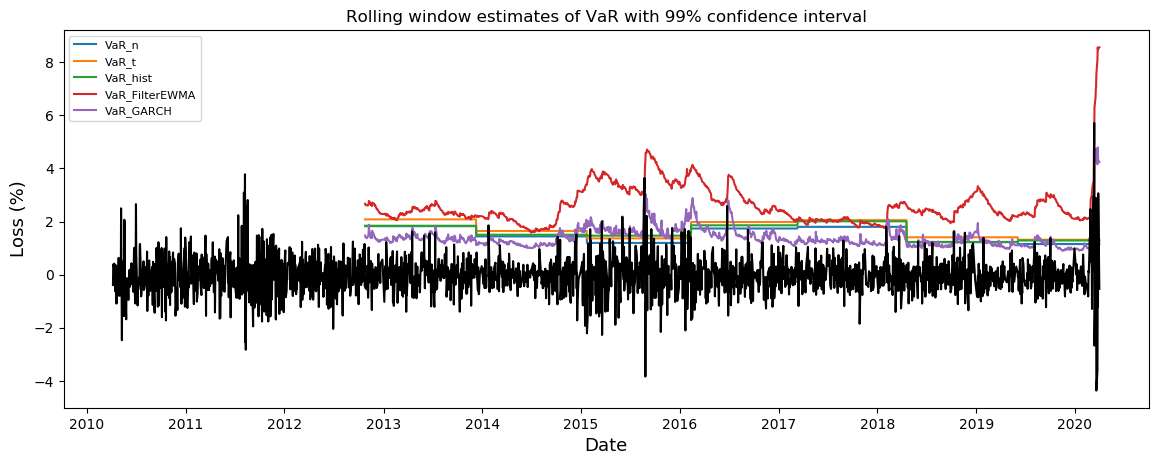

In [33]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
lLegend= list(df.columns[0::2])
#lLegend.append("8 year VaR_n")
#ten_year_normal = fnVaR_n(df_prices, weights, 0.01, 1508, [True, 0.99], initial_investment)[0]


plt.figure(figsize=(14,5),dpi=100)
plt.plot_date(df.index, df.iloc[:,0::2], linestyle="-", markersize= 0)
#plt.axhline(y=ten_year_normal, color= '#A9A9A9', linestyle= "--")
plt.plot_date(df_prices.index, -df_prices['portfolio_return'], linestyle="-", markersize= 0, color= 'k')
plt.xlabel('Date',fontsize=13)
plt.ylabel('Loss (%)',fontsize=13)
plt.title('Rolling window estimates of VaR with 99% confidence interval')
plt.legend(lLegend,loc='upper left',prop={'size': 8})

In [34]:
dfData = df_prices
dfVaR = df
def fnVaRwholeSample(dfVaR, dfData):
    '''
    purpose:
        check the VaR violations for each day for the whole sample
    input:
        dfVaR, dataframe with VaR
        dfData, dataframe of risk factors
    output:
        dfVaR_violation, dataframe with logicals for VaR violations
        True = violation
    '''
    dfVaR_violation= pd.DataFrame(np.zeros((len(dfVaR),5)))
    dfVaR_violation.index = dfVaR.index
    dfVaR_violation.columns= dfVaR.columns[0::2]
    for i in range(5):
        dfVaR_violation.iloc[:,i]= dfData.iloc[-len(dfVaR):,-1] < -dfVaR.iloc[:,i*2]

    return dfVaR_violation

In [35]:
def fnVaRandESyearly(dfData, dfVaR_violation, dfVaR, alpha):
    '''
    purpose:
        calculate the average discrepancy between realized VaR and
        expected VaR for each year. Also, calculate the expected shortfall
        for each year.
    input:
        dfVaR_violation, dataframe of boolanes of VaR violations
        dfVaR, dataframe of VaR
        alpha, significance level
    output:
        dfVaR_violation_year, dataframe of results
    '''
   
    start_year= dfVaR_violation.index[0].year
    end_year= dfVaR_violation.index[-1].year
    # initialize df for output
    dfVaR_violation_year= pd.DataFrame(np.zeros((int(end_year+1)-int(start_year),11)))
    col1= list(dfVaR.columns)
    col1.append("Trading Days")
    dfVaR_violation_year.columns= col1
    dfVaR_violation_year.index= dfVaR_violation.index.to_period("A").unique()
    
    dfVaR_realized= pd.DataFrame(np.zeros((int(end_year+1)-int(start_year),7)))
    dfVaR_realized.columns= ["VaR_n", "VaR_t", "VaR_hist", "VaR_EWMA", "VaR_GARCH","Expected", "Trading Days"]
    dfVaR_realized.index= dfVaR_violation.index.to_period("A").unique()
    
    
    for i, year in enumerate(range(start_year, end_year+1)):
        for type in range(5):
            # calculate VaR violations
            sample= dfVaR_violation[dfVaR_violation.index.year == year].iloc[:,type]
            realized= np.sum(sample)
            expected= len(sample) * alpha
            dfVaR_violation_year.iloc[i,2*type]= realized - expected
            dfVaR_violation_year.iloc[i,10]= len(sample)
            # store the realized and expected number of VaR violations
            dfVaR_realized.iloc[i,type]= realized
            dfVaR_realized.iloc[i,5]= expected
            dfVaR_realized.iloc[i,6]= len(sample)
            # calculate yearly shortfall
            ESsample= dfVaR_violation[dfVaR_violation.index.year == year]
                # select timeframe
            ReturnSample= dfData.loc[ESsample.index]
            #print(ReturnSample)
                # select losses where VaR was violated
            dailyES= -ReturnSample.iloc[:,4][ESsample.iloc[:,type]]
            dfVaR_violation_year.iloc[i,2*type+1]= np.mean(dailyES)
    
    return dfVaR_violation_year, dfVaR_realized

In [36]:
#dfVaR= fnRollingVaR(dfData, weights, alpha, 250, ewma_con, df)
#dfVaR.to_csv("Data/dfVaR_975.csv", index_label= "Date")

# read dfVaR and adjust index
#dfVaR= pd.read_csv("Data/dfVaR_975.csv", index_col= "Date")
alpha = 0.01
#df.index= df.index.to_datetime()

# check number of VaR violations for the whole sample
dfVaR_violation= fnVaRwholeSample(df, df_prices)
print(dfVaR_violation)

# check the number of VaR violations and the ES for each year
dfVaR_violation_year, dfVaR_realized= fnVaRandESyearly(df_prices, dfVaR_violation, df, alpha)


# create df with VaR on violation days
violationVaR= df[dfVaR_violation]

# save csv tables for VaR violations
#dfVaR_realized.to_csv("tables/dfVaR_realized_975.csv")
    # express ES in percentage terms
dfVaR_violation_year.iloc[:,1::2]= dfVaR_violation_year.iloc[:,1::2]*100
dfVaR_violation_year= round(dfVaR_violation_year, 2)
#dfVaR_violation_year.to_csv("tables/VaR_violation_year_975.csv")

            VaR_n  VaR_t  VaR_hist  VaR_FilterEWMA  VaR_GARCH
Date                                                         
2012-10-25  False  False     False           False      False
2012-10-26  False  False     False           False      False
2012-11-01  False  False     False           False      False
2012-11-02  False  False     False           False      False
2012-11-05  False  False     False           False      False
...           ...    ...       ...             ...        ...
2020-03-24  False  False     False           False      False
2020-03-25  False  False     False           False      False
2020-03-26  False  False     False           False      False
2020-03-27   True   True      True           False      False
2020-03-31  False  False     False           False      False

[1683 rows x 5 columns]


In [37]:
print(dfVaR_violation_year)

      VaR_n    ES_n  VaR_t    ES_t  VaR_hist  ES_hist  VaR_FilterEWMA  \
Date                                                                    
2012  -0.35     NaN  -0.35     NaN     -0.35      NaN           -0.35   
2013  -2.26     NaN  -2.26     NaN     -2.26      NaN           -2.26   
2014  -0.28  168.28  -1.28  185.59     -0.28   168.28           -2.28   
2015  14.65  175.62   8.65  201.93      6.65   216.08           -1.35   
2016   7.68  159.89   5.68  167.80      2.68   183.20           -2.32   
2017  -2.26     NaN  -2.26     NaN     -2.26      NaN           -2.26   
2018   1.74  156.35  -0.26  160.32      0.74   148.45           -1.26   
2019   0.74  132.72  -1.26  136.94     -0.26   137.41           -2.26   
2020   6.51  281.96   5.51  308.21      5.51   308.21            1.51   

      ES_FilterEWMA  VaR_GARCH  ES_GARCH  Trading Days  
Date                                                    
2012            NaN      -0.35       NaN          35.0  
2013            NaN      

In [38]:
print(dfVaR_realized)

      VaR_n  VaR_t  VaR_hist  VaR_EWMA  VaR_GARCH  Expected  Trading Days
Date                                                                     
2012    0.0    0.0       0.0       0.0        0.0      0.35          35.0
2013    0.0    0.0       0.0       0.0        4.0      2.26         226.0
2014    2.0    1.0       2.0       0.0        2.0      2.28         228.0
2015   17.0   11.0       9.0       1.0        6.0      2.35         235.0
2016   10.0    8.0       5.0       0.0        2.0      2.32         232.0
2017    0.0    0.0       0.0       0.0        1.0      2.26         226.0
2018    4.0    2.0       3.0       1.0        7.0      2.26         226.0
2019    3.0    1.0       2.0       0.0        4.0      2.26         226.0
2020    7.0    6.0       6.0       2.0        4.0      0.49          49.0


In [39]:
from scipy.stats import binom_test
method = ['normal','student t','historical','EWMA','GARCH']

for i in range(len(method)):
    pval = binom_test(dfVaR_realized.iloc[:,i].sum(),dfVaR_realized.iloc[:,-1].sum(),0.01)    

    print('p-value for '+ method[i]+' is %.5f'%(pval))

p-value for normal is 0.00000
p-value for student t is 0.00640
p-value for historical is 0.01897
p-value for EWMA is 0.00049
p-value for GARCH is 0.00298


In [40]:
# print VaR violations for whole time period
print("Normal: With alpha %.2f, the average number of violations is %.2f vs. %.2f expected." % (alpha, np.mean(dfVaR_realized.iloc[:,0]), np.mean(dfVaR_realized.iloc[:,4])))
print("Student-t: With alpha %.2f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(dfVaR_realized.iloc[:,1]), np.mean(dfVaR_realized.iloc[:,4])))
print("Historical: With alpha %.2f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(dfVaR_realized.iloc[:,2]), np.mean(dfVaR_realized.iloc[:,4])))
print("EWMA: With alpha %.2f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(dfVaR_realized.iloc[:,3]), np.mean(dfVaR_realized.iloc[:,4])))
print("GARCH: With alpha %.2f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(dfVaR_realized.iloc[:,5]), np.mean(dfVaR_realized.iloc[:,4])))

# average discrepancy of VaR violations (realized - expected)
print("Normal: With alpha %.2f, the average discrepancy is %.4f" % (alpha, np.mean(dfVaR_violation.iloc[:,0])))
print("Student-t: With alpha %.2f, the average discrepancy is %.4f" % (alpha, np.mean(dfVaR_violation.iloc[:,1])))
print("Historical: With alpha %.2f, the average discrepancy is %.4f" % (alpha, np.mean(dfVaR_violation.iloc[:,2])))
print("EWMA: With alpha %.2f, the average discrepancy is %.4f" % (alpha, np.mean(dfVaR_violation.iloc[:,3])))
print("GARCH: With alpha %.2f, the average discrepancy is %.4f" % (alpha, np.mean(dfVaR_violation.iloc[:,4])))


Normal: With alpha 0.01, the average number of violations is 4.78 vs. 3.33 expected.
Student-t: With alpha 0.01, the average number of violations is 3.22 vs. 3.33 expected
Historical: With alpha 0.01, the average number of violations is 3.00 vs. 3.33 expected
EWMA: With alpha 0.01, the average number of violations is 0.44 vs. 3.33 expected
GARCH: With alpha 0.01, the average number of violations is 1.87 vs. 3.33 expected
Normal: With alpha 0.01, the average discrepancy is 0.0255
Student-t: With alpha 0.01, the average discrepancy is 0.0172
Historical: With alpha 0.01, the average discrepancy is 0.0160
EWMA: With alpha 0.01, the average discrepancy is 0.0024
GARCH: With alpha 0.01, the average discrepancy is 0.0178


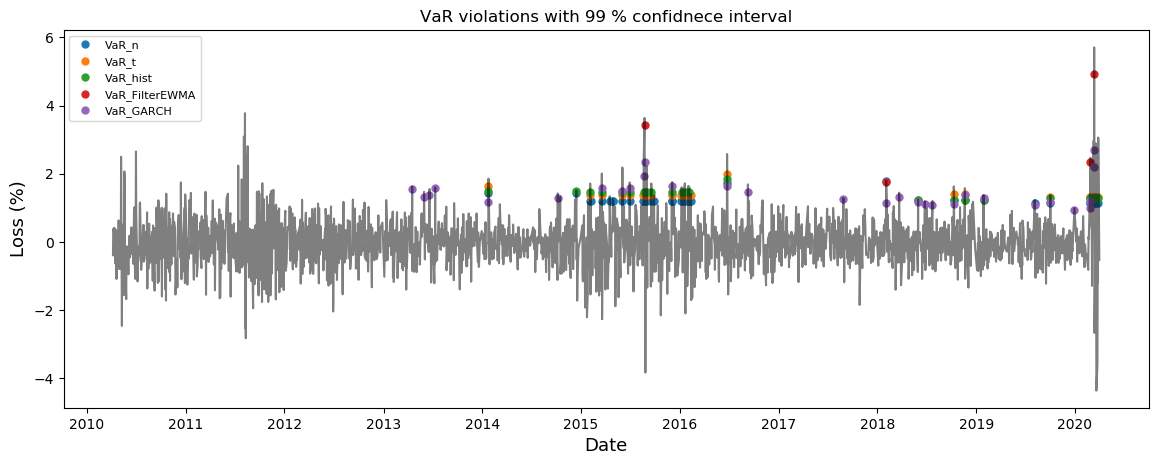

In [41]:
# plot with VaR violations
plt.figure(figsize=(14,5),dpi=100)
plt.plot_date(violationVaR.index, violationVaR.iloc[:,0::2], markersize= 5)
plt.plot_date(dfData.index, -dfData.iloc[:,-1], linestyle="-", markersize= 0, color= 'k', alpha= 0.5)
plt.legend(dfVaR.columns[0::2],loc='upper left',prop={'size': 8})
plt.xlabel('Date',fontsize=13)
plt.ylabel('Loss (%)',fontsize=13)
plt.title('VaR violations with 99 % confidnece interval')
# plt.savefig('plots/violations.png', dpi=300)
plt.show()

In [42]:
df2 = fnRollingVaR(df_prices,weights, 0.025, 500, 0.97, 4, percent=[True, 0.975],para=None,rec=True)
#df2.to_csv("01_Data/df_975.csv", index_label= "Date")

( 97.5 %  VaR, ES) in percent is:  2.08 % 2.64 %
( 97.5 %  VaR, ES) in percent is:  1.54 % 2.47 %
DF= 4
( 97.5 %  VaR, ES) in percent is:  1.54 % 2.47 %
( 97.5 %  VaR, ES) in percent is:  1.46 % 2.1 %
Optimization terminated successfully.
         Current function value: 1.633601
         Iterations: 22
         Function evaluations: 115
         Gradient evaluations: 23
Optimization terminated successfully.
         Current function value: 1.478968
         Iterations: 23
         Function evaluations: 120
         Gradient evaluations: 24
Optimization terminated successfully.
         Current function value: 1.350480
         Iterations: 29
         Function evaluations: 150
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: 2.091736
         Iterations: 31
         Function evaluations: 175
         Gradient evaluations: 35
( 97.5 %  VaR, ES) in percent is:  1.24 % 1.76 %
( 97.5 %  VaR, ES) in percent is:  2.05 % 2.61 %
( 97.5 % 

( 97.5 %  VaR, ES) in percent is:  1.83 % 2.34 %
( 97.5 %  VaR, ES) in percent is:  1.17 % 1.68 %
( 97.5 %  VaR, ES) in percent is:  1.84 % 2.34 %
( 97.5 %  VaR, ES) in percent is:  1.18 % 1.7 %
( 97.5 %  VaR, ES) in percent is:  1.82 % 2.31 %
( 97.5 %  VaR, ES) in percent is:  1.15 % 1.66 %
( 97.5 %  VaR, ES) in percent is:  1.8 % 2.28 %
( 97.5 %  VaR, ES) in percent is:  1.11 % 1.65 %
( 97.5 %  VaR, ES) in percent is:  1.81 % 2.29 %
( 97.5 %  VaR, ES) in percent is:  1.14 % 1.66 %
( 97.5 %  VaR, ES) in percent is:  1.76 % 2.26 %
( 97.5 %  VaR, ES) in percent is:  1.11 % 1.65 %
( 97.5 %  VaR, ES) in percent is:  1.77 % 2.27 %
( 97.5 %  VaR, ES) in percent is:  1.11 % 1.66 %
( 97.5 %  VaR, ES) in percent is:  1.77 % 2.26 %
( 97.5 %  VaR, ES) in percent is:  1.14 % 1.68 %
( 97.5 %  VaR, ES) in percent is:  1.77 % 2.27 %
( 97.5 %  VaR, ES) in percent is:  1.14 % 1.69 %
( 97.5 %  VaR, ES) in percent is:  1.78 % 2.28 %
( 97.5 %  VaR, ES) in percent is:  1.16 % 1.71 %
( 97.5 %  VaR, ES) in 

( 97.5 %  VaR, ES) in percent is:  2.0 % 2.57 %
( 97.5 %  VaR, ES) in percent is:  1.13 % 1.7 %
( 97.5 %  VaR, ES) in percent is:  1.97 % 2.54 %
( 97.5 %  VaR, ES) in percent is:  1.09 % 1.66 %
( 97.5 %  VaR, ES) in percent is:  1.95 % 2.51 %
( 97.5 %  VaR, ES) in percent is:  1.08 % 1.64 %
( 97.5 %  VaR, ES) in percent is:  1.92 % 2.44 %
( 97.5 %  VaR, ES) in percent is:  1.05 % 1.6 %
( 97.5 %  VaR, ES) in percent is:  1.9 % 2.41 %
( 97.5 %  VaR, ES) in percent is:  1.04 % 1.59 %
( 97.5 %  VaR, ES) in percent is:  1.88 % 2.39 %
( 97.5 %  VaR, ES) in percent is:  1.05 % 1.6 %
( 97.5 %  VaR, ES) in percent is:  1.87 % 2.38 %
( 97.5 %  VaR, ES) in percent is:  1.04 % 1.56 %
( 97.5 %  VaR, ES) in percent is:  1.85 % 2.35 %
( 97.5 %  VaR, ES) in percent is:  1.03 % 1.54 %
( 97.5 %  VaR, ES) in percent is:  1.83 % 2.33 %
( 97.5 %  VaR, ES) in percent is:  1.03 % 1.56 %
( 97.5 %  VaR, ES) in percent is:  1.81 % 2.3 %
( 97.5 %  VaR, ES) in percent is:  1.02 % 1.54 %
( 97.5 %  VaR, ES) in perc

( 97.5 %  VaR, ES) in percent is:  1.73 % 2.23 %
( 97.5 %  VaR, ES) in percent is:  1.18 % 1.44 %
( 97.5 %  VaR, ES) in percent is:  1.73 % 2.24 %
( 97.5 %  VaR, ES) in percent is:  1.12 % 1.37 %
( 97.5 %  VaR, ES) in percent is:  1.72 % 2.22 %
( 97.5 %  VaR, ES) in percent is:  1.08 % 1.34 %
( 97.5 %  VaR, ES) in percent is:  1.72 % 2.22 %
( 97.5 %  VaR, ES) in percent is:  1.06 % 1.32 %
( 97.5 %  VaR, ES) in percent is:  1.7 % 2.19 %
( 97.5 %  VaR, ES) in percent is:  1.21 % 1.44 %
DF= 4
( 97.5 %  VaR, ES) in percent is:  1.21 % 1.44 %
( 97.5 %  VaR, ES) in percent is:  1.2 % 1.44 %
Optimization terminated successfully.
         Current function value: 1.437165
         Iterations: 24
         Function evaluations: 125
         Gradient evaluations: 25
Optimization terminated successfully.
         Current function value: 1.309886
         Iterations: 25
         Function evaluations: 130
         Gradient evaluations: 26
Optimization terminated successfully.
         Current functio

( 97.5 %  VaR, ES) in percent is:  1.66 % 2.1 %
( 97.5 %  VaR, ES) in percent is:  0.97 % 1.21 %
( 97.5 %  VaR, ES) in percent is:  1.67 % 2.11 %
( 97.5 %  VaR, ES) in percent is:  0.97 % 1.23 %
( 97.5 %  VaR, ES) in percent is:  1.66 % 2.09 %
( 97.5 %  VaR, ES) in percent is:  1.0 % 1.28 %
( 97.5 %  VaR, ES) in percent is:  1.64 % 2.08 %
( 97.5 %  VaR, ES) in percent is:  0.96 % 1.21 %
( 97.5 %  VaR, ES) in percent is:  1.69 % 2.13 %
( 97.5 %  VaR, ES) in percent is:  1.05 % 1.33 %
( 97.5 %  VaR, ES) in percent is:  1.7 % 2.15 %
( 97.5 %  VaR, ES) in percent is:  1.06 % 1.33 %
( 97.5 %  VaR, ES) in percent is:  1.7 % 2.14 %
( 97.5 %  VaR, ES) in percent is:  1.06 % 1.33 %
( 97.5 %  VaR, ES) in percent is:  1.69 % 2.13 %
( 97.5 %  VaR, ES) in percent is:  1.05 % 1.33 %
( 97.5 %  VaR, ES) in percent is:  1.7 % 2.14 %
( 97.5 %  VaR, ES) in percent is:  1.06 % 1.33 %
( 97.5 %  VaR, ES) in percent is:  1.69 % 2.13 %
( 97.5 %  VaR, ES) in percent is:  1.05 % 1.33 %
( 97.5 %  VaR, ES) in per

( 97.5 %  VaR, ES) in percent is:  1.37 % 1.79 %
( 97.5 %  VaR, ES) in percent is:  0.93 % 1.23 %
( 97.5 %  VaR, ES) in percent is:  1.35 % 1.77 %
( 97.5 %  VaR, ES) in percent is:  0.93 % 1.23 %
( 97.5 %  VaR, ES) in percent is:  1.35 % 1.75 %
( 97.5 %  VaR, ES) in percent is:  0.91 % 1.23 %
( 97.5 %  VaR, ES) in percent is:  1.33 % 1.74 %
( 97.5 %  VaR, ES) in percent is:  0.9 % 1.23 %
( 97.5 %  VaR, ES) in percent is:  1.32 % 1.72 %
( 97.5 %  VaR, ES) in percent is:  0.93 % 1.23 %
( 97.5 %  VaR, ES) in percent is:  1.33 % 1.74 %
( 97.5 %  VaR, ES) in percent is:  1.0 % 1.29 %
( 97.5 %  VaR, ES) in percent is:  1.34 % 1.75 %
( 97.5 %  VaR, ES) in percent is:  0.94 % 1.23 %
( 97.5 %  VaR, ES) in percent is:  1.45 % 1.89 %
( 97.5 %  VaR, ES) in percent is:  0.99 % 1.29 %
( 97.5 %  VaR, ES) in percent is:  1.44 % 1.88 %
( 97.5 %  VaR, ES) in percent is:  0.98 % 1.27 %
( 97.5 %  VaR, ES) in percent is:  1.43 % 1.85 %
( 97.5 %  VaR, ES) in percent is:  0.95 % 1.25 %
( 97.5 %  VaR, ES) in 

( 97.5 %  VaR, ES) in percent is:  2.45 % 3.23 %
( 97.5 %  VaR, ES) in percent is:  1.38 % 1.58 %
( 97.5 %  VaR, ES) in percent is:  2.44 % 3.22 %
( 97.5 %  VaR, ES) in percent is:  1.34 % 1.58 %
( 97.5 %  VaR, ES) in percent is:  2.45 % 3.24 %
( 97.5 %  VaR, ES) in percent is:  1.6 % 1.74 %
( 97.5 %  VaR, ES) in percent is:  2.44 % 3.23 %
( 97.5 %  VaR, ES) in percent is:  1.36 % 1.58 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 3.28 %
( 97.5 %  VaR, ES) in percent is:  1.59 % 1.69 %
( 97.5 %  VaR, ES) in percent is:  2.54 % 3.34 %
( 97.5 %  VaR, ES) in percent is:  1.56 % 1.69 %
( 97.5 %  VaR, ES) in percent is:  2.61 % 3.44 %
( 97.5 %  VaR, ES) in percent is:  1.74 % 1.86 %
( 97.5 %  VaR, ES) in percent is:  2.58 % 3.41 %
( 97.5 %  VaR, ES) in percent is:  1.52 % 1.66 %
( 97.5 %  VaR, ES) in percent is:  2.6 % 3.44 %
( 97.5 %  VaR, ES) in percent is:  1.0 % 1.34 %
DF= 4
( 97.5 %  VaR, ES) in percent is:  1.0 % 1.34 %
( 97.5 %  VaR, ES) in percent is:  1.1 % 1.41 %
Optimization termin

( 97.5 %  VaR, ES) in percent is:  1.32 % 1.61 %
( 97.5 %  VaR, ES) in percent is:  2.63 % 3.54 %
( 97.5 %  VaR, ES) in percent is:  1.54 % 1.72 %
( 97.5 %  VaR, ES) in percent is:  2.59 % 3.49 %
( 97.5 %  VaR, ES) in percent is:  1.3 % 1.58 %
( 97.5 %  VaR, ES) in percent is:  2.58 % 3.48 %
( 97.5 %  VaR, ES) in percent is:  1.3 % 1.58 %
( 97.5 %  VaR, ES) in percent is:  2.54 % 3.43 %
( 97.5 %  VaR, ES) in percent is:  1.31 % 1.58 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 3.38 %
( 97.5 %  VaR, ES) in percent is:  1.26 % 1.56 %
( 97.5 %  VaR, ES) in percent is:  2.51 % 3.39 %
( 97.5 %  VaR, ES) in percent is:  1.33 % 1.61 %
( 97.5 %  VaR, ES) in percent is:  2.53 % 3.42 %
( 97.5 %  VaR, ES) in percent is:  1.43 % 1.67 %
( 97.5 %  VaR, ES) in percent is:  2.53 % 3.42 %
( 97.5 %  VaR, ES) in percent is:  1.34 % 1.64 %
( 97.5 %  VaR, ES) in percent is:  2.49 % 3.37 %
( 97.5 %  VaR, ES) in percent is:  1.3 % 1.58 %
( 97.5 %  VaR, ES) in percent is:  2.51 % 3.38 %
( 97.5 %  VaR, ES) in p

( 97.5 %  VaR, ES) in percent is:  3.4 % 4.56 %
( 97.5 %  VaR, ES) in percent is:  1.76 % 2.4 %
( 97.5 %  VaR, ES) in percent is:  3.34 % 4.49 %
( 97.5 %  VaR, ES) in percent is:  1.64 % 2.23 %
( 97.5 %  VaR, ES) in percent is:  3.36 % 4.52 %
( 97.5 %  VaR, ES) in percent is:  1.93 % 2.5 %
( 97.5 %  VaR, ES) in percent is:  3.37 % 4.51 %
( 97.5 %  VaR, ES) in percent is:  1.75 % 2.4 %
( 97.5 %  VaR, ES) in percent is:  3.41 % 4.57 %
( 97.5 %  VaR, ES) in percent is:  1.7 % 2.17 %
( 97.5 %  VaR, ES) in percent is:  3.35 % 4.5 %
( 97.5 %  VaR, ES) in percent is:  1.65 % 2.17 %
( 97.5 %  VaR, ES) in percent is:  3.34 % 4.48 %
( 97.5 %  VaR, ES) in percent is:  1.66 % 2.17 %
( 97.5 %  VaR, ES) in percent is:  3.33 % 4.47 %
( 97.5 %  VaR, ES) in percent is:  1.63 % 2.17 %
( 97.5 %  VaR, ES) in percent is:  3.36 % 4.5 %
( 97.5 %  VaR, ES) in percent is:  1.93 % 2.5 %
( 97.5 %  VaR, ES) in percent is:  3.31 % 4.45 %
( 97.5 %  VaR, ES) in percent is:  1.57 % 2.17 %
( 97.5 %  VaR, ES) in percen

( 97.5 %  VaR, ES) in percent is:  2.89 % 4.01 %
( 97.5 %  VaR, ES) in percent is:  1.8 % 2.4 %
( 97.5 %  VaR, ES) in percent is:  2.89 % 3.92 %
( 97.5 %  VaR, ES) in percent is:  1.69 % 2.09 %
( 97.5 %  VaR, ES) in percent is:  2.91 % 3.95 %
( 97.5 %  VaR, ES) in percent is:  1.87 % 2.5 %
( 97.5 %  VaR, ES) in percent is:  2.88 % 3.9 %
( 97.5 %  VaR, ES) in percent is:  1.69 % 2.09 %
( 97.5 %  VaR, ES) in percent is:  2.94 % 3.98 %
( 97.5 %  VaR, ES) in percent is:  1.95 % 2.5 %
( 97.5 %  VaR, ES) in percent is:  2.94 % 3.99 %
( 97.5 %  VaR, ES) in percent is:  1.73 % 2.23 %
( 97.5 %  VaR, ES) in percent is:  2.98 % 3.99 %
( 97.5 %  VaR, ES) in percent is:  1.78 % 2.4 %
( 97.5 %  VaR, ES) in percent is:  3.02 % 4.04 %
( 97.5 %  VaR, ES) in percent is:  1.97 % 2.5 %
( 97.5 %  VaR, ES) in percent is:  3.1 % 4.14 %
( 97.5 %  VaR, ES) in percent is:  1.79 % 2.4 %
( 97.5 %  VaR, ES) in percent is:  3.1 % 4.14 %
( 97.5 %  VaR, ES) in percent is:  1.78 % 2.4 %
( 97.5 %  VaR, ES) in percent i

( 97.5 %  VaR, ES) in percent is:  2.17 % 2.9 %
( 97.5 %  VaR, ES) in percent is:  1.33 % 1.76 %
( 97.5 %  VaR, ES) in percent is:  2.14 % 2.86 %
( 97.5 %  VaR, ES) in percent is:  1.24 % 1.66 %
( 97.5 %  VaR, ES) in percent is:  2.12 % 2.83 %
( 97.5 %  VaR, ES) in percent is:  1.17 % 1.6 %
( 97.5 %  VaR, ES) in percent is:  2.09 % 2.8 %
( 97.5 %  VaR, ES) in percent is:  1.13 % 1.56 %
( 97.5 %  VaR, ES) in percent is:  2.06 % 2.75 %
( 97.5 %  VaR, ES) in percent is:  1.08 % 1.52 %
( 97.5 %  VaR, ES) in percent is:  2.07 % 2.77 %
( 97.5 %  VaR, ES) in percent is:  1.08 % 1.52 %
( 97.5 %  VaR, ES) in percent is:  2.13 % 2.85 %
( 97.5 %  VaR, ES) in percent is:  1.18 % 1.6 %
( 97.5 %  VaR, ES) in percent is:  2.11 % 2.82 %
( 97.5 %  VaR, ES) in percent is:  1.15 % 1.57 %
( 97.5 %  VaR, ES) in percent is:  2.09 % 2.79 %
( 97.5 %  VaR, ES) in percent is:  1.12 % 1.56 %
( 97.5 %  VaR, ES) in percent is:  2.07 % 2.76 %
( 97.5 %  VaR, ES) in percent is:  1.13 % 1.56 %
( 97.5 %  VaR, ES) in pe

( 97.5 %  VaR, ES) in percent is:  2.09 % 2.67 %
( 97.5 %  VaR, ES) in percent is:  1.28 % 1.73 %
( 97.5 %  VaR, ES) in percent is:  2.07 % 2.64 %
( 97.5 %  VaR, ES) in percent is:  1.22 % 1.67 %
( 97.5 %  VaR, ES) in percent is:  2.04 % 2.61 %
( 97.5 %  VaR, ES) in percent is:  1.17 % 1.62 %
( 97.5 %  VaR, ES) in percent is:  1.99 % 2.56 %
( 97.5 %  VaR, ES) in percent is:  1.15 % 1.59 %
( 97.5 %  VaR, ES) in percent is:  2.0 % 2.53 %
( 97.5 %  VaR, ES) in percent is:  1.11 % 1.58 %
( 97.5 %  VaR, ES) in percent is:  1.98 % 2.51 %
( 97.5 %  VaR, ES) in percent is:  1.09 % 1.57 %
( 97.5 %  VaR, ES) in percent is:  1.96 % 2.49 %
( 97.5 %  VaR, ES) in percent is:  1.09 % 1.57 %
( 97.5 %  VaR, ES) in percent is:  1.95 % 2.48 %
( 97.5 %  VaR, ES) in percent is:  1.07 % 1.52 %
( 97.5 %  VaR, ES) in percent is:  1.95 % 2.49 %
( 97.5 %  VaR, ES) in percent is:  1.08 % 1.55 %
( 97.5 %  VaR, ES) in percent is:  1.94 % 2.48 %
( 97.5 %  VaR, ES) in percent is:  1.07 % 1.52 %
( 97.5 %  VaR, ES) in

( 97.5 %  VaR, ES) in percent is:  1.72 % 2.32 %
( 97.5 %  VaR, ES) in percent is:  1.04 % 1.48 %
( 97.5 %  VaR, ES) in percent is:  1.71 % 2.31 %
( 97.5 %  VaR, ES) in percent is:  1.01 % 1.46 %
( 97.5 %  VaR, ES) in percent is:  1.7 % 2.28 %
( 97.5 %  VaR, ES) in percent is:  0.99 % 1.46 %
( 97.5 %  VaR, ES) in percent is:  1.68 % 2.26 %
( 97.5 %  VaR, ES) in percent is:  0.96 % 1.45 %
( 97.5 %  VaR, ES) in percent is:  1.66 % 2.23 %
( 97.5 %  VaR, ES) in percent is:  0.94 % 1.42 %
( 97.5 %  VaR, ES) in percent is:  1.64 % 2.22 %
( 97.5 %  VaR, ES) in percent is:  0.93 % 1.41 %
( 97.5 %  VaR, ES) in percent is:  1.62 % 2.19 %
( 97.5 %  VaR, ES) in percent is:  0.91 % 1.39 %
( 97.5 %  VaR, ES) in percent is:  1.61 % 2.18 %
( 97.5 %  VaR, ES) in percent is:  0.91 % 1.39 %
( 97.5 %  VaR, ES) in percent is:  1.59 % 2.15 %
( 97.5 %  VaR, ES) in percent is:  0.9 % 1.38 %
( 97.5 %  VaR, ES) in percent is:  1.57 % 2.12 %
( 97.5 %  VaR, ES) in percent is:  0.9 % 1.38 %
( 97.5 %  VaR, ES) in p

( 97.5 %  VaR, ES) in percent is:  1.57 % 2.09 %
( 97.5 %  VaR, ES) in percent is:  1.07 % 1.54 %
( 97.5 %  VaR, ES) in percent is:  1.58 % 2.11 %
( 97.5 %  VaR, ES) in percent is:  1.07 % 1.56 %
( 97.5 %  VaR, ES) in percent is:  1.59 % 2.12 %
( 97.5 %  VaR, ES) in percent is:  1.07 % 1.54 %
( 97.5 %  VaR, ES) in percent is:  1.57 % 2.09 %
( 97.5 %  VaR, ES) in percent is:  1.04 % 1.49 %
( 97.5 %  VaR, ES) in percent is:  1.55 % 2.06 %
( 97.5 %  VaR, ES) in percent is:  1.01 % 1.46 %
( 97.5 %  VaR, ES) in percent is:  1.53 % 2.04 %
( 97.5 %  VaR, ES) in percent is:  0.99 % 1.45 %
( 97.5 %  VaR, ES) in percent is:  1.53 % 2.03 %
( 97.5 %  VaR, ES) in percent is:  0.98 % 1.45 %
( 97.5 %  VaR, ES) in percent is:  1.53 % 2.04 %
( 97.5 %  VaR, ES) in percent is:  1.02 % 1.47 %
( 97.5 %  VaR, ES) in percent is:  1.57 % 2.09 %
( 97.5 %  VaR, ES) in percent is:  1.03 % 1.49 %
( 97.5 %  VaR, ES) in percent is:  1.61 % 2.15 %
( 97.5 %  VaR, ES) in percent is:  1.14 % 1.67 %
( 97.5 %  VaR, ES) i

( 97.5 %  VaR, ES) in percent is:  1.37 % 1.84 %
( 97.5 %  VaR, ES) in percent is:  0.92 % 1.29 %
( 97.5 %  VaR, ES) in percent is:  1.38 % 1.86 %
( 97.5 %  VaR, ES) in percent is:  0.95 % 1.31 %
( 97.5 %  VaR, ES) in percent is:  1.55 % 2.1 %
( 97.5 %  VaR, ES) in percent is:  1.29 % 1.62 %
( 97.5 %  VaR, ES) in percent is:  1.55 % 2.09 %
( 97.5 %  VaR, ES) in percent is:  1.18 % 1.52 %
( 97.5 %  VaR, ES) in percent is:  1.53 % 2.07 %
( 97.5 %  VaR, ES) in percent is:  1.1 % 1.48 %
( 97.5 %  VaR, ES) in percent is:  1.51 % 2.04 %
( 97.5 %  VaR, ES) in percent is:  1.04 % 1.39 %
( 97.5 %  VaR, ES) in percent is:  1.5 % 2.02 %
( 97.5 %  VaR, ES) in percent is:  1.0 % 1.36 %
( 97.5 %  VaR, ES) in percent is:  1.48 % 2.01 %
( 97.5 %  VaR, ES) in percent is:  0.98 % 1.34 %
( 97.5 %  VaR, ES) in percent is:  1.5 % 2.02 %
( 97.5 %  VaR, ES) in percent is:  1.02 % 1.36 %
( 97.5 %  VaR, ES) in percent is:  1.49 % 2.01 %
( 97.5 %  VaR, ES) in percent is:  0.99 % 1.34 %
( 97.5 %  VaR, ES) in per

( 97.5 %  VaR, ES) in percent is:  2.03 % 2.75 %
( 97.5 %  VaR, ES) in percent is:  1.25 % 1.61 %
( 97.5 %  VaR, ES) in percent is:  2.01 % 2.73 %
( 97.5 %  VaR, ES) in percent is:  1.19 % 1.55 %
( 97.5 %  VaR, ES) in percent is:  1.98 % 2.69 %
( 97.5 %  VaR, ES) in percent is:  1.1 % 1.52 %
( 97.5 %  VaR, ES) in percent is:  1.97 % 2.67 %
( 97.5 %  VaR, ES) in percent is:  1.09 % 1.52 %
( 97.5 %  VaR, ES) in percent is:  1.97 % 2.67 %
( 97.5 %  VaR, ES) in percent is:  1.14 % 1.55 %
( 97.5 %  VaR, ES) in percent is:  1.96 % 2.66 %
( 97.5 %  VaR, ES) in percent is:  1.09 % 1.52 %
( 97.5 %  VaR, ES) in percent is:  1.97 % 2.66 %
( 97.5 %  VaR, ES) in percent is:  1.1 % 1.52 %
( 97.5 %  VaR, ES) in percent is:  2.07 % 2.79 %
( 97.5 %  VaR, ES) in percent is:  1.53 % 1.87 %
( 97.5 %  VaR, ES) in percent is:  2.09 % 2.83 %
( 97.5 %  VaR, ES) in percent is:  1.51 % 1.87 %
( 97.5 %  VaR, ES) in percent is:  2.11 % 2.85 %
( 97.5 %  VaR, ES) in percent is:  1.52 % 1.87 %
( 97.5 %  VaR, ES) in 

( 97.5 %  VaR, ES) in percent is:  1.91 % 2.52 %
( 97.5 %  VaR, ES) in percent is:  0.93 % 1.19 %
( 97.5 %  VaR, ES) in percent is:  1.9 % 2.52 %
( 97.5 %  VaR, ES) in percent is:  0.94 % 1.19 %
( 97.5 %  VaR, ES) in percent is:  1.88 % 2.49 %
( 97.5 %  VaR, ES) in percent is:  0.92 % 1.18 %
( 97.5 %  VaR, ES) in percent is:  1.88 % 2.47 %
( 97.5 %  VaR, ES) in percent is:  0.91 % 1.18 %
( 97.5 %  VaR, ES) in percent is:  1.93 % 2.53 %
( 97.5 %  VaR, ES) in percent is:  1.04 % 1.33 %
( 97.5 %  VaR, ES) in percent is:  1.92 % 2.52 %
( 97.5 %  VaR, ES) in percent is:  0.97 % 1.23 %
( 97.5 %  VaR, ES) in percent is:  1.9 % 2.48 %
( 97.5 %  VaR, ES) in percent is:  0.96 % 1.2 %
( 97.5 %  VaR, ES) in percent is:  1.91 % 2.49 %
( 97.5 %  VaR, ES) in percent is:  1.0 % 1.29 %
( 97.5 %  VaR, ES) in percent is:  1.91 % 2.48 %
( 97.5 %  VaR, ES) in percent is:  0.99 % 1.26 %
( 97.5 %  VaR, ES) in percent is:  1.88 % 2.46 %
( 97.5 %  VaR, ES) in percent is:  0.93 % 1.2 %
( 97.5 %  VaR, ES) in per

( 97.5 %  VaR, ES) in percent is:  1.96 % 2.74 %
( 97.5 %  VaR, ES) in percent is:  1.16 % 1.38 %
( 97.5 %  VaR, ES) in percent is:  2.04 % 2.86 %
( 97.5 %  VaR, ES) in percent is:  1.24 % 1.5 %
( 97.5 %  VaR, ES) in percent is:  2.07 % 2.89 %
( 97.5 %  VaR, ES) in percent is:  1.22 % 1.46 %
( 97.5 %  VaR, ES) in percent is:  2.04 % 2.85 %
( 97.5 %  VaR, ES) in percent is:  1.11 % 1.37 %
( 97.5 %  VaR, ES) in percent is:  2.07 % 2.89 %
( 97.5 %  VaR, ES) in percent is:  1.22 % 1.5 %
( 97.5 %  VaR, ES) in percent is:  2.05 % 2.87 %
( 97.5 %  VaR, ES) in percent is:  1.15 % 1.4 %
( 97.5 %  VaR, ES) in percent is:  2.03 % 2.83 %
( 97.5 %  VaR, ES) in percent is:  1.06 % 1.31 %
( 97.5 %  VaR, ES) in percent is:  2.07 % 2.89 %
( 97.5 %  VaR, ES) in percent is:  1.14 % 1.4 %
( 97.5 %  VaR, ES) in percent is:  2.13 % 2.98 %
( 97.5 %  VaR, ES) in percent is:  1.34 % 1.61 %
( 97.5 %  VaR, ES) in percent is:  2.15 % 3.01 %
( 97.5 %  VaR, ES) in percent is:  1.32 % 1.61 %
( 97.5 %  VaR, ES) in pe

( 97.5 %  VaR, ES) in percent is:  1.74 % 2.2 %
( 97.5 %  VaR, ES) in percent is:  0.89 % 1.16 %
( 97.5 %  VaR, ES) in percent is:  1.72 % 2.17 %
( 97.5 %  VaR, ES) in percent is:  0.87 % 1.15 %
( 97.5 %  VaR, ES) in percent is:  1.7 % 2.15 %
( 97.5 %  VaR, ES) in percent is:  0.86 % 1.15 %
( 97.5 %  VaR, ES) in percent is:  1.69 % 2.13 %
( 97.5 %  VaR, ES) in percent is:  0.87 % 1.16 %
( 97.5 %  VaR, ES) in percent is:  1.67 % 2.11 %
( 97.5 %  VaR, ES) in percent is:  0.86 % 1.15 %
( 97.5 %  VaR, ES) in percent is:  1.66 % 2.1 %
( 97.5 %  VaR, ES) in percent is:  0.85 % 1.15 %
( 97.5 %  VaR, ES) in percent is:  1.63 % 2.07 %
( 97.5 %  VaR, ES) in percent is:  0.83 % 1.15 %
( 97.5 %  VaR, ES) in percent is:  1.61 % 2.04 %
( 97.5 %  VaR, ES) in percent is:  0.82 % 1.14 %
( 97.5 %  VaR, ES) in percent is:  1.6 % 2.03 %
( 97.5 %  VaR, ES) in percent is:  0.86 % 1.15 %
( 97.5 %  VaR, ES) in percent is:  1.59 % 2.01 %
( 97.5 %  VaR, ES) in percent is:  0.84 % 1.15 %
( 97.5 %  VaR, ES) in pe

( 97.5 %  VaR, ES) in percent is:  2.21 % 2.81 %
( 97.5 %  VaR, ES) in percent is:  1.2 % 1.42 %
( 97.5 %  VaR, ES) in percent is:  2.2 % 2.79 %
( 97.5 %  VaR, ES) in percent is:  1.15 % 1.38 %
( 97.5 %  VaR, ES) in percent is:  2.19 % 2.78 %
( 97.5 %  VaR, ES) in percent is:  1.14 % 1.38 %
( 97.5 %  VaR, ES) in percent is:  2.16 % 2.74 %
( 97.5 %  VaR, ES) in percent is:  1.09 % 1.34 %
( 97.5 %  VaR, ES) in percent is:  2.22 % 2.82 %
( 97.5 %  VaR, ES) in percent is:  1.15 % 1.38 %
( 97.5 %  VaR, ES) in percent is:  2.21 % 2.81 %
( 97.5 %  VaR, ES) in percent is:  1.1 % 1.34 %
( 97.5 %  VaR, ES) in percent is:  2.2 % 2.81 %
( 97.5 %  VaR, ES) in percent is:  1.07 % 1.34 %
( 97.5 %  VaR, ES) in percent is:  2.18 % 2.78 %
( 97.5 %  VaR, ES) in percent is:  1.04 % 1.3 %
( 97.5 %  VaR, ES) in percent is:  2.19 % 2.78 %
( 97.5 %  VaR, ES) in percent is:  1.06 % 1.32 %
( 97.5 %  VaR, ES) in percent is:  2.18 % 2.77 %
( 97.5 %  VaR, ES) in percent is:  1.03 % 1.3 %
( 97.5 %  VaR, ES) in perc

( 97.5 %  VaR, ES) in percent is:  1.66 % 2.13 %
( 97.5 %  VaR, ES) in percent is:  0.78 % 1.14 %
( 97.5 %  VaR, ES) in percent is:  1.68 % 2.16 %
( 97.5 %  VaR, ES) in percent is:  0.82 % 1.16 %
( 97.5 %  VaR, ES) in percent is:  1.66 % 2.13 %
( 97.5 %  VaR, ES) in percent is:  0.81 % 1.16 %
( 97.5 %  VaR, ES) in percent is:  1.66 % 2.13 %
( 97.5 %  VaR, ES) in percent is:  0.79 % 1.13 %
( 97.5 %  VaR, ES) in percent is:  1.69 % 2.17 %
( 97.5 %  VaR, ES) in percent is:  0.82 % 1.16 %
( 97.5 %  VaR, ES) in percent is:  1.7 % 2.2 %
( 97.5 %  VaR, ES) in percent is:  0.82 % 1.16 %
( 97.5 %  VaR, ES) in percent is:  1.68 % 2.19 %
( 97.5 %  VaR, ES) in percent is:  0.8 % 1.16 %
( 97.5 %  VaR, ES) in percent is:  1.68 % 2.18 %
( 97.5 %  VaR, ES) in percent is:  0.79 % 1.13 %
( 97.5 %  VaR, ES) in percent is:  1.65 % 2.15 %
( 97.5 %  VaR, ES) in percent is:  0.78 % 1.13 %
( 97.5 %  VaR, ES) in percent is:  1.63 % 2.12 %
( 97.5 %  VaR, ES) in percent is:  0.77 % 1.11 %
( 97.5 %  VaR, ES) in p

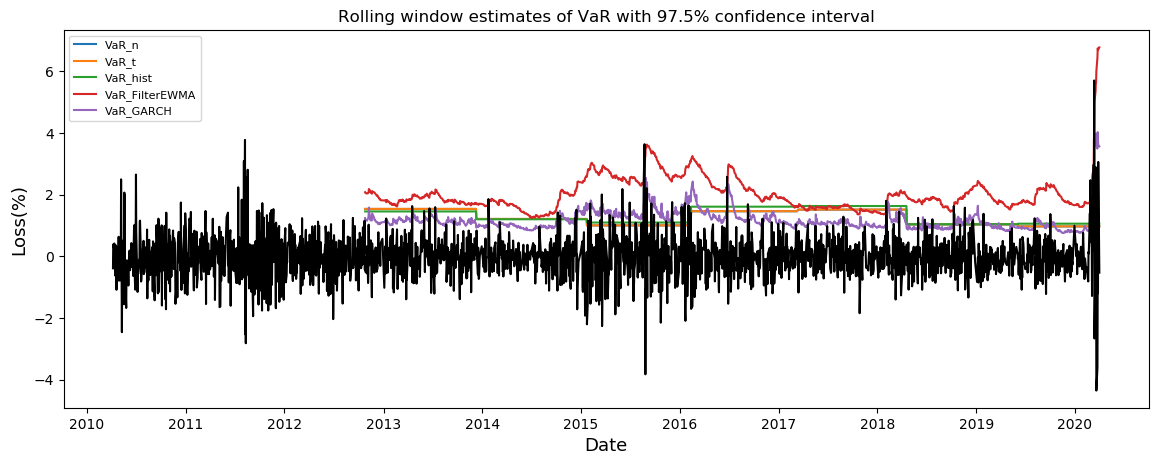

In [43]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
lLegend= list(df2.columns[0::2])
#lLegend.append("8 year VaR_n")
#ten_year_normal = fnVaR_n(df_prices, weights, 0.025,1508, [True, 0.975], initial_investment)[0]

plt.figure(figsize=(14,5),dpi=100)
plt.plot_date(df2.index, df2.iloc[:,0::2], linestyle="-", markersize= 0)
#plt.axhline(ten_year_normal, color= '#A9A9A9', linestyle= "--")
plt.plot_date(df_prices.index, -df_prices['portfolio_return'], linestyle="-", markersize= 0, color= 'k')
plt.xlabel('Date',fontsize=13)
plt.ylabel('Loss(%)',fontsize=13)
plt.title('Rolling window estimates of VaR with 97.5% confidence interval')
plt.legend(lLegend,loc='upper left',prop={'size': 8})

In [44]:

df2VaR = df2

alpha = 0.025
#df2.index= df2.index.to_datetime()

# check number of VaR violations for the whole sample
df2VaR_violation= fnVaRwholeSample(df2, df_prices)
#print(df2VaR_violation)

# check the number of VaR violations and the ES for each year
df2VaR_violation_year, df2VaR_realized= fnVaRandESyearly(df_prices, df2VaR_violation, df2, alpha)


# create df2 with VaR on violation days
violationVaR= df2[df2VaR_violation]


df2VaR_violation_year.iloc[:,1::2]= df2VaR_violation_year.iloc[:,1::2]*100
df2VaR_violation_year= round(df2VaR_violation_year, 2)


In [45]:
print(df2VaR_violation_year)

      VaR_n    ES_n  VaR_t    ES_t  VaR_hist  ES_hist  VaR_FilterEWMA  \
Date                                                                    
2012  -0.88     NaN  -0.88     NaN     -0.88      NaN           -0.88   
2013  -2.65  159.13  -2.65  159.13     -1.65   156.03           -5.65   
2014   0.30  142.83   0.30  142.83      0.30   142.83           -4.70   
2015  23.12  148.30  23.12  148.30     16.12   161.81           -3.88   
2016   5.20  160.71   5.20  160.71      5.20   160.71           -4.80   
2017  -5.65     NaN  -5.65     NaN     -5.65      NaN           -5.65   
2018   4.35  131.37   4.35  131.37      4.35   131.37           -3.65   
2019  -1.65  124.34  -1.65  124.34     -2.65   132.72           -5.65   
2020   6.78  260.80   6.78  260.80      6.78   260.80            1.78   

      ES_FilterEWMA  VaR_GARCH  ES_GARCH  Trading Days  
Date                                                    
2012            NaN      -0.88       NaN          35.0  
2013            NaN      

In [46]:
df2VaR_realized

VaR_n  VaR_t  VaR_hist  VaR_EWMA  VaR_GARCH  Expected  Trading Days
Date                                                                     
2012    0.0    0.0       0.0       0.0        0.0     0.875          35.0
2013    3.0    3.0       4.0       0.0        6.0     5.650         226.0
2014    6.0    6.0       6.0       1.0        7.0     5.700         228.0
2015   29.0   29.0      22.0       2.0       14.0     5.875         235.0
2016   11.0   11.0      11.0       1.0        7.0     5.800         232.0
2017    0.0    0.0       0.0       0.0        4.0     5.650         226.0
2018   10.0   10.0      10.0       2.0        8.0     5.650         226.0
2019    4.0    4.0       3.0       0.0        4.0     5.650         226.0
2020    8.0    8.0       8.0       3.0        4.0     1.225          49.0

In [47]:
from scipy.stats import binom_test
method = ['normal','student t','historical','EWMA','GARCH']

for i in range(len(method)):
    pval = binom_test(df2VaR_realized.iloc[:,i].sum(),df2VaR_realized.iloc[:,-1].sum(),0.01)    

    print('p-value for '+ method[i]+' is %.5f'%(pval))

p-value for normal is 0.00000
p-value for student t is 0.00000
p-value for historical is 0.00000
p-value for EWMA is 0.06412
p-value for GARCH is 0.00000


In [48]:
# print VaR violations for whole time period
print("Normal: With alpha %.3f, the average number of violations is %.2f vs. %.2f expected." % (alpha, np.mean(df2VaR_realized.iloc[:,0]), np.mean(df2VaR_realized.iloc[:,4])))
print("Student-t: With alpha %.3f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(df2VaR_realized.iloc[:,1]), np.mean(df2VaR_realized.iloc[:,4])))
print("Historical: With alpha %.3f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(df2VaR_realized.iloc[:,2]), np.mean(df2VaR_realized.iloc[:,4])))
print("EWMA: With alpha %.3f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(df2VaR_realized.iloc[:,3]), np.mean(df2VaR_realized.iloc[:,4])))
print("GARCH: With alpha %.3f, the average number of violations is %.2f vs. %.2f expected" % (alpha, np.mean(df2VaR_realized.iloc[:,5]), np.mean(df2VaR_realized.iloc[:,4])))

# average discrepancy of VaR violations (realized - expected)
print("Normal: With alpha %.3f, the average discrepancy is %.4f" % (alpha, np.mean(df2VaR_violation.iloc[:,0])))
print("Student-t: With alpha %.3f, the average discrepancy is %.4f" % (alpha, np.mean(df2VaR_violation.iloc[:,1])))
print("Historical: With alpha %.3f, the average discrepancy is %.4f" % (alpha, np.mean(df2VaR_violation.iloc[:,2])))
print("EWMA: With alpha %.3f, the average discrepancy is %.4f" % (alpha, np.mean(df2VaR_violation.iloc[:,3])))
print("GARCH: With alpha %.3f, the average discrepancy is %.4f" % (alpha, np.mean(df2VaR_violation.iloc[:,4])))

Normal: With alpha 0.025, the average number of violations is 7.89 vs. 6.00 expected.
Student-t: With alpha 0.025, the average number of violations is 7.89 vs. 6.00 expected
Historical: With alpha 0.025, the average number of violations is 7.11 vs. 6.00 expected
EWMA: With alpha 0.025, the average number of violations is 1.00 vs. 6.00 expected
GARCH: With alpha 0.025, the average number of violations is 4.68 vs. 6.00 expected
Normal: With alpha 0.025, the average discrepancy is 0.0422
Student-t: With alpha 0.025, the average discrepancy is 0.0422
Historical: With alpha 0.025, the average discrepancy is 0.0380
EWMA: With alpha 0.025, the average discrepancy is 0.0053
GARCH: With alpha 0.025, the average discrepancy is 0.0321


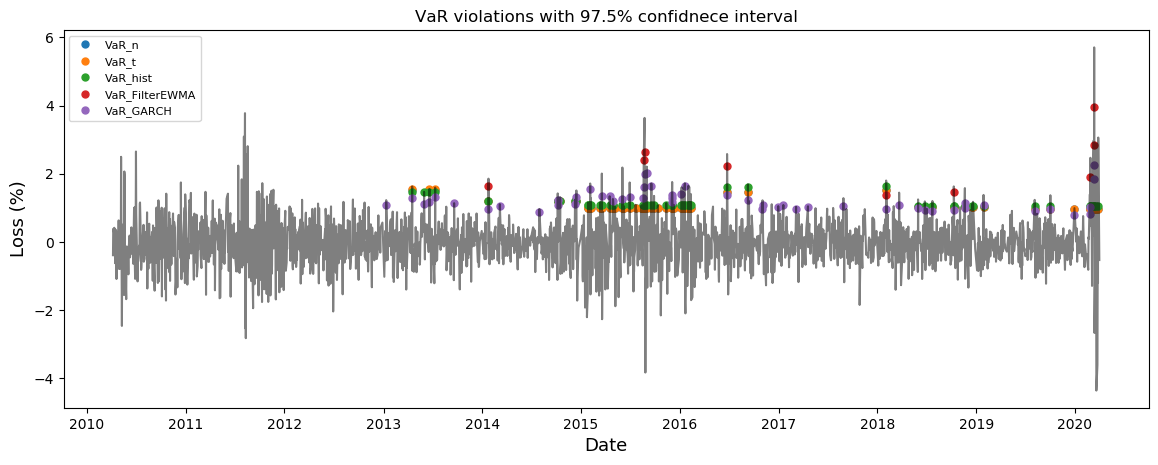

In [49]:
# plot with VaR violations
plt.figure(figsize=(14,5),dpi=100)
plt.plot_date(violationVaR.index, violationVaR.iloc[:,0::2], markersize= 5)
plt.plot_date(dfData.index, -dfData.iloc[:,-1], linestyle="-", markersize= 0, color= 'k', alpha= 0.5)
plt.legend(df2VaR.columns[0::2],loc='upper left',prop={'size': 8})
plt.xlabel('Date',fontsize=13)
plt.ylabel('Loss (%)',fontsize=13)
plt.title('VaR violations with 97.5% confidnece interval')
# plt.savefig('plots/violations.png', dpi=300)
plt.show()

### Empirical 5- and 10-days VaRs

In [50]:
initial_investment = 1000000
data = df_prices.iloc[7:,:]
lookback = len(data)
df = 3
# 5-day VaR
df5=   data.groupby(np.arange(len( data))//5).sum()
df5.index=  data.index[::5]
lookback5= lookback//5 # set lookback for 5 day VaR
# 10-day VaR   
df10=  data.groupby(np.arange(len( data))//10).sum()
df10.index=  data.index[::10]
lookback10= lookback//10 # set lookback for 10 day VaR

Methods= ["Normal", "Student-t", "Historical","GARCH"]
Cols= ["5d_99","sq5d_99","10d_99","sq10d_99","5d_975","sq5d_975","10d_975","sq10d_975"]
dfEmpirical= pd.DataFrame(np.zeros((len(Methods),len(Cols))), index = Methods, columns= Cols)

alpha_x= np.array([0.01,0.025 ])                                  # Different confidences
lookback_x= np.array([lookback5, lookback, lookback10, lookback])   # Compare with sqrt time
df1=  data.copy()
dfx= pd.DataFrame([df5, df1, df10, df1])
print(dfx.iloc[1:0])
for i in range(len(alpha_x)): 
    percent = [True,1-alpha_x[i]] 
    for j in range(len(lookback_x)):
        #dfEmpirical.iloc[0,j+4*i], null= fnVaR_n(dfx.iloc[j,0], weights, alpha_x[i], lookback_x[j], percent,initial_investment)
        #dfEmpirical.iloc[1,j+4*i], null= fnVaR_t(dfx.iloc[j,0], weights, lookback_x[j],df, alpha_x[i], percent, initial_investment)
        dfEmpirical.iloc[2,j+4*i], null= fnVaR_hist(dfx.iloc[j,0], weights, alpha_x[i], lookback_x[j], percent,initial_investment)
        #dfEmpirical.iloc[3,j+4*i], null= fnVaR_FilterEWMA(dfx.iloc[j,0], weights2, 0.94, alpha_x[i], lookback_x[j], percent,initial_investment)
        #garch = fnVaR_GARCH(dfx.iloc[j,0], weights, alpha_x[i], lookback_x[j], percent,initial_investment,para=None,Variances=None,rec=True)
        #dfEmpirical.iloc[3,j+4*i], null = garch[0],garch[1]
        if j == 1:
            dfEmpirical.iloc[:,j+4*i]= dfEmpirical.iloc[:,j+4*i]*np.sqrt(5)
        elif j == 3:
            dfEmpirical.iloc[:,j+4*i]= dfEmpirical.iloc[:,j+4*i]*np.sqrt(10)
# Convert output based on whether its df_prices.iloc[1:,:] or portfolio value
if percent[0] == False:
    dfEmpirical= (dfEmpirical*initial_investment).round(-1).astype(int)
else:
    dfEmpirical= (dfEmpirical).round(2)  
#dfEmpirical.to_csv("Tables/dfEmpiricalPercentages.csv", index_label= "Method")

Empty DataFrame
Columns: [0]
Index: []
( 99.0 %  VaR, ES) in percent is:  4.27 % 5.81 %
( 99.0 %  VaR, ES) in percent is:  1.77 % 2.67 %
( 99.0 %  VaR, ES) in percent is:  4.8 % 7.28 %
( 99.0 %  VaR, ES) in percent is:  1.77 % 2.67 %
( 97.5 %  VaR, ES) in percent is:  3.47 % 4.63 %
( 97.5 %  VaR, ES) in percent is:  1.4 % 2.0 %
( 97.5 %  VaR, ES) in percent is:  3.73 % 5.76 %
( 97.5 %  VaR, ES) in percent is:  1.4 % 2.0 %


In [51]:
'''EWMA need more days, so it doesn't work for this one'''
dfEmpirical

5d_99  sq5d_99  10d_99  sq10d_99  5d_975  sq5d_975  10d_975  \
Normal       0.00     0.00     0.0      0.00    0.00      0.00     0.00   
Student-t    0.00     0.00     0.0      0.00    0.00      0.00     0.00   
Historical   4.27     3.95     4.8      5.59    3.47      3.12     3.73   
GARCH        0.00     0.00     0.0      0.00    0.00      0.00     0.00   

            sq10d_975  
Normal           0.00  
Student-t        0.00  
Historical       4.42  
GARCH            0.00

Check the correlation between assets

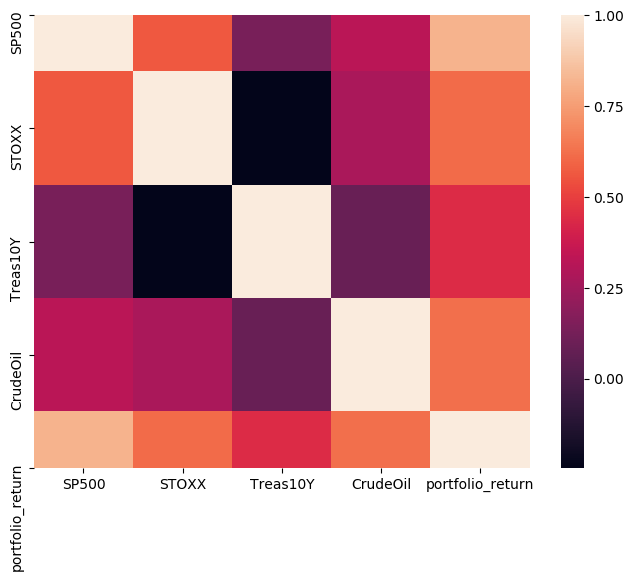

In [52]:
import seaborn as sns
plt.figure(figsize=(8,6),dpi=100)
corr = df_prices.corr()
sns.heatmap(corr)

In [55]:
corr

SP500     STOXX  Treas10Y  CrudeOil  portfolio_return
SP500             1.000000  0.565312  0.136205  0.324147          0.748686
STOXX             0.565312  1.000000 -0.246601  0.274521          0.568593
Treas10Y          0.136205 -0.246601  1.000000  0.088666          0.381981
CrudeOil          0.324147  0.274521  0.088666  1.000000          0.776824
portfolio_return  0.748686  0.568593  0.381981  0.776824          1.000000